<a href="https://colab.research.google.com/github/mariemmanue/Dissertation/blob/main/Nathan_PIpeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U google-genai

In [ ]:
!pip -q install nest_asyncio pandas tqdm scikit-learn sentence-transformers torch
!pip -q install -U google-genai


# ---- Imports ----
import os, json, re, random, math, asyncio, logging, warnings, textwrap, copy
from typing import List, Dict, Any, Tuple, Optional
from collections import defaultdict, Counter
import nest_asyncio; nest_asyncio.apply()

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from getpass import getpass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sentence_transformers import SentenceTransformer

from google import genai
from google.genai import types

# Suppress noisy logs
for name in ["httpx", "urllib3", "google"]:
    logging.getLogger(name).setLevel(logging.ERROR)
warnings.filterwarnings("ignore")


# =========================
# 🔐 Setup
# =========================
try:
    from google.colab import userdata
except Exception:
    userdata = None

if userdata:
    os.environ["GEMINI_API_KEY"] = os.environ.get("GEMINI_API_KEY") or userdata.get("GEMINI_API_KEY")
if not os.environ.get("GEMINI_API_KEY"):
    os.environ["GEMINI_API_KEY"] = getpass("Enter your Gemini API Key: ")

HF_TOKEN = os.environ.get("HF_TOKEN") or (userdata.get("HF_TOKEN") if userdata else None)
if HF_TOKEN:
    from huggingface_hub import login
    try:
        login(HF_TOKEN)
        print("✅ HuggingFace login successful.")
    except Exception as e:
        print(f"(note) HF login failed: {e}")

GEN_CLIENT = genai.Client()


# =========================
# 📁 Load CSV
# =========================
CSV_PATH_CANDIDATES = [
    "/content/FeatureDetection.xlsx - Ground Truth (original).csv",
    "/mnt/data/FeatureDetection.xlsx - Ground Truth (original).csv",
]
def _first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return paths[0]

CSV_PATH = _first_existing(CSV_PATH_CANDIDATES)
print(f"📄 Ground-truth CSV: {CSV_PATH}")


# =========================
# 🧠 Feature Definitions (Enhanced)
# =========================
FEATURE_CRITERIA: Dict[str, Dict[str, Any]] = {
    "aint": {
        "definition": "'Ain't' used as negative auxiliary/copula for 'is/are/am not', 'has/have not', or 'do/does/did not'.",
        "examples_positive": ["I ain't going nowhere.", "She ain't seen him yet.", "They ain't ready."],
        "examples_negative": ["I'm not going anywhere.", "She hasn't seen him.", "They aren't ready."],
        "key_patterns": ["ain't", "aint"],
    },
    "appositive_pleonastic_pronoun": {
        "definition": "Double subject: full NP subject immediately followed by co-referential pronoun (e.g., 'My mama she...').",
        "examples_positive": ["My mama she always cooking.", "Them boys they be loud.", "The teacher she don't play."],
        "examples_negative": ["My mama is always cooking.", "Those boys are loud.", "The teacher doesn't play."],
        "key_patterns": ["[NP] + [pronoun] + [verb]"],
    },
    "be_construction": {
        "definition": "Invariant 'be' marking habitual aspect (not agreement error).",
        "examples_positive": ["They be playing outside.", "She be working late.", "He be trippin sometimes."],
        "examples_negative": ["They usually play outside.", "She works late.", "He is tripping."],
        "key_patterns": ["[subject] be [verb+ing]"],
    },
    "bin": {
        "definition": "Stressed 'been' (BIN) signaling remote past or emphatic truth.",
        "examples_positive": ["She been finished.", "I been knew that.", "They been gone."],
        "examples_negative": ["She has finished.", "I already knew that.", "They left."],
        "key_patterns": ["been [verb]", "BIN [verb]"],
    },
    "come": {
        "definition": "Quasi-auxiliary 'come' before present-participle conveying disapproval.",
        "examples_positive": ["He come walking in acting crazy.", "She come talking bout nothing."],
        "examples_negative": ["He walked in acting crazy.", "She's talking about nothing."],
        "key_patterns": ["come [verb+ing]"],
    },
    "demonstrative_them": {
        "definition": "'Them' as demonstrative determiner meaning 'those'.",
        "examples_positive": ["I like them shoes.", "Look at them kids.", "Them books over there."],
        "examples_negative": ["I like those shoes.", "Look at those kids.", "Those books over there."],
        "key_patterns": ["them [noun]"],
    },
    "existential_it": {
        "definition": "Expletive 'it' in existential constructions (Standard: 'there').",
        "examples_positive": ["It's a dog in the yard.", "It was people outside.", "It ain't nothing here."],
        "examples_negative": ["There's a dog in the yard.", "There were people outside.", "There's nothing here."],
        "key_patterns": ["it's/it was [NP]"],
    },
    "finna": {
        "definition": "Immediate future 'finna' (fixin' to), meaning 'about to'.",
        "examples_positive": ["I'm finna go.", "She finna leave.", "We finna eat."],
        "examples_negative": ["I'm about to go.", "She's leaving.", "We're going to eat."],
        "key_patterns": ["finna", "fixin' to"],
    },
    "multiple_neg": {
        "definition": "Negative concord: multiple negative elements for single negation.",
        "examples_positive": ["I didn't see nobody.", "She don't want nothing.", "Can't nobody tell me nothing."],
        "examples_negative": ["I didn't see anybody.", "She doesn't want anything.", "Nobody can tell me anything."],
        "key_patterns": ["didn't...nobody/nothing", "don't...no"],
    },
    "nonstand_past": {
        "definition": "Nonstandard past-tense forms (e.g., 'seen', 'knowed', 'done went').",
        "examples_positive": ["He seen it yesterday.", "She knowed better.", "They done went home."],
        "examples_negative": ["He saw it yesterday.", "She knew better.", "They went home."],
        "key_patterns": ["seen", "knowed", "done went", "had went"],
    },
    "tense_agreement_deviation": {
        "definition": "Subject-verb agreement or tense deviation from Standard English.",
        "examples_positive": ["They is ready.", "She don't know.", "He go there yesterday."],
        "examples_negative": ["They are ready.", "She doesn't know.", "He went there yesterday."],
        "key_patterns": ["they/we is", "she/he don't", "mismatched tense"],
    },
    "is_was_gen": {
        "definition": "Generalized 'is/was' across subjects (invariant copula/auxiliary).",
        "examples_positive": ["We was there.", "They was playing.", "I is ready."],
        "examples_negative": ["We were there.", "They were playing.", "I am ready."],
        "key_patterns": ["we/they was", "I is"],
    },
    "zero_3sg_pres": {
        "definition": "Zero 3rd-person singular present -s on lexical verbs.",
        "examples_positive": ["She walk to school.", "He like pizza.", "It look good."],
        "examples_negative": ["She walks to school.", "He likes pizza.", "It looks good."],
        "key_patterns": ["he/she/it [verb without -s]"],
    },
    "resultant_done": {
        "definition": "Perfective 'done' marking completion (not standard 'has done').",
        "examples_positive": ["He done ate already.", "They done broke it.", "I done told you."],
        "examples_negative": ["He has eaten already.", "They broke it.", "I told you."],
        "key_patterns": ["done [past verb]"],
    },
    "wh_qu": {
        "definition": "Wh-question without subject-auxiliary inversion or do-support.",
        "examples_positive": ["What he doing?", "Where you went?", "Why she mad?"],
        "examples_negative": ["What is he doing?", "Where did you go?", "Why is she mad?"],
        "key_patterns": ["what/where/why [subject] [verb]"],
    },
    "zero_copula": {
        "definition": "Zero copula/auxiliary 'be' where contraction possible.",
        "examples_positive": ["She my sister.", "They running.", "He tall."],
        "examples_negative": ["She's my sister.", "They're running.", "He's tall."],
        "key_patterns": ["[subject] [adjective/noun/verb+ing]"],
    },
    "zero_pl_s": {
        "definition": "Zero plural -s on count nouns in quantified contexts.",
        "examples_positive": ["Two dollar.", "Many time.", "Five year ago."],
        "examples_negative": ["Two dollars.", "Many times.", "Five years ago."],
        "key_patterns": ["[number] [noun without -s]"],
    },
    "zero_poss": {
        "definition": "Zero possessive marking on possessor NP.",
        "examples_positive": ["My brother car.", "The girl bag.", "John house."],
        "examples_negative": ["My brother's car.", "The girl's bag.", "John's house."],
        "key_patterns": ["[NP] [noun] (without 's)"],
    },
}


# =========================
# 📊 Load and analyze data
# =========================
df = pd.read_csv(CSV_PATH)

def _detect_sentence_col(columns):
    for cand in ["sentence", "text", "utterance", "line"]:
        for c in columns:
            if c.strip().lower() == cand:
                return c
    return columns[0]

SENTENCE_COL = _detect_sentence_col(df.columns)

FEATURE_COLS = []
for c in df.columns:
    if c == SENTENCE_COL:
        continue
    vals = set(pd.Series(df[c]).dropna().unique().tolist())
    if vals.issubset({0,1}) and len(vals) > 0:
        FEATURE_COLS.append(c)

print(f"Detected sentence column: {SENTENCE_COL!r}")
print(f"Detected {len(FEATURE_COLS)} binary features: {', '.join(FEATURE_COLS)}")

print("\n📊 Feature Distribution Analysis:")
for feat in FEATURE_COLS:
    pos_count = df[feat].sum()
    total = len(df)
    print(f"  {feat}: {pos_count}/{total} ({100*pos_count/total:.1f}% positive)")


# =========================
# 🔀 Train/Val/Test split
# =========================
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

def safe_stratified_split(df, feature_cols, test_size, random_state):
    viable_feats = []
    for feat in feature_cols:
        pos_count = df[feat].sum()
        if pos_count >= 10:
            viable_feats.append(feat)
    for n_feats in [min(3, len(viable_feats)), min(2, len(viable_feats)), 1, 0]:
        if n_feats == 0:
            print("⚠️  Stratification not possible. Using random split.")
            return train_test_split(df, test_size=test_size, random_state=random_state, shuffle=True)
        try:
            strat_feats = viable_feats[:n_feats]
            strat_key = df[strat_feats].apply(lambda row: ''.join([str(int(row[f])) for f in strat_feats]), axis=1)
            class_counts = strat_key.value_counts()
            if (class_counts >= 2).all():
                print(f"✓ Using stratification on {n_feats} feature(s): {', '.join(strat_feats)}")
                return train_test_split(df, test_size=test_size, random_state=random_state, stratify=strat_key, shuffle=True)
        except (ValueError, KeyError):
            continue
    print("⚠️  All stratification attempts failed. Using random split.")
    return train_test_split(df, test_size=test_size, random_state=random_state, shuffle=True)

print("\n🔀 Splitting data...")
train_df, val_test_df = safe_stratified_split(df[[SENTENCE_COL] + FEATURE_COLS], FEATURE_COLS, test_size=0.20, random_state=RANDOM_SEED)
val_df, test_df = safe_stratified_split(val_test_df, FEATURE_COLS, test_size=0.50, random_state=RANDOM_SEED)
print(f"📦 Data Split: Train={len(train_df)} | Val={len(val_df)} | Test={len(test_df)}")


# =========================
# 🤖 Enhanced Synthetic Data Generation
# =========================
GEN_MODEL = "gemini-2.5-flash"
GEN_TEMPERATURE = 0.5
GEN_MAX_TOKENS = 10000

def select_few_shot_examples(train_df: pd.DataFrame, feature_cols: List[str], target_combo: Dict[str, int], n: int = 3) -> List[Tuple[str, Dict]]:
    pos_feats = set([f for f, v in target_combo.items() if v == 1])
    candidates = []
    for _, row in train_df.iterrows():
        row_feats = set([f for f in feature_cols if row[f] == 1])
        overlap = len(pos_feats & row_feats)
        if overlap > 0:
            candidates.append((overlap, row[SENTENCE_COL], {f: int(row[f]) for f in feature_cols}))
    candidates.sort(reverse=True, key=lambda x: x[0])
    return [(sent, combo) for _, sent, combo in candidates[:n]]

async def generate_synthetic_example(
    original_sentence: str,
    combo: Dict[str, int],
    few_shot_examples: List[Tuple[str, Dict]],
    sem: asyncio.Semaphore,
    variant: int = 0,
    seed: Optional[int] = None
) -> str:
    """Generate one synthetic example with seeding for diversity."""

    # Generate unique seed if not provided
    if seed is None:
        seed = hash((original_sentence, tuple(sorted(combo.items())), variant)) % (2**31)

    pos_feats = [f for f, v in combo.items() if v == 1]
    neg_feats = [f for f, v in combo.items() if v == 0]

    # Enhanced AAE context
    aae_context = (
        "African American English (AAE) is a legitimate, rule-governed dialect with systematic grammatical patterns. "
        "Your goal is to generate sentences that sound natural and authentic to native AAE speakers, not stereotypical or forced."
    )

    # Better few-shot formatting
    few_shot_text = ""
    if few_shot_examples:
        few_shot_text = "\n**REFERENCE EXAMPLES (similar feature combinations)**:\n"
        for i, (sent, ex_combo) in enumerate(few_shot_examples[:3], 1):
            ex_feats = [f for f, v in ex_combo.items() if v == 1]
            few_shot_text += f'{i}. "{sent}"\n   Features: {", ".join(ex_feats)}\n'

    # More detailed feature descriptions
    feat_defs = "\n**REQUIRED FEATURES** (ALL must be present):\n"
    for f in pos_feats:
        info = FEATURE_CRITERIA.get(f, {})
        feat_defs += f"\n{f.upper().replace('_', ' ')}:\n"
        feat_defs += f"  • Definition: {info.get('definition', 'N/A')}\n"

        if 'examples_positive' in info:
            feat_defs += f"  • Natural examples:\n"
            for ex in info['examples_positive'][:3]:
                feat_defs += f"    - \"{ex}\"\n"

        if 'key_patterns' in info:
            patterns = info['key_patterns']
            if isinstance(patterns, list) and patterns:
                feat_defs += f"  • Key markers: {', '.join(patterns[:3])}\n"

    # Clearer negative constraints
    negative_constraints = ""
    if neg_feats:
        negative_constraints = "\n**FORBIDDEN FEATURES** (NONE of these should appear):\n"
        for f in neg_feats[:5]:
            info = FEATURE_CRITERIA.get(f, {})
            negative_constraints += f"  • {f}: {info.get('definition', 'N/A')}\n"

    # Contextual diversity based on seed
    context_themes = [
        "Create a sentence about someone's daily activities or habits",
        "Create a sentence expressing someone's opinion or emotional state",
        "Create a sentence describing a person, place, or thing",
        "Create a sentence recounting something that happened",
        "Create a sentence about future plans or intentions",
        "Create a sentence giving advice or making a suggestion",
        "Create a sentence about a conversation or interaction",
        "Create a sentence comparing or contrasting things",
    ]
    theme = context_themes[seed % len(context_themes)]

    prompt = (
        f"{aae_context}\n\n"
        f"**YOUR TASK**: Generate ONE new AAE sentence with specific grammatical features.\n\n"
        f'**REFERENCE SENTENCE** (for feature inspiration, NOT to copy):\n"{original_sentence}"\n'
        f"{few_shot_text}\n"
        f"{feat_defs}\n"
        f"{negative_constraints}\n"
        f"**CONTENT DIRECTION**:\n"
        f"  • {theme}\n"
        f"  • Use natural, conversational AAE (8-18 words)\n"
        f"  • Vary vocabulary and sentence structure from the reference\n"
        f"  • Ensure ALL required features are clearly present\n"
        f"  • Make it sound like something a real person would naturally say\n"
        f"  • Avoid clichés, stereotypes, or awkward constructions\n\n"
        f"**CRITICAL**: The sentence MUST contain ALL required features and NONE of the forbidden features.\n\n"
        f'Output ONLY valid JSON: {{"sentence": "your new sentence here"}}'
    )

    gen_config = types.GenerateContentConfig(
        temperature=GEN_TEMPERATURE,
        max_output_tokens=GEN_MAX_TOKENS,
        response_mime_type="application/json",
    )

    async with sem:
        out = await GEN_CLIENT.aio.models.generate_content(
            model=GEN_MODEL,
            contents=prompt,
            config=gen_config,
        )

    raw = (out.text or "").strip()
    assert raw, "Empty response from model"

    obj = json.loads(raw)
    sent = obj.get("sentence", "").strip()
    return sent


def quality_filter_synthetic(sentence: str, original: str, combo: Dict[str, int]) -> bool:
    """Enhanced quality filtering."""

    # Basic length check
    if not sentence or len(sentence.strip()) < 10 or len(sentence.split()) < 5:
        return False

    # Token overlap check (stricter)
    sent_words = set(sentence.lower().split())
    orig_words = set(original.lower().split())
    overlap = len(sent_words & orig_words) / max(len(sent_words), 1)
    if overlap > 0.6:
        return False

    # Check for required feature markers
    pos_feats = [f for f, v in combo.items() if v == 1]
    markers_found = 0

    for feat in pos_feats:
        patterns = FEATURE_CRITERIA.get(feat, {}).get('key_patterns', [])
        if patterns and isinstance(patterns[0], str):
            has_marker = any(
                p.lower() in sentence.lower()
                for p in patterns
                if len(p) < 20 and not p.startswith('[')
            )
            if has_marker:
                markers_found += 1

    # For features with clear markers, require at least some to be present
    critical_features = ['aint', 'finna', 'demonstrative_them', 'bin', 'come']
    critical_present = [f for f in pos_feats if f in critical_features]

    if critical_present and markers_found == 0:
        return False

    # Avoid repetitive patterns
    words = sentence.lower().split()
    if len(words) != len(set(words)) and len(set(words)) / len(words) < 0.7:
        return False

    return True

async def build_enhanced_synthetic_dataset(
    df_to_augment: pd.DataFrame,
    feature_cols: List[str],
    base_examples_per_real: int = 2,
    max_concurrency: int = 12,
    rare_feature_threshold: int = 20
) -> Tuple[List[Tuple[str, Dict]], List[str]]:
    """Build synthetic dataset with oversampling for rare features."""

    # Calculate feature frequencies
    feature_frequencies = {f: df_to_augment[f].sum() for f in feature_cols}

    # Determine multiplier for each row based on rarest feature present
    def get_multiplier(row):
        present_features = [f for f in feature_cols if row[f] == 1]
        if not present_features:
            return base_examples_per_real

        min_freq = min(feature_frequencies[f] for f in present_features)

        # More examples for rarer features
        if min_freq <= 5:
            return base_examples_per_real * 4
        elif min_freq <= 10:
            return base_examples_per_real * 3
        elif min_freq <= rare_feature_threshold:
            return base_examples_per_real * 2
        else:
            return base_examples_per_real

    df_to_augment = df_to_augment.copy()
    df_to_augment['_multiplier'] = df_to_augment.apply(get_multiplier, axis=1)
    total_to_generate = df_to_augment['_multiplier'].sum()

    print(f"📊 Oversampling strategy:")
    for feat in feature_cols:
        freq = feature_frequencies[feat]
        if freq <= rare_feature_threshold:
            print(f"  {feat}: {freq} examples → generating extra synthetic data")

    sem = asyncio.Semaphore(max_concurrency)
    items, originals = [], []
    pbar = tqdm(total=total_to_generate, desc="Generating synthetic data", unit="example")

    async def _generate_for_row(row):
        original_sentence = row[SENTENCE_COL]
        combo = {f: int(row[f]) for f in feature_cols}
        few_shot = select_few_shot_examples(df_to_augment, feature_cols, combo, n=3)
        multiplier = int(row['_multiplier'])

        for variant in range(multiplier):
            seed = hash((original_sentence, variant, tuple(sorted(combo.items())))) % (2**31)
            try:
                new_sent = await generate_synthetic_example(
                    original_sentence, combo, few_shot, sem, variant, seed=seed
                )
                if new_sent and quality_filter_synthetic(new_sent, original_sentence, combo):
                    items.append((new_sent, combo))
                    originals.append(original_sentence)
            except Exception as e:
                pass  # Skip failed generations
            pbar.update(1)

    tasks = [_generate_for_row(row) for _, row in df_to_augment.iterrows()]
    await asyncio.gather(*tasks, return_exceptions=True)

    pbar.close()
    return items, originals

print("\n🧪 Generating enhanced synthetic training data...")
synthetic_data, original_sentences = await build_enhanced_synthetic_dataset(
    train_df, FEATURE_COLS, base_examples_per_real=20, max_concurrency=12, rare_feature_threshold=20
)
print(f"✅ Generated {len(synthetic_data)} synthetic examples")
print(f"   Success rate: {100 * len(synthetic_data) / max(1, len(train_df) * 2):.1f}%")

if len(synthetic_data):
    print("\n🔍 Sample Synthetic Examples:")
    for i in range(min(5, len(synthetic_data))):
        pos_feats = [k for k, v in synthetic_data[i][1].items() if v == 1]
        print(f"\nOriginal: {original_sentences[i]}")
        print(f"Synthetic: {synthetic_data[i][0]}")
        print(f"Features: {', '.join(pos_feats) if pos_feats else 'None'}")


# =========================
# 🧰 Prepare datasets
# =========================
def vec_from_labeldict(d: Dict[str, int], cols: List[str]) -> List[int]:
    return [int(d.get(c, 0)) for c in cols]

train_texts = train_df[SENTENCE_COL].astype(str).tolist()
train_labels = train_df[FEATURE_COLS].astype(int).values.tolist()
train_weights = [1.0] * len(train_texts)

syn_texts = [s for s, _ in synthetic_data]
syn_labels = [vec_from_labeldict(combo, FEATURE_COLS) for _, combo in synthetic_data]
syn_weights = [0.8] * len(syn_texts)

X_train_texts = train_texts + syn_texts
Y_train = np.array(train_labels + syn_labels, dtype=np.float32)
train_sample_weights = np.array(train_weights + syn_weights, dtype=np.float32)

X_val_texts = val_df[SENTENCE_COL].astype(str).tolist()
Y_val = val_df[FEATURE_COLS].astype(int).values
X_test_texts = test_df[SENTENCE_COL].astype(str).tolist()
Y_test = test_df[FEATURE_COLS].astype(int).values

print(f"\n📊 Final Dataset Sizes:")
print(f"  Train: {len(X_train_texts)} ({len(train_texts)} real + {len(syn_texts)} synthetic)")
print(f"  Val: {len(X_val_texts)} | Test: {len(X_test_texts)}")


# =========================
# 🔎 Load EmbeddingGemma and encode
# =========================
def load_embedding_model():
    name = "google/embeddinggemma-300m-qat-q4_0-unquantized"
    try:
        model = SentenceTransformer(name)
        print(f"✅ Loaded: {name}")
        return model
    except Exception as e:
        raise RuntimeError(f"Failed to load: {e}")

emb_model = load_embedding_model()

def add_classification_prefix(texts: List[str]) -> List[str]:
    return [f"task: classification | query: {t}" for t in texts]

print("\n🔧 Encoding texts...")
X_train_emb = emb_model.encode(add_classification_prefix(X_train_texts), batch_size=64, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True)
X_val_emb = emb_model.encode(add_classification_prefix(X_val_texts), batch_size=64, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True)
X_test_emb = emb_model.encode(add_classification_prefix(X_test_texts), batch_size=64, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True)

X_train = X_train_emb.astype(np.float32)
X_val = X_val_emb.astype(np.float32)
X_test = X_test_emb.astype(np.float32)

EMB_DIM = X_train.shape[1]
NUM_FEATS = len(FEATURE_COLS)
print(f"  Embedding dim: {EMB_DIM} | Features: {NUM_FEATS}")


# =========================
# 🧱 Model with Residual Connections
# =========================
class ResidualBlock(nn.Module):
    def __init__(self, dim: int, dropout: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(x + self.net(x))

class ImprovedMLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, h1: int = 512, h2: int = 256, dropout: float = 0.25):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.res_block1 = ResidualBlock(h1, dropout)
        self.mid_layer = nn.Sequential(
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.res_block2 = ResidualBlock(h2, dropout)
        self.output_layer = nn.Linear(h2, out_dim)
    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_block1(x)
        x = self.mid_layer(x)
        x = self.res_block2(x)
        return self.output_layer(x)


# =========================
# 🎯 Focal Loss
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none', pos_weight=self.pos_weight)
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma
        if self.alpha >= 0:
            alpha_weight = torch.where(targets == 1, self.alpha, 1 - self.alpha)
            focal_weight = focal_weight * alpha_weight
        loss = focal_weight * bce_loss
        return loss.mean()


# =========================
# 🎲 Mixup Augmentation
# =========================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


# =========================
# 🏋️ Training Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Device: {device}")

model = ImprovedMLP(EMB_DIM, NUM_FEATS, h1=512, h2=256, dropout=0.25).to(device)

yt = torch.tensor(Y_train, dtype=torch.float32)
pos = yt.sum(dim=0)
neg = yt.shape[0] - pos
pos_weight = (neg / torch.clamp(pos, min=1)).to(device)
print(f"\n⚖️  Class weights (pos_weight): min={pos_weight.min():.2f}, max={pos_weight.max():.2f}")

criterion = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-6
)


# =========================
# 📦 Dataset with Sample Weights
# =========================
class WeightedDataset(Dataset):
    def __init__(self, X, Y, weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.weights = torch.tensor(weights, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i], self.Y[i], self.weights[i]

train_ds = WeightedDataset(X_train, Y_train, train_sample_weights)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True)

X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_val_t = torch.tensor(Y_val, dtype=torch.float32)


# =========================
# 🚀 Training Loop
# =========================
EPOCHS = 50
best_val_f1 = -1.0
patience = 6
epochs_no_improve = 0
best_model_state = None
use_mixup = True
mixup_alpha = 0.2

print("\n🚀 Starting training...")

for ep in range(1, EPOCHS + 1):
    model.train()
    losses = []
    for xb, yb, wb in train_loader:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)

        if use_mixup and ep > 5:
            mixed_x, y_a, y_b, lam = mixup_data(xb, yb, alpha=mixup_alpha)
            optimizer.zero_grad()
            logits = model(mixed_x)
            loss_a = criterion(logits, y_a)
            loss_b = criterion(logits, y_b)
            loss = lam * loss_a + (1 - lam) * loss_b
            loss = loss * wb.mean()
        else:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss = loss * wb.mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_probs = torch.sigmoid(val_logits).cpu().numpy()
        y_pred_val = (val_probs >= 0.5).astype(int)

        f1_scores = []
        for j in range(NUM_FEATS):
            f1 = f1_score(Y_val[:, j], y_pred_val[:, j], zero_division=0)
            f1_scores.append(f1)
        current_val_f1 = float(np.mean(f1_scores))

        acc_scores = []
        for j in range(NUM_FEATS):
            acc = accuracy_score(Y_val[:, j], y_pred_val[:, j])
            acc_scores.append(acc)
        current_val_acc = float(np.mean(acc_scores))

    train_loss = float(np.mean(losses))
    print(f"Epoch {ep:02d}/{EPOCHS} — loss: {train_loss:.4f} | val_f1: {current_val_f1:.4f} | val_acc: {current_val_acc:.4f}")

    scheduler.step(current_val_f1)

    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        epochs_no_improve = 0
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"  ✓ New best validation F1: {best_val_f1:.4f}")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\n🛑 Early stopping at epoch {ep}. Best val F1: {best_val_f1:.4f}")
        break

if best_model_state:
    print("\n📥 Loading best model state...")
    model.load_state_dict(best_model_state)

model_save_path = "/content/improved_aae_detector.pt"
torch.save({
    'state_dict': model.state_dict(),
    'in_dim': EMB_DIM,
    'out_dim': NUM_FEATS,
    'feature_cols': FEATURE_COLS,
    'best_val_f1': best_val_f1,
}, model_save_path)
print(f"💾 Model saved to: {model_save_path}")


# =========================
# 📈 Final Evaluation
# =========================
print("\n" + "="*60)
print("📊 FINAL EVALUATION ON TEST SET")
print("="*60)

model.eval()
with torch.no_grad():
    test_logits = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    test_probs = torch.sigmoid(test_logits).cpu().numpy()

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = {}
for thresh in thresholds:
    y_pred = (test_probs >= thresh).astype(int)
    f1_macro = f1_score(Y_test, y_pred, average='macro', zero_division=0)
    acc_macro = accuracy_score(Y_test.flatten(), y_pred.flatten())
    threshold_results[thresh] = {'f1_macro': f1_macro, 'acc_macro': acc_macro}

print("\n🎯 Threshold Analysis:")
for thresh, metrics in threshold_results.items():
    print(f"  Threshold {thresh:.1f}: F1={metrics['f1_macro']:.4f}, Acc={metrics['acc_macro']:.4f}")

best_threshold = max(threshold_results.items(), key=lambda x: x[1]['f1_macro'])[0]
print(f"\n✨ Best threshold: {best_threshold:.1f}")

y_pred_test = (test_probs >= best_threshold).astype(int)

print("\n" + "="*60)
print("📋 PER-FEATURE PERFORMANCE")
print("="*60)

results = []
for j, feat in enumerate(FEATURE_COLS):
    y_true = Y_test[:, j]
    y_hat = y_pred_test[:, j]
    support = int(len(y_true))
    positives = int(y_true.sum())
    if positives > 0:
        acc = accuracy_score(y_true, y_hat)
        f1 = f1_score(y_true, y_hat, zero_division=0)
        tp = int(((y_true == 1) & (y_hat == 1)).sum())
        fp = int(((y_true == 0) & (y_hat == 1)).sum())
        fn = int(((y_true == 1) & (y_hat == 0)).sum())
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        results.append({'feature': feat, 'support': support, 'positives': positives, 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1})
    else:
        results.append({'feature': feat, 'support': support, 'positives': 0, 'accuracy': 1.0 if (y_hat == 0).all() else 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4f"))

print("\n" + "="*60)
print("📊 SUMMARY STATISTICS")
print("="*60)
macro_acc = results_df['accuracy'].mean()
macro_f1 = results_df['f1'].mean()
macro_precision = results_df['precision'].mean()
macro_recall = results_df['recall'].mean()
total_positives = results_df['positives'].sum()
weighted_f1 = (results_df['f1'] * results_df['positives']).sum() / total_positives if total_positives > 0 else 0
print(f"Macro Accuracy:  {macro_acc:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1:        {macro_f1:.4f}")
print(f"Weighted F1:     {weighted_f1:.4f}")

print("\n📈 Performance by Feature Frequency:")
results_df['positive_rate'] = results_df['positives'] / results_df['support']
results_df_sorted = results_df.sort_values('positives', ascending=False)
print("\nTop 5 Most Common Features:")
print(results_df_sorted[['feature', 'positives', 'f1']].head().to_string(index=False))
print("\nTop 5 Rarest Features:")
print(results_df_sorted[['feature', 'positives', 'f1']].tail().to_string(index=False))

metrics_path = "/content/improved_aae_test_metrics.csv"
results_df.to_csv(metrics_path, index=False)
print(f"\n💾 Metrics saved to: {metrics_path}")


# =========================
# 🔍 Error Analysis
# =========================
print("\n" + "="*60)
print("🔍 ERROR ANALYSIS")
print("="*60)

avg_confidence = float(test_probs.mean())
print(f"\n🎲 Average Prediction Confidence: {avg_confidence:.4f}")

print("\n📝 Sample Test Predictions:")
for i in range(min(5, len(X_test_texts))):
    print(f'\nSentence: "{X_test_texts[i]}"')
    print(f"  True labels: {[FEATURE_COLS[j] for j in range(NUM_FEATS) if Y_test[i, j] == 1]}")
    print(f"  Predicted:   {[FEATURE_COLS[j] for j in range(NUM_FEATS) if y_pred_test[i, j] == 1]}")
    high_conf = [(FEATURE_COLS[j], float(test_probs[i, j])) for j in range(NUM_FEATS) if test_probs[i, j] > 0.7]
    if high_conf:
        print(f"  High confidence: {high_conf}")

print("\n✅ Training and evaluation complete!")
print("📁 Outputs saved:")
print(f"   - Model: {model_save_path}")
print(f"   - Metrics: {metrics_path}")

✅ HuggingFace login successful.
📄 Ground-truth CSV: /content/FeatureDetection.xlsx - Ground Truth (original).csv
Detected sentence column: 'sentence'
Detected 18 binary features: aint, appositive_pleonastic_pronoun, be_construction, bin, come, demonstrative_them, existential_it, finna, multiple_neg, nonstand_past, tense_agreement_deviation, is_was_gen, zero_3sg_pres, resultant_done, wh_qu, zero_copula, zero_pl_s, zero_poss

📊 Feature Distribution Analysis:
  aint: 18/407 (4.4% positive)
  appositive_pleonastic_pronoun: 19/407 (4.7% positive)
  be_construction: 23/407 (5.7% positive)
  bin: 21/407 (5.2% positive)
  come: 16/407 (3.9% positive)
  demonstrative_them: 11/407 (2.7% positive)
  existential_it: 40/407 (9.8% positive)
  finna: 10/407 (2.5% positive)
  multiple_neg: 31/407 (7.6% positive)
  nonstand_past: 58/407 (14.3% positive)
  tense_agreement_deviation: 131/407 (32.2% positive)
  is_was_gen: 31/407 (7.6% positive)
  zero_3sg_pres: 48/407 (11.8% positive)
  resultant_done: 2

Generating synthetic data:   0%|          | 0/9200 [00:00<?, ?example/s]

✅ Generated 7821 synthetic examples
   Success rate: 1203.2%

🔍 Sample Synthetic Examples:

Original: Um, and it was like twenty of us.
Synthetic: It's no doubt in my mind that she's right about that.
Features: existential_it

Original: I guess she was done with everybody the first semester so she gay now.
Synthetic: My cousin real mad when he found out about the party.
Features: zero_copula

Original: And I guess word got out through them, they passed on cards to other individuals.
Synthetic: That new car not like my brother old truck; it just ride too smooth, don't feel no bumps.
Features: None

Original: you done lost your life.
Synthetic: You better make sure you done locked the door before you leave.
Features: resultant_done

Original: I mean, it's nothing really that we could have possibly done to change it because she didn't know and neither we- I mean, we didn't know either I guess he was sick, so.
Synthetic: It's a lot of things I wanna do next year.
Features: existential_it



Batches:   0%|          | 0/128 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Embedding dim: 768 | Features: 18

🖥️  Device: cuda

⚖️  Class weights (pos_weight): min=1.83, max=580.86

🚀 Starting training...
Epoch 01/50 — loss: 0.0642 | val_f1: 0.1167 | val_acc: 0.8659
  ✓ New best validation F1: 0.1167
Epoch 02/50 — loss: 0.0353 | val_f1: 0.3958 | val_acc: 0.8726
  ✓ New best validation F1: 0.3958
Epoch 03/50 — loss: 0.0262 | val_f1: 0.4112 | val_acc: 0.8875
  ✓ New best validation F1: 0.4112
Epoch 04/50 — loss: 0.0214 | val_f1: 0.4086 | val_acc: 0.8916
Epoch 05/50 — loss: 0.0189 | val_f1: 0.4714 | val_acc: 0.8916
  ✓ New best validation F1: 0.4714
Epoch 06/50 — loss: 0.0398 | val_f1: 0.3935 | val_acc: 0.8780
Epoch 07/50 — loss: 0.0364 | val_f1: 0.4462 | val_acc: 0.8862
Epoch 08/50 — loss: 0.0389 | val_f1: 0.3894 | val_acc: 0.8780
Epoch 09/50 — loss: 0.0324 | val_f1: 0.4251 | val_acc: 0.8916
Epoch 10/50 — loss: 0.0324 | val_f1: 0.4718 | val_acc: 0.9011
  ✓ New best validation F1: 0.4718
Epoch 11/50 — loss: 0.0300 | val_f1: 0.4756 | val_acc: 0.8984
  ✓ New bes

In [ ]:
from google import genai

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client()

response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Explain how AI works in a few words"
)
print(response.text)

AI learns patterns from data to make predictions or decisions.


# Set Up

In [ ]:
from openai import OpenAI
# from config import OPENAI_API_KEY
import openai
# !pip install --upgrade openai
import pandas as pd
from collections import defaultdict
import os
!pip install tiktoken
import tiktoken
enc = tiktoken.get_encoding("o200k_base")
import re
import io
import time
from openai import AzureOpenAI


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, confusion_matrix




# Connect to Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Print the current working directory
print(f"Current working directory: {os.getcwd()}")

# Define the new working directory path
new_directory = '/content/drive/MyDrive/Graduate School/Dissertation/Police project/Training Data'

# Change the working directory
os.chdir(new_directory)

# Print the new working directory to confirm
print(f"New working directory: {os.getcwd()}")
!ls

Mounted at /content/drive
Current working directory: /content
New working directory: /content/drive/MyDrive/Graduate School/Dissertation/Police project/Training Data
 CORAAL_Labels.xlsx	     FeatureDetection.xlsx  'Prompt Engineering'   Zion
 Diss			     Frequency.xlsx	     Salience.xlsx
 FeatureDetection_May.xlsx  'Masis et al. 2022'      testset_June.xlsx


# Upload Training and Eval Files

In [ ]:
# Identify which files were uploaded
file_path = "FeatureDetection.xlsx"

sheets = pd.read_excel(file_path, sheet_name=None)


gpt_df = sheets['GPT']
eval_file = sheets['Ground Truth (w test)']
eval_sentences = sheets['Ground Truth (w test)']['sentence'].dropna().tolist()
truth_df = sheets['Ground Truth (w test)']

eval_file = eval_file.drop(columns=["FEATURES"], errors="ignore")

# Define a function to drop 'FEATURES' column if it exists
def drop_features_column(df):
    return df.drop(columns=['FEATURES', 'Source'], errors='ignore')

# # Drop 'FEATURES' column from all dataframes
# gpt_df = drop_features_column(gpt_df).dropna()
# truth_df = drop_features_column(truth_df).dropna()

In [ ]:
eval_file['sentence'] = eval_file['sentence'].astype(str)

invalid_rows = eval_file[~eval_file['sentence'].apply(lambda x: isinstance(x, str) and x.strip() != "")]
print("Problematic rows:")

Problematic rows:


In [ ]:
eval_file

,sentence,Unnamed: 2,aint,appositive_pleonastic_pronoun,be_construction,bin,come,demonstrative_them,existential_it,finna,is_was_gen,multiple_neg,nonstand_past,resultant_done,tense_agreement_deviation,wh_qu,zero_copula,zero_pl_s,zero_poss,zero_3sg_pres
0,"well, you already done automatically won your",NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,"about Atlanta music, who you feeling right now?",NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,All e- all except the time I come up to where ...,NaN,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,"All of 'em- all of 'em- My grandmama she dead,...",NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,"And it had been just a bunch of us, you know.",NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,Yeah but usually I figure during that time I'm...,NaN,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
519,"Yeah, and that's why I talk to my daughter all...",NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
520,"Yeah, I think they gonna, um- Oh you did?",NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
521,"Yeah, so, I mean, if she- she knows that I wan...",NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Evaluation

## Features

In [ ]:
FEATURE_CRITERIA = {
    "aint": {
        "definition": "'Ain’t' used as a general negative for 'is not', 'has not', or 'do not'."
    },
    "appositive_pleonastic_pronoun": {
        "definition": "**Requires**:\n"
                      "- Full NP (not just a pronoun) and subject pronoun (e.g., 'My mama she...').\n"
                      "- No intervening words/pauses.\n"
                      "**Exclude**:\n"
                      "- Disfluencies (e.g., 'My brother, uh, he...').\n"
                      "- Emphasis (e.g., 'THEY they did it').",
        "examples": [
            {"sentence": "Them boys they got locked up.", "SAE": "Those boys got locked up.", "appositive_pleonastic_pronoun": 1, "rationale": "Contains both a full noun phrase ('Them boys') and a redundant subject pronoun ('they') with no pause or disfluency."},
            {"sentence": "My brother, he...", "SAE": "My brother ...", "appositive_pleonastic_pronoun": 1, "rationale": "Includes both a full NP and a pronoun subject."},
            {"sentence": "And my dad and family, all the stuff they ate, I guess he was younger he like to eat.", "SAE": "And my dad and family, all the stuff that they ate, I guess that he was younger and that he liked to eat.", "appositive_pleonastic_pronoun": 0, "rationale": "No redundant pronoun immediately after the subject. 'They' refers to 'stuff', not pleonastic."},
            {"sentence": "And the places, it was a bunch of them.", "SAE": "And the places, there was a bunch of them.", "appositive_pleonastic_pronoun": 0, "rationale": "Although 'the places' is followed by 'it', this is not a pleonastic subject. 'It' functions existentially and introduces a new clause. There is no redundant pronoun restating the subject NP, so this is not marked for feature."}
        ]
    },
    "be_construction": {
        "definition": "Uninflected 'be' marks habitual aspect, not present tense.",
        "examples": [
            {"sentence": "They be playing outside.", "SAE": "They usually play outside.", "be_construction": 1, "rationale": "Uninflected be indicates habitual action in AAE. Not a present progressive."},
            {"sentence": "They is playing outside.", "SAE": "They are playing outside.", "be_construction": 0, "rationale": "Subject-verb agreement error (is with plural subject) but no habitual aspect. Not marked for this feature."}
        ]
    },
    "bin": {
        "definition": "'Bin' marks a state/action that has been true for a long time or is contrastively/emphatically true.",
        "examples": [
            {"sentence": "She been working here.", "SAE": "She has been working here for a long time.", "bin": 1, "tense_agreement_deviation": 0, "rationale": "'Been' signals long-standing state/action; in AAE, emphasizes duration (contrastive bin). SAE uses 'has been'."},
            {"sentence": "She have been working here.", "SAE": "She has been working here.", "bin": 0, "tense_agreement_deviation": 1, "rationale": "'Have been' is grammatical in some dialects but ungrammatical in SAE with third-person singular. This is a tense/agreement error, not a bin."}
        ]
    },
    "come": {
        "definition": "'Come' used before a verb ending in -ing to express frustration/disapproval.",
        "examples": [
            {"sentence": "He come talking mess again.", "SAE": "He started talking mess again.", "come": 1, "tense_agreement_deviation": 0, "rationale": "Use of 'come' as a before a present participle verb."},
            {"sentence": "He come and started talking mess again.", "SAE": "He came and started talking mess again.", "come": 0, "tense_agreement_deviation": 1, "rationale": "'Come' here implies motion rather than affective stance. Not the same construction; not marked."}
        ]
    },
    "demonstrative_them": {
        "definition": "'Them' used as demonstrative instead of 'those'.",
        "examples": [
            {"sentence": "Look at them shoes.", "SAE": "Look at those shoes.", "demonstrative_them": 1, "rationale": "'Them' replaces SAE demonstrative 'those'. Common in AAE."},
            {"sentence": "She look at those shoes.", "SAE": "She looked at those shoes.", "demonstrative_them": 0, "rationale": "SAE-standard demonstrative. No feature marked."}
        ]
    },
    "existential_it": {
        "definition": "**Test**: Replace 'it' with 'there'. If SAE grammatical, mark.\n"
                      "**Exclude**: Referential 'it' (e.g., 'It was raining').",
        "examples": [
            {"sentence": "It was a fight.", "SAE": "There was a fight.", "existential_it": 1, "rationale": "Replace 'it' with 'there' becomes 'There was a fight' which is grammatical in SAE. Therefore, 'it' is existential."},
            {"sentence": "It was cold.", "SAE": "It was cold.", "existential_it": 0, "rationale": "Referential 'it' refers to weather. SAE also uses 'it' this way. Not AAE-specific."}
        ]
    },
    "finna": {
        "definition": "'Finna' expresses imminent action/future intent.",
        "examples": [
            {"sentence": "We finna eat soon.", "SAE": "We’re about to eat soon.", "finna": 1, "rationale": "'Finna' expresses imminent future in AAE. SAE equivalent is 'about to.'"},
            {"sentence": "We’re gonna eat soon.", "SAE": "We’re about to eat soon.", "finna": 0, "rationale": "'Gonna' is informal SAE. Not marked."}
        ]
    },
    "multiple_neg": {
        "definition": "Multiple negatives used in one clause for emphasis.",
        "examples": [
            {"sentence": "I ain’t never heard of that.", "SAE": "I’ve never heard of that.", "multiple_neg": 1, "rationale": "Both 'ain’t' and 'never' in same clause. Double negation is semantically emphatic in AAE; ungrammatical in SAE."},
            {"sentence": "I ain't ever heard anybody say that.", "SAE": "I’ve never heard anyone say that.", "multiple_neg": 0, "rationale": "'Ain’t' is paired with 'ever', this lacks second negative. Not multiple negation."}
        ]
    },
    "resultant_done": {
        "definition": "'Done' before a past-tense verb indicating completed action.\n"
        "Only mark if 'done' is immediately followed by a past-tense verb, forming a phrase that emphasizes completion.",
        "examples": [
            {"sentence": "He done told you at once.", "SAE": "He already told you at once.", "resultant_done": 1, "tense_agreement_deviation": 0, "rationale": "'Done' and past verb “told” marks completed action, typical of AAE. SAE would use 'already' instead."},
            {"sentence": "They done it yesterday.", "SAE": "They did it yesterday.", "resultant_done": 0, "tense_agreement_deviation": 1, "rationale": "'Done' here is not followed by a past-tense verb, violating the constructional requirement. Tense deviation, not resultant."}
        ]
    },
    "tense_agreement_deviation": {
        "definition": "Deviation from SAE tense/agreement. **Exclude**:\n"
                      "- 'done' + past verb (`resultant_done`: 0).\n"
                      "- Habitual 'be' (`be_construction`: 0).\n"
                      "Examples:\n"
                      "- 'She walk' (SAE: 'She walks') = 'tense_agreement_deviation': 1\n"
                      "- 'They was there' (SAE: 'They were there') = 'tense_agreement_deviation': 1\n"
                      "- 'He done told you' (SAE: 'He has told you') = 'tense_agreement_deviation': 0 (mark for `resultant_done`)",
        "examples": [
            {"sentence": "They done left.", "SAE": "They have left.", "tense_agreement_deviation": 0, "resultant_done": 1, "rationale": "'Done' paired with past verb “left” is AAE resultant done. Do not double mark for tense deviation."},
            {"sentence": "She don't walk to school every day.", "SAE": "She doesn't walk to school every day.", "tense_agreement_deviation": 1, "rationale": "Third-person singular subject with 'don’t' (not 'doesn’t'). Tense/agreement deviation, typical of AAE."},
            {"sentence": "They eat, washed, left and they wasn't even there.", "SAE": "They ate, washed, left and they weren't even there.", "tense_agreement_deviation": 1, "rationale": "Mix of tense mismatches, especially 'they wasn’t.' SAE requires 'weren’t.'"},
            {"sentence": "They done it all already.", "SAE": "They did it all already.", "tense_agreement_deviation": 1, "rationale": "'Done' without past verb is not an example resultant done. So, this is marked as tense/agreement deviation."},
            {"sentence": "She believe they is.", "SAE": "She believes they are.", "tense_agreement_deviation": 1, "rationale": "Subject-verb agreement deviation: 'believe' should be 'believes', and 'they is' is ungrammatical in SAE."},
            {"sentence": "They forgotten the bit.", "SAE": "They have forgotten the bit.", "tense_agreement_deviation": 1, "rationale": "The auxiliary verb 'have' is missing before the past participle 'forgotten'. In Standard American English, perfect aspect requires an auxiliary, so this sentence reflects a deviation from SAE tense/agreement norms."}

        ]
    },
    "resultant_done": {
        "definition": "**ONLY** if 'done' is immediately followed by a past-tense verb.\n"
                      "**Counter-example**: 'They done it' → `tense_agreement_deviation` (no past verb)."
    },
    "wh_qu": {
        "definition": "**Requires**: A wh-question where the auxiliary verb is missing or comes after the subject, instead of before it.\n",
        "examples": [
            {"sentence": "Where she at?", "SAE": "Where is she?", "wh_qu": 1, "zero_copula": 1, "rationale": "Missing auxiliary 'is' before subject. Also zero copula."},
            {"sentence": "Where she is?", "SAE": "Where is she?", "wh_qu": 1, "rationale": "Lack of subject-aux inversion (e.g., 'Where is she?'). This clause order mimics statement syntax."}
        ]
    },
    "zero_copula": {
        "definition": "**Requires**: Omission of 'is/are' between subject and predicate.\n"
                      "**Exclude**: Elliptical clauses (e.g., 'No problem').",
        "examples": [
            {"sentence": "She real strict.", "SAE": "She is real strict.", "zero_copula": 1, "rationale": "Missing copula 'is'. Predicate adjective without linking verb is typical of zero copula."},
            {"sentence": "My granny real strict when it come to church.", "SAE": "My granny is really strict when it comes to church.", "zero_copula": 1, "rationale": "Omission of 'is' between subject and predicate clause."},
            {"sentence": "You gonna get in trouble, I'm not.", "SAE": "You are going to get in trouble, I am not.", "zero_copula": 1, "rationale": "Elliptical clause omitting 'are' in contrastive statement."},
            {"sentence": "No girl in they life, um, really.", "SAE": "No girl in their life, um, really.", "zero_copula": 0, "rationale": "Fragment. No clear predicate structure to assess omission of copula. Not marked."},
            {"sentence": "Ha no problem.", "SAE": "No problem.", "zero_copula": 0, "rationale": "Conventional SAE ellipsis with discouse disfluency ('Ha is laughter'). Not an example of zero copula."}
        ]
    },
    "zero_pl_s": {
    "definition": "Plural count noun appears without -s only when plural meaning is clearly indicated by a number, quantifier, or context (e.g., 'two', 'many', 'some'). Do not mark mismatches involving singular determiners or articles like 'a' or 'an'.",
        "examples": [
            {"sentence": "She got them dog.", "SAE": "She has those dogs.", "zero_pl_s": 1, "rationale": "Plural noun 'dog' appears without -s despite plural context (them). Characteristic AAE marker."},
            {"sentence": "There was a instance.", "SAE": "There was an instance.", "zero_pl_s": 0, "rationale": "'A instance' is article-noun mismatch, not zero plural. SAE error, but not AAE feature."}
        ]
    },
    "zero_poss": {
        "definition": "Possession marked by juxtaposition instead of 's or possessive pronoun.",
        "examples": [
            {"sentence": "That they mama car.", "SAE": "That’s their mama’s car.", "zero_poss": 1, "rationale": "Possessive indicated by juxtaposition, not 'their' or ’s. AAE-specific possessive syntax."},
            {"sentence": "That’s their mama’s car.", "SAE": "That’s their mama’s car.", "zero_poss": 0, "rationale": "SAE possessive structure. Not marked."}
        ]
    }
}

In [ ]:
features = pd.read_csv(io.StringIO('''
tense_agreement_deviation,resultant_done,come,multiple_neg,aint,appositive_pleonastic_pronoun,be_construction,bin,demonstrative_them,existential_it,finna,wh_qu,zero_pl_s,zero_poss,zero_copula
'''), header=None)


# Convert to list of strings
features = features.iloc[0].tolist()

print(features)

['tense_agreement_deviation', 'resultant_done', 'come', 'multiple_neg', 'aint', 'appositive_pleonastic_pronoun', 'be_construction', 'bin', 'demonstrative_them', 'existential_it', 'finna', 'wh_qu', 'zero_pl_s', 'zero_poss', 'zero_copula']


## Build few-shot prompt


In [ ]:
def build_feature_balanced_prompt(feature, FEATURE_CRITERIA):
    system_msg = {
        "role": "system",
        "content": (
            "You are a world-renowned linguist specializing in African American English (AAE). "
            "Your task is to analyze transcribed spoken English sentences for AAE morphosyntactic features. "
            "Follow these steps for each sentence:\n\n"

            "1. **Extract Clauses**: Isolate full clauses, ignoring fragments, disfluencies, or false starts. Evaluate the sentence as transcribed. Do not infer or hallucinate missing verbs or words.\n"
            "2. **SAE Translation**: Rewrite the clause in Standard American English (SAE) to identify deviations.\n"
            "3. **Feature Matching**: Map deviations to AAE features using ONLY the definitions provided.\n"
            "4. **Justify**: Explain your reasoning grammatically, not based on intuition.\n\n"

            "Critical Rules for Ambiguous Cases**:\n"
            "- Agreement:\n"
            "  - 'done' + past verb (e.g., 'He done told you') is an example of `resultant_done`.\n"
            "  - Base-form verbs with non-matching subjects (e.g., 'She walk') is an example of `tense_agreement_deviation`.\n"
            "- Pronouns:\n"
            "  - 'Them' as demonstrative (e.g., 'them shoes') is an example of `demonstrative_them`.\n"
            "  - Full NP + redundant pronoun (e.g., 'Them boys they...') is an example of `appositive_pleonastic_pronoun` ONLY if no pause/disfluency.\n"
            "- Inversion:\n"
            "  - Missing auxiliaries in questions (e.g., 'Where she at?') is an example of`wh_qu` + `zero_copula`.\n"
            "  - Omitted 'is/are' between subject and predicate (e.g., 'She real strict') is an example of `zero_copula`.\n\n"

            "Avoid Common Pitfalls:\n"
            "- Do NOT label fragments or ellipsis (e.g., 'Cold as ice') as features, such as `appositive_pleonastic_pronoun`.\n"
            "- For 'it', test replacement with 'there' (e.g., 'It was a lot' into 'There was a lot') to confirm `existential_it`.\n"
            "- Do NOT mark laughter, filler sounds, or disfluencies (e.g., 'Ha', 'Uh', 'Mm') as verbs. For example, 'Ha three hundred dollars' should not be marked for `tense_agreement_deviation` or `zero_copula`.\n"
            "- Prioritize precision over recall. If unsure, leave unlabeled.\n"
        )
    }
    # Build feature definition string
    definitions = "Definitions of AAE Features:\n\nEach feature definition includes labeled examples.\n"
    definitions += "Each example includes:\n"
    definitions += "- `sentence`: An AAE sentence or clause\n"
    definitions += "- `SAE`: Its Standard American English equivalent\n"
    definitions += "- A binary indicator for whether the sentence contains the feature (1 = present, 0 = absent)\n"
    definitions += "- `rationale`: A brief explanation justifying the feature label\n\n"
    for feat in features:
        definition = FEATURE_CRITERIA.get(feat, "[definition missing]")
        definitions += f"- {feat}: {definition}\n"

    disambiguation_guidelines = (
        "\nGuidelines for Accurate Feature Evaluation:\n"
        "1. Track tense and aspect by clause. Evaluate each verb and its subject individually.\n"
        "2. Use temporal adverbs (e.g., 'already', 'yesterday') to determine tense scope.\n"
        "3. Disregard disfluencies (e.g., 'uh', 'I mean') unless they grammatically alter the clause.\n"
        "4. For co-occurring deviations, choose the feature that most directly explains the SAE mismatch.\n"
        "5. Always rewrite the clause in SAE to test the deviation. If the sentence is already grammatical in SAE, the feature does not apply.\n"
        "6. Do not reconstruct or reanalyze sentences based on plausible intent. Only pay attention to surface grammatical structure and treat the sentences as raw, unreconstructed transcriptions.\n"
        "7. When in doubt, explain the ambiguity. Prioritize precision over recall. Only mark a feature if fully confident.\n"

    )
    response_format = (
        "Please use the following exact format for each clause:\n"
        "- Clause: <Insert the relevant clause for evaluation>\n"
        "- SAE Equivalent: <Rewrite the clause in Standard American English>\n"
    )
    for feat in features:
        response_format += f"- {feat}: 1 if present, 0 if absent\n"
    response_format += (
        "- Justification: <Brief explanation of the feature presence/absence>\n"
        "- Extraction and label confirmed?: Yes/No\n"
        "###\n"
        "Note: Do NOT include extra analysis sections or multiple formatting styles."
        "Your output must be limited to this format so that each line starting with a feature name (e.g., `zero_copula:`) is uniquely parsable.\n"
    )
    return [
        system_msg,
        {
            "role": "user",
            "content": definitions + disambiguation_guidelines + response_format
        }
    ]

## GPT prediction

### Azure

### GPT

## Check API calls

In [ ]:
# Final summary after processing all sentences
def print_final_usage_summary():
    total_tokens = total_input_tokens + total_output_tokens
    # input_cost = (total_input_tokens / 1_000_000) * 2.00
    # output_cost = (total_output_tokens / 1_000_000) * 8.00
    # total_cost = input_cost + output_cost

    print("\n===== FINAL USAGE SUMMARY =====")
    print(f"Total API Calls: {api_call_count}")
    print(f"Total Input Tokens: {total_input_tokens}")
    print(f"Total Output Tokens: {total_output_tokens}")
    print(f"Total Tokens: {total_tokens}")
    # print(f"Estimated Cost: ${total_cost:.4f} (Input: ${input_cost:.4f}, Output: ${output_cost:.4f})")
    print("===================================\n")

## Parse GPT output into predictions

In [ ]:
def clean_output(text):
    return re.sub(r"[*_`]", "", text)  # removes *, _, and backticks


In [ ]:
def extract_final_evaluation_block(text):
    match = re.search(r"(### Final (Evaluation|Response):.*)", text, flags=re.DOTALL | re.IGNORECASE)
    return match.group(1) if match else text

In [ ]:
def parse_output(text):
    # Restrict to only lines that look like "feature_name: 1" (case-insensitive)
    feature_vals = {feat: 0 for feat in features}

    # Extract all feature:value pairs anywhere in the output
    for feat in features:
        # Match patterns like `zero_copula: 1` with optional spacing and markdown
        matches = re.findall(rf"{re.escape(feat)}\s*:\s*(\d)", text, re.IGNORECASE)
        if matches:
            # Use the highest found (in case of repeats)
            feature_vals[feat] = max(int(m) for m in matches)

    return feature_vals

## Run full evaluation

In [ ]:
from tqdm import tqdm #tqdm adds a progress bar

prompt_messages = build_feature_balanced_prompt(features, FEATURE_CRITERIA)
results = []

for sentence in tqdm(eval_sentences, desc="Evaluating sentences"):
    output = query_gpt(sentence, prompt_messages, features)
    if output:
        preds = parse_output(output)
        if all(v == 0 for v in preds.values()):
            print("⚠️ Parse fail!\n", output)
        else:
            print("\n✅ Parsed OK:", {k: v for k, v in preds.items() if v == 1})
        row = {"sentence": sentence}
        row.update({k: v for k, v in preds.items()})
        results.append(row)

print(f"\nTotal API Calls Made: {api_call_count}")
df_results = pd.DataFrame(results)


Evaluating sentences:   0%|          | 1/523 [00:03<28:52,  3.32s/it]

- Clause: you already done automatically won your  
- SAE Equivalent: You have already automatically won your.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the past-tense verb "won" is an example of `resultant_done`, which indicates a completed action. There are no other AAE features present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #381 | Input Tokens: 4033 | Output Tokens: 198 | Total: 1596435

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:   0%|          | 2/523 [00:05<22:50,  2.63s/it]

- Clause: "who you feeling right now?"
- SAE Equivalent: "Who are you feeling right now?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause omits the auxiliary verb "are" before the subject "you," which is required in SAE for proper subject-auxiliary inversion in a wh-question. This omission also results in a zero copula, as "are" is missing between the subject and predicate.
- Extraction and label confirmed?: Yes
API Call #382 | Input Tokens: 4034 | Output Tokens: 208 | Total: 1600677

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:   1%|          | 3/523 [00:08<22:30,  2.60s/it]

- Clause: All except the time I come up to where I'm at now.  
- SAE Equivalent: All except the time I came up to where I am now.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" should be "came" in SAE to match past tense context, indicating a tense/agreement deviation. "Come" does not express frustration/disapproval, so it is not marked for the AAE feature `come`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #383 | Input Tokens: 4040 | Output Tokens: 224 | Total: 1604941

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   1%|          | 4/523 [00:16<42:55,  4.96s/it]

### Clause: My grandmama she dead  
- SAE Equivalent: My grandmama is dead.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause contains a full noun phrase ("My grandmama") followed by a redundant pronoun ("she"), making it an example of `appositive_pleonastic_pronoun`. Additionally, the copula "is" is omitted before the predicate "dead," marking `zero_copula`.  
- Extraction and label confirmed?: Yes  

---

### Clause: My granddaddy gone  
- SAE Equivalent: My granddaddy is gone.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_

Evaluating sentences:   1%|          | 5/523 [00:19<34:58,  4.05s/it]

- Clause: And it had been just a bunch of us, you know.  
- SAE Equivalent: And it had been just a bunch of us, you know.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #385 | Input Tokens: 4037 | Output Tokens: 184 | Total: 1614027
⚠️ Parse fail!
 - Clause: And it had been just a bunch of us, you know.  
- SAE Equivalent: And it had been just a bunch of us, you know.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0

Evaluating sentences:   1%|          | 6/523 [00:21<31:38,  3.67s/it]

- Clause: "And it's so much construction in DC, it's driving me crazy."
- SAE Equivalent: "And there is so much construction in DC, it is driving me crazy."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The first "it" in "it's so much construction in DC" functions as existential "it," which can be replaced with "there" to form a grammatical SAE equivalent ("There is so much construction in DC"). No other AAE features are present in this sentence.
- Extraction and label confirmed?: Yes
API Call #386 | Input Tokens: 4037 | Output Tokens: 222 | Total: 1618286

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:   1%|▏         | 7/523 [00:26<33:03,  3.84s/it]

- Clause: "And Joe Louis hit him a l- cross right and a left hook to the jaw and turn around and come right on out the ring."
- SAE Equivalent: "And Joe Louis hit him with a cross right and a left hook to the jaw and turned around and came right out of the ring."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "turn" is in its base form instead of the past tense "turned," which creates a subject-verb agreement deviation. This is marked as `tense_agreement_deviation`. The use of "come" here does not express frustration or disapproval, so it is not marked for the `come` feature. No other AAE-specific features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #387 | Input Tokens: 4052 | Output Tokens: 273 | Total: 1622611


Evaluating sentences:   2%|▏         | 8/523 [00:29<32:10,  3.75s/it]

- Clause: "And like, on my old block, turn into a party, and like, when you go outside it's music playing."
- SAE Equivalent: "And like, on my old block, it turns into a party, and like, when you go outside, there's music playing."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "turn" lacks subject-verb agreement with the implied subject "it," which requires "turns" in SAE, marking `tense_agreement_deviation`. The use of "it's" in "it's music playing" can be replaced with "there's" in SAE, marking `existential_it`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #388 | Input Tokens: 4050 | Output Tokens: 262 | Total: 1626923

✅ Parsed OK: {'tense_agreement_deviation': 1, 'existential_it': 1}


Evaluating sentences:   2%|▏         | 9/523 [00:32<30:38,  3.58s/it]

- Clause: And my cousin she just moved into a house.  
- SAE Equivalent: And my cousin just moved into a house.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a full noun phrase ("my cousin") followed by a redundant subject pronoun ("she") with no intervening words or pauses, which qualifies as an appositive pleonastic pronoun. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #389 | Input Tokens: 4034 | Output Tokens: 211 | Total: 1631168

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1}


Evaluating sentences:   2%|▏         | 10/523 [00:36<29:40,  3.47s/it]

- Clause: And my dad, he work for a state senator in Florida.  
- SAE Equivalent: And my dad works for a state senator in Florida.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: The verb "work" does not agree with the third-person singular subject "he." In SAE, it should be "works."  
  - **appositive_pleonastic_pronoun**: The clause contains a full noun phrase ("my dad") followed by a redundant subject pronoun ("he") with no intervening pause or disfluency.  
  - No other features apply as the sentence does not exhibit any other AAE-specific grammatical structures.  
- Extraction and label confirmed?: Yes  
API Call #390 | Input Tokens: 4037 | Output Tokens: 272 | Total: 1635477

✅ Pa

Evaluating sentences:   2%|▏         | 11/523 [00:38<27:30,  3.22s/it]

- Clause: "And since I retire from there, uh, I ain't done no more work."
- SAE Equivalent: "And since I retired from there, I haven’t done any more work."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "retire" lacks past tense marking, which is required in SAE ("retired"), indicating tense agreement deviation. "Ain’t" is used as a general negative for "haven’t," marking the feature. The clause contains multiple negatives ("ain’t" and "no"), which are semantically emphatic in AAE but ungrammatical in SAE. "Done" is followed by "no more work," not a past verb, so it does not qualify as resultant done. No other features apply.
- Extraction and label confirmed?: Yes
API Call #391 | Input Tokens: 4040 | Output Tokens: 276 | Total: 1639793

✅ Parse

Evaluating sentences:   2%|▏         | 12/523 [00:40<23:57,  2.81s/it]

- Clause: I be seeing these  
- SAE Equivalent: I usually see these  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The uninflected "be" indicates habitual aspect, which is characteristic of AAE. This is not a tense/agreement deviation because "be" is used correctly in this context to mark habitual action. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #392 | Input Tokens: 4032 | Output Tokens: 196 | Total: 1644021

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:   2%|▏         | 13/523 [00:44<25:33,  3.01s/it]

- Clause: "And that veteran check mean that if I had to go to the doctor, hospital, anything like that, I keep the bill that I had to pay, and they would refund it back to me."
- SAE Equivalent: "And that veteran check means that if I had to go to the doctor, hospital, or anything like that, I keep the bill that I had to pay, and they would refund it back to me."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "mean" does not agree with the singular subject "that veteran check," which should be "means" in SAE. This is a subject-verb agreement deviation, so it is marked as `tense_agreement_deviation`. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #393 | Input Tokens: 4064 | Output Tokens: 280 | 

Evaluating sentences:   3%|▎         | 14/523 [00:46<24:04,  2.84s/it]

- Clause: "And that's how I always been, put yours to the side to try and help them."
- SAE Equivalent: "And that's how I have always been, putting yours to the side to try and help them."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The use of 'been' without an auxiliary verb signals a long-standing state or action, characteristic of the AAE 'bin' feature. No other features are present as the sentence is otherwise grammatical in SAE."
- Extraction and label confirmed?: Yes
API Call #394 | Input Tokens: 4042 | Output Tokens: 220 | Total: 1652627

✅ Parsed OK: {'bin': 1}


Evaluating sentences:   3%|▎         | 15/523 [00:51<28:40,  3.39s/it]

- Clause: "And them people"
- SAE Equivalent: "And those people"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 1
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The word 'them' is used as a demonstrative in place of 'those,' which is characteristic of the AAE feature `demonstrative_them`. No other features are present in this fragment."
- Extraction and label confirmed?: Yes

- Clause: "When I say my girlfriend lived there for a long time, everybody in the building was African American."
- SAE Equivalent: "When I say my girlfriend lived there for a long time, everybody in the building was African American."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 

Evaluating sentences:   3%|▎         | 16/523 [00:56<33:38,  3.98s/it]

### Clause: "And then the water come in, washed it out and a lot of people don't know which way to go to get the stuff back."
- SAE Equivalent: "And then the water came in, washed it out, and a lot of people don’t know which way to go to get the stuff back."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "come" should be "came" in SAE to match past tense, indicating a tense agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes

---

### Clause: "See a lot of them people, they got these- got"
- SAE Equivalent: "See, a lot of those people, they got these- got."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 1
- be_con

Evaluating sentences:   3%|▎         | 17/523 [01:05<45:58,  5.45s/it]

### Clause: "He's a pastor of two churches."
- SAE Equivalent: "He's a pastor of two churches."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE, with no deviations or AAE-specific features.
- Extraction and label confirmed?: Yes

---

### Clause: "He used to have three."
- SAE Equivalent: "He used to have three."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE, with no deviations or AAE-specific features.
- Extraction and label confirmed?: Yes

-

Evaluating sentences:   3%|▎         | 18/523 [01:08<38:43,  4.60s/it]

- Clause: Any comments right quick before I be thrown out?  
- SAE Equivalent: Any comments quickly before I am thrown out?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "be" in "I be thrown out" indicates habitual aspect, which is characteristic of the AAE `be_construction`. No other features are present as the sentence is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #398 | Input Tokens: 4034 | Output Tokens: 204 | Total: 1670793

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:   4%|▎         | 19/523 [01:10<34:16,  4.08s/it]

- Clause: "Who you feeling right now?"
- SAE Equivalent: "Who are you feeling right now?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The auxiliary verb "are" is missing before the subject "you," which qualifies as a wh-question inversion error (`wh_qu`). Additionally, the copula "are" is omitted between the subject "you" and the predicate "feeling," which is an example of `zero_copula`.
- Extraction and label confirmed?: Yes
API Call #399 | Input Tokens: 4033 | Output Tokens: 213 | Total: 1675039

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:   4%|▍         | 20/523 [01:13<30:09,  3.60s/it]

- Clause: "Who was you feeling right now?"
- SAE Equivalent: "Who are you feeling right now?"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The subject "you" requires "are" in SAE, but "was" is used instead, which constitutes a subject-verb agreement deviation. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #400 | Input Tokens: 4033 | Output Tokens: 191 | Total: 1679263

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   4%|▍         | 21/523 [01:15<26:34,  3.18s/it]

- Clause: It wasn't in use.  
- SAE Equivalent: It wasn't in use.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #401 | Input Tokens: 4034 | Output Tokens: 168 | Total: 1683465
⚠️ Parse fail!
 - Clause: It wasn't in use.  
- SAE Equivalent: It wasn't in use.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully gramma

Evaluating sentences:   4%|▍         | 22/523 [01:19<27:12,  3.26s/it]

- Clause: telephones wasn't in DC  
- SAE Equivalent: telephones weren’t in DC  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "wasn't" instead of SAE "weren’t," which is a subject-verb agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #402 | Input Tokens: 4032 | Output Tokens: 184 | Total: 1687681

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   4%|▍         | 23/523 [01:21<25:58,  3.12s/it]

- Clause: telephones wasn't in use  
- SAE Equivalent: telephones weren’t in use  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a subject-verb agreement deviation, as "wasn't" is used with the plural subject "telephones," whereas SAE requires "weren’t." No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #403 | Input Tokens: 4032 | Output Tokens: 193 | Total: 1691906

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   5%|▍         | 24/523 [01:24<24:33,  2.95s/it]

- Clause: back telephones wasn't in use  
- SAE Equivalent: back telephones weren’t in use  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "wasn't" instead of the SAE-standard "weren’t" for the plural subject "telephones," which is a subject-verb agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #404 | Input Tokens: 4031 | Output Tokens: 196 | Total: 1696133

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   5%|▍         | 25/523 [01:29<29:13,  3.52s/it]

### Clause 1: "She don't be trying to either get too deep into politics."
- SAE Equivalent: "She doesn’t usually try to get too deep into politics."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 1
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The use of "don't" instead of "doesn't" is a subject-verb agreement deviation, marking `tense_agreement_deviation`. The uninflected "be" indicates habitual aspect, marking `be_construction`. No other features are present.
- Extraction and label confirmed?: Yes

### Clause 2: "I would be to it."
- SAE Equivalent: "I would be into it."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s

Evaluating sentences:   5%|▍         | 26/523 [01:34<32:25,  3.91s/it]

- Clause: because I done a few folks from  
- SAE Equivalent: because I did a few folks from  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" here is not followed by a past-tense verb, so it does not qualify as `resultant_done`. Instead, it reflects a deviation from SAE tense/agreement norms, as SAE would use "did" in this context. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #406 | Input Tokens: 4032 | Output Tokens: 216 | Total: 1704840

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   5%|▌         | 27/523 [01:36<29:38,  3.59s/it]

- Clause: because I done a few years from  
- SAE Equivalent: because I did a few years from  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" here is not followed by a past-tense verb, so it does not qualify as `resultant_done`. Instead, "done" is used where SAE would require "did," which constitutes a deviation in tense/agreement. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #407 | Input Tokens: 4032 | Output Tokens: 215 | Total: 1709087

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   5%|▌         | 28/523 [01:39<25:51,  3.13s/it]

- Clause: because I done did a few folks from  
- SAE Equivalent: because I have done a few folks from  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "Done" is immediately followed by the past-tense verb "did," which is characteristic of the AAE feature `resultant_done`. No other features are present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #408 | Input Tokens: 4033 | Output Tokens: 195 | Total: 1713315

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:   6%|▌         | 29/523 [01:42<26:19,  3.20s/it]

- Clause: because I done did it a few folks from  
- SAE Equivalent: because I have done it for a few folks.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The phrase "done did" is an example of `resultant_done` because "done" is immediately followed by the past-tense verb "did," indicating a completed action. There are no other AAE features present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #409 | Input Tokens: 4034 | Output Tokens: 209 | Total: 1717558

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:   6%|▌         | 30/523 [01:45<25:05,  3.05s/it]

- Clause: because I done quite a few folks from  
- SAE Equivalent: because I have done quite a few folks from  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the past participle "quite" indicates the AAE feature `resultant_done`, which expresses a completed action. There are no other AAE features present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #410 | Input Tokens: 4033 | Output Tokens: 202 | Total: 1721793

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:   6%|▌         | 31/523 [01:47<23:53,  2.91s/it]

- Clause: before when you come blindly.  
- SAE Equivalent: before when you came blindly.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" does not match the past tense context indicated by "before," which requires "came" in SAE. This is a subject-verb tense agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #411 | Input Tokens: 4030 | Output Tokens: 197 | Total: 1726020

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   6%|▌         | 32/523 [01:50<23:33,  2.88s/it]

- Clause: you always accusing me blindly  
- SAE Equivalent: You are always accusing me blindly.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "you" and the predicate "always accusing me blindly." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #412 | Input Tokens: 4030 | Output Tokens: 191 | Total: 1730241

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:   6%|▋         | 33/523 [01:53<23:23,  2.86s/it]

- Clause: before you come accusing blindly  
- SAE Equivalent: before you start accusing blindly  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 1  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "come" before the verb "accusing" expresses disapproval, which aligns with the AAE feature "come." No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #413 | Input Tokens: 4030 | Output Tokens: 187 | Total: 1734458

✅ Parsed OK: {'come': 1}


Evaluating sentences:   7%|▋         | 34/523 [01:55<22:34,  2.77s/it]

- Clause: before when you come out accusing blindly.  
- SAE Equivalent: before when you came out accusing blindly.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" does not match the past tense context indicated by "before." This is a subject-verb tense agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #414 | Input Tokens: 4032 | Output Tokens: 193 | Total: 1738683

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   7%|▋         | 35/523 [01:59<23:58,  2.95s/it]

- Clause: Boys always been like that.  
- SAE Equivalent: Boys have always been like that.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The omission of the auxiliary "have" before "been" constitutes a tense/agreement deviation. Additionally, "been" in this context marks a long-standing state or action, which is characteristic of the AAE feature "bin." No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #415 | Input Tokens: 4031 | Output Tokens: 207 | Total: 1742921

✅ Parsed OK: {'tense_agreement_deviation': 1, 'bin': 1}


Evaluating sentences:   7%|▋         | 36/523 [02:02<25:23,  3.13s/it]

- Clause: "But God knows I didn't care, boy I'd knock a fool out of anybody come up to me, and I."
- SAE Equivalent: "But God knows I didn't care, boy I'd knock a fool out of anybody who came up to me, and I."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE with no deviations or AAE-specific features. The phrase "come up to me" does not use "come" in the AAE-specific sense of expressing frustration/disapproval, and no other features are present.
- Extraction and label confirmed?: Yes
API Call #416 | Input Tokens: 4048 | Output Tokens: 235 | Total: 1747204
⚠️ Parse fail!
 - Clause: "But God knows I didn't care, boy I'd knock a fool out of anybody come up to me, and I."
- SAE Equivalent: "But God knows I didn't care, boy I'

Evaluating sentences:   7%|▋         | 37/523 [02:06<26:01,  3.21s/it]

- Clause: But he come to try and tell us about  
- SAE Equivalent: But he came to try and tell us about  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" is used in place of the SAE past tense "came," which constitutes a tense/agreement deviation. However, "come" here does not express frustration or disapproval, so it is not marked for the AAE-specific "come" feature. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #417 | Input Tokens: 4034 | Output Tokens: 222 | Total: 1751460

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   7%|▋         | 38/523 [02:08<23:04,  2.86s/it]

- Clause: "But he come tryna tell us about"
- SAE Equivalent: "But he is trying to tell us about"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 1
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: "The use of 'come' before the present participle 'tryna' expresses frustration or disapproval, characteristic of the AAE feature 'come'. Additionally, the copula 'is' is omitted between the subject 'he' and the predicate 'tryna', marking zero copula."
- Extraction and label confirmed?: Yes
API Call #418 | Input Tokens: 4033 | Output Tokens: 217 | Total: 1755710

✅ Parsed OK: {'come': 1, 'zero_copula': 1}


Evaluating sentences:   7%|▋         | 39/523 [02:10<22:27,  2.78s/it]

- Clause: But he come tryna tell us about?  
- SAE Equivalent: But he came trying to tell us about?  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 1  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" is uninflected for past tense, which constitutes a tense/agreement deviation in SAE. Additionally, "come" is used before "tryna" (trying to), expressing frustration or disapproval, which is characteristic of the AAE-specific "come" feature. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #419 | Input Tokens: 4033 | Output Tokens: 223 | Total: 1759966

✅ Parsed OK: {'tense_agreement_deviation': 1, 'come': 1}


Evaluating sentences:   8%|▊         | 40/523 [02:14<24:15,  3.01s/it]

- Clause: But they was tryna tell us about  
- SAE Equivalent: But they were trying to tell us about  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "they was," which deviates from SAE subject-verb agreement, where "they were" is required. This is marked as `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #420 | Input Tokens: 4033 | Output Tokens: 203 | Total: 1764202

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   8%|▊         | 41/523 [02:16<23:11,  2.89s/it]

- Clause: "But I think- I think they have a good chance this year because it's no like, super team this year."
- SAE Equivalent: "But I think they have a good chance this year because there is no super team this year."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: "The clause uses 'it' existentially to introduce the idea of 'no super team,' which can be replaced with 'there' in SAE ('there is no super team'). Additionally, 'super team' lacks the plural marker '-s' despite the plural context implied by 'no,' marking zero plural. No other AAE features are present."
- Extraction and label confirmed?: Yes
API Call #421 | Input Tokens: 4047 | Output Tokens: 252 | Total: 1768501

✅ Parsed OK: {'existential_it': 1, 'zero_pl_s': 1}


Evaluating sentences:   8%|▊         | 42/523 [02:19<22:37,  2.82s/it]

- Clause: But it ain't nothing but worldwide big ass shadow.  
- SAE Equivalent: But it isn’t anything but a worldwide big shadow.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "ain't" as a general negative, marking the feature `aint`. Additionally, "ain't nothing" is an example of multiple negation, marking `multiple_neg`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #422 | Input Tokens: 4034 | Output Tokens: 209 | Total: 1772744

✅ Parsed OK: {'multiple_neg': 1, 'aint': 1}


Evaluating sentences:   8%|▊         | 43/523 [02:23<25:27,  3.18s/it]

- Clause: "But listen, what I'm saying, how come I ask you cause I stop by, saw your truck."
- SAE Equivalent: "But listen, what I'm saying is, how come I asked you because I stopped by and saw your truck."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "ask" is in the base form instead of the past tense "asked," which constitutes a tense/agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #423 | Input Tokens: 4045 | Output Tokens: 220 | Total: 1777009

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   8%|▊         | 44/523 [02:26<25:47,  3.23s/it]

- Clause: But the plot always involve a female, bruh.  
- SAE Equivalent: But the plot always involves a female, bruh.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "involve" does not agree with the singular subject "the plot." In SAE, it should be "involves." This is a subject-verb agreement deviation, characteristic of AAE. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #424 | Input Tokens: 4035 | Output Tokens: 212 | Total: 1781256

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   9%|▊         | 45/523 [02:29<24:14,  3.04s/it]

- Clause: But it's always a ton of girls who taken a long time  
- SAE Equivalent: But it's always a ton of girls who have taken a long time  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "who taken a long time" lacks the auxiliary verb "have" required for the present perfect tense in SAE, which constitutes a tense/agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #425 | Input Tokens: 4037 | Output Tokens: 208 | Total: 1785501

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   9%|▉         | 46/523 [02:32<24:36,  3.09s/it]

- Clause: But they is always finna involve some female, bruh.  
- SAE Equivalent: But they are always about to involve some female, bruh.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "they is," which deviates from SAE subject-verb agreement ("they are"), marking `tense_agreement_deviation`. "Finna" expresses imminent action, equivalent to "about to" in SAE, marking `finna`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #426 | Input Tokens: 4036 | Output Tokens: 226 | Total: 1789763

✅ Parsed OK: {'tense_agreement_deviation': 1, 'finna': 1}


Evaluating sentences:   9%|▉         | 47/523 [02:35<23:36,  2.98s/it]

- Clause: "But until then, as long as we tryna become equal to them, we will always be in a struggle with them."
- SAE Equivalent: "But until then, as long as we are trying to become equal to them, we will always be in a struggle with them."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "tryna" deviates from SAE, where "trying to" is required for proper tense and agreement. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #427 | Input Tokens: 4053 | Output Tokens: 226 | Total: 1794042

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:   9%|▉         | 48/523 [02:39<25:30,  3.22s/it]

- Clause: Can't really link up how you used to but that don't mean we not close.  
- SAE Equivalent: You can’t really link up how you used to, but that doesn’t mean we aren’t close.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The phrase "that don't mean" contains a subject-verb agreement deviation, as "don't" is used instead of "doesn't" for the third-person singular subject "that," marking `tense_agreement_deviation`. Additionally, "we not close" omits the copula "are" between the subject "we" and the predicate "not close," marking `zero_copula`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #428 | Input Tokens: 4040 | Output Tokens: 267 | Total: 1798349

✅ Parsed OK: {'tense_a

Evaluating sentences:   9%|▉         | 49/523 [02:42<24:37,  3.12s/it]

- Clause: "A lot of people come in here, they got attitudes about they lotto."
- SAE Equivalent: "A lot of people come in here, they have attitudes about their lottery."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The possessive "they lotto" is marked by juxtaposition rather than the possessive pronoun "their" or the possessive marker "'s," which is characteristic of the AAE feature `zero_poss`. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #429 | Input Tokens: 4046 | Output Tokens: 224 | Total: 1802619

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  10%|▉         | 50/523 [02:49<33:51,  4.29s/it]

- Clause: Cause you trying to get your name on display  
- SAE Equivalent: Because you are trying to get your name on display  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "you" and the predicate "trying to get your name on display," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  

---

- Clause: you trying to get your- your hood on display  
- SAE Equivalent: You are trying to get your hood on display  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
-

Evaluating sentences:  10%|▉         | 51/523 [02:51<28:25,  3.61s/it]

- Clause: coming to work if nobody couldn't tell that when  
- SAE Equivalent: Coming to work if nobody could tell that when  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains multiple negatives ("nobody" and "couldn't") for emphasis, which is characteristic of AAE. No other features are present as the clause does not exhibit deviations such as tense agreement errors, copula omission, or habitual "be."  
- Extraction and label confirmed?: Yes  
API Call #431 | Input Tokens: 4034 | Output Tokens: 211 | Total: 1811517

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  10%|▉         | 52/523 [02:53<25:54,  3.30s/it]

- Clause: Didn't never call my name.  
- SAE Equivalent: Didn't ever call my name.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "didn't" and "never," which are two negatives used for emphasis, characteristic of AAE multiple negation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #432 | Input Tokens: 4030 | Output Tokens: 189 | Total: 1815736

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  10%|█         | 53/523 [02:56<24:55,  3.18s/it]

- Clause: He don't know if it count.  
- SAE Equivalent: He doesn't know if it counts.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a tense/agreement deviation because "don't" is used instead of "doesn't" for the third-person singular subject "he," and "count" is in the base form instead of "counts." No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #433 | Input Tokens: 4031 | Output Tokens: 207 | Total: 1819974

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  10%|█         | 54/523 [03:00<25:26,  3.25s/it]

- Clause: She don't know if they a passing team or running team.  
- SAE Equivalent: She doesn't know if they are a passing team or a running team.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The use of "don't" instead of "doesn't" with the third-person singular subject "she" constitutes a tense/agreement deviation. Additionally, the omission of "are" between "they" and "a passing team" is an example of zero copula. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #434 | Input Tokens: 4036 | Output Tokens: 230 | Total: 1824240

✅ Parsed OK: {'tense_agreement_deviation': 1, 'zero_copula': 1}


Evaluating sentences:  11%|█         | 55/523 [03:03<24:44,  3.17s/it]

- Clause: Don't nobody know what I had  
- SAE Equivalent: Nobody knows what I had  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a subject-verb agreement deviation ("don't" instead of "doesn't") with a third-person singular subject, marking `tense_agreement_deviation`. Additionally, the use of "don't" and "nobody" creates a double negation, marking `multiple_neg`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #435 | Input Tokens: 4031 | Output Tokens: 219 | Total: 1828490

✅ Parsed OK: {'tense_agreement_deviation': 1, 'multiple_neg': 1}


Evaluating sentences:  11%|█         | 56/523 [03:06<25:51,  3.32s/it]

- Clause: "For to fight them Japs, you know, them Japs big, that big if you don't know how to fight 'em, he gonna whoop you to death."
- SAE Equivalent: "To fight those Japanese people, you know, those Japanese people are big, that big if you don't know how to fight them, he is going to beat you to death."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 1
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: "The phrase 'them Japs big' omits the copula 'are' between the subject and predicate, which is characteristic of zero copula. Additionally, 'them' is used as a demonstrative instead of 'those,' marking demonstrative_them. No other AAE features are present."
- Extraction and label confirmed?: Yes
API Call #436 | Input Tokens: 4062 | Output Tokens: 271 | Total: 1832823

✅ Parsed OK: {'demonstrative_them': 1

Evaluating sentences:  11%|█         | 57/523 [03:09<24:48,  3.19s/it]

- Clause: go over my grandma house  
- SAE Equivalent: go over to my grandma's house  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: Possession is marked by juxtaposition ("my grandma house") instead of using the possessive marker ('s). This is characteristic of the AAE feature `zero_poss`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #437 | Input Tokens: 4030 | Output Tokens: 195 | Total: 1837048

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  11%|█         | 58/523 [03:12<24:20,  3.14s/it]

- Clause: go over they grandmama house  
- SAE Equivalent: go over their grandmama's house  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: Possession is marked by juxtaposition ("they grandmama house") instead of using the possessive pronoun "their" or the possessive marker "'s" as in SAE. This is characteristic of the AAE feature `zero_poss`.  
- Extraction and label confirmed?: Yes  
API Call #438 | Input Tokens: 4032 | Output Tokens: 207 | Total: 1841287

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  11%|█▏        | 59/523 [03:16<25:13,  3.26s/it]

- Clause: He come running there  
- SAE Equivalent: He came running there  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" does not agree with the subject "he" in SAE, where "came" is required. This is a subject-verb agreement deviation, so it is marked for `tense_agreement_deviation`. The use of "come" here does not express frustration or disapproval, so it is not marked for the `come` feature. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #439 | Input Tokens: 4033 | Output Tokens: 231 | Total: 1845551

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  11%|█▏        | 60/523 [03:19<24:21,  3.16s/it]

- Clause: go over with my grandma house  
- SAE Equivalent: go over to my grandma's house  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: Possession is marked by juxtaposition ("my grandma house") instead of using the possessive marker ('s). This is characteristic of the AAE feature `zero_poss`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #440 | Input Tokens: 4031 | Output Tokens: 196 | Total: 1849778

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  12%|█▏        | 61/523 [03:21<22:56,  2.98s/it]

- Clause: got 'em they was getting new ones  
- SAE Equivalent: They got them; they were getting new ones.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "they was getting new ones" contains a subject-verb agreement deviation ("was" instead of "were") and is marked for `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #441 | Input Tokens: 4033 | Output Tokens: 204 | Total: 1854015

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  12%|█▏        | 62/523 [03:24<22:19,  2.91s/it]

- Clause: got 'em when they was getting new ones  
- SAE Equivalent: I got them when they were getting new ones.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "they was," which deviates from SAE subject-verb agreement, where "they were" is required. This is marked as `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #442 | Input Tokens: 4034 | Output Tokens: 206 | Total: 1858255

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  12%|█▏        | 63/523 [03:27<22:11,  2.89s/it]

- Clause: Ha three hundred eighty-seven dollars and twenty-six cent.  
- SAE Equivalent: It is three hundred eighty-seven dollars and twenty-six cents.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The plural noun "cent" appears without the -s suffix despite the plural context, indicating `zero_pl_s`. Additionally, the copula "is" is omitted between the subject and predicate, indicating `zero_copula`. The laughter "Ha" is not a verb and does not affect the grammatical structure.  
- Extraction and label confirmed?: Yes  
API Call #443 | Input Tokens: 4035 | Output Tokens: 228 | Total: 1862518

✅ Parsed OK: {'zero_pl_s': 1, 'zero_copula': 1}


Evaluating sentences:  12%|█▏        | 64/523 [03:30<22:06,  2.89s/it]

- Clause: he come tryna tell us about  
- SAE Equivalent: He came trying to tell us about  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 1  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" is used before "tryna" (trying) to express frustration or disapproval, which is characteristic of the AAE "come" feature. Additionally, "come" does not match the past tense required in SAE ("came"), marking a tense agreement deviation. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #444 | Input Tokens: 4032 | Output Tokens: 219 | Total: 1866769

✅ Parsed OK: {'tense_agreement_deviation': 1, 'come': 1}


Evaluating sentences:  12%|█▏        | 65/523 [03:33<23:17,  3.05s/it]

- Clause: He done kind of like old Clay  
- SAE Equivalent: He has kind of liked old Clay  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the past verb "like" is an example of `resultant_done`, which expresses a completed action. There are no other AAE features present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #445 | Input Tokens: 4038 | Output Tokens: 197 | Total: 1871004

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  13%|█▎        | 66/523 [03:37<24:14,  3.18s/it]

- Clause: He say, I want y'all to come on up on the line and face old General Kesselring.  
- SAE Equivalent: He says, I want you all to come on up on the line and face old General Kesselring.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "say" does not agree with the third-person singular subject "He," as SAE requires "says." This is a subject-verb agreement deviation, so it is marked as `tense_agreement_deviation`. No other AAE features are present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #446 | Input Tokens: 4046 | Output Tokens: 243 | Total: 1875293

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  13%|█▎        | 67/523 [03:40<25:21,  3.34s/it]

- Clause: He say, I'll tell you what now.  
- SAE Equivalent: He says, I'll tell you what now.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "say" does not agree with the third-person singular subject "He," as SAE requires "says." This is a subject-verb agreement deviation, marked as `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #447 | Input Tokens: 4033 | Output Tokens: 211 | Total: 1879537

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  13%|█▎        | 68/523 [03:44<25:10,  3.32s/it]

- Clause: The young ones, they working somewhere I reckon.  
- SAE Equivalent: The young ones, they are working somewhere, I reckon.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause contains a redundant pronoun ("they") following the full noun phrase ("the young ones") without any intervening words or pauses, which qualifies as an `appositive_pleonastic_pronoun`. Additionally, the copula "are" is omitted before "working," which is an example of `zero_copula`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #448 | Input Tokens: 4037 | Output Tokens: 241 | Total: 1883815

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1, 'zero_copula': 1}


Evaluating sentences:  13%|█▎        | 69/523 [03:47<24:15,  3.21s/it]

- Clause: Here, what now you say?  
- SAE Equivalent: Here, what did you say now?  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The auxiliary verb "did" is missing in the question, which is required for subject-auxiliary inversion in SAE. This omission marks `wh_qu`. Additionally, the base-form verb "say" does not match the past-tense context implied by "did," marking `tense_agreement_deviation`.  
- Extraction and label confirmed?: Yes  
API Call #449 | Input Tokens: 4031 | Output Tokens: 219 | Total: 1888065

✅ Parsed OK: {'tense_agreement_deviation': 1, 'wh_qu': 1}


Evaluating sentences:  13%|█▎        | 70/523 [03:48<20:43,  2.74s/it]

- Clause: Hey how you been?  
- SAE Equivalent: Hey, how have you been?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "Bin" is present as "been" marks a long-standing state or action, characteristic of AAE. No other features apply as the clause is grammatical in SAE except for the use of "bin."  
- Extraction and label confirmed?: Yes  
API Call #450 | Input Tokens: 4029 | Output Tokens: 195 | Total: 1892289

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  14%|█▎        | 71/523 [03:51<21:08,  2.81s/it]

- Clause: how old you is?  
- SAE Equivalent: How old are you?  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a subject-verb agreement deviation ("you is" instead of "you are"), which is marked as `tense_agreement_deviation`. Additionally, the auxiliary verb "are" is missing in the wh-question structure, which is marked as `wh_qu`. The copula "is" is present, so `zero_copula` does not apply.  
- Extraction and label confirmed?: Yes  
API Call #451 | Input Tokens: 4029 | Output Tokens: 227 | Total: 1896545

✅ Parsed OK: {'tense_agreement_deviation': 1, 'wh_qu': 1}


Evaluating sentences:  14%|█▍        | 72/523 [04:00<34:47,  4.63s/it]

- Clause: I be trying to either get too deep into politics.  
- SAE Equivalent: I usually try to either get too deep into politics.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "be" indicates habitual aspect, which is characteristic of AAE. This is not a tense/agreement deviation because "be" is uninflected to mark habitual action. No other features are present in this clause.  
- Extraction and label confirmed?: Yes  

---

- Clause: I be listening to it.  
- SAE Equivalent: I usually listen to it.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_i

Evaluating sentences:  14%|█▍        | 73/523 [04:04<32:19,  4.31s/it]

- Clause: I been calculating money like that cause at the little job I work at.  
- SAE Equivalent: I have been calculating money like that because at the little job I work at.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "been" in this clause marks a long-standing or emphatic state/action, characteristic of the AAE "bin" feature. There are no other deviations from SAE grammar in this clause.  
- Extraction and label confirmed?: Yes  
API Call #453 | Input Tokens: 4047 | Output Tokens: 214 | Total: 1905241

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  14%|█▍        | 74/523 [04:08<31:47,  4.25s/it]

- Clause: I been give Brenda and Mr. Al they books.  
- SAE Equivalent: I have been giving Brenda and Mr. Al their books.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: The verb "give" is in its base form, but SAE requires "giving" to align with the auxiliary "been."  
  - **bin**: "Been" marks a long-standing state or action, characteristic of AAE.  
  - **zero_poss**: Possession is marked by juxtaposition ("they books") instead of the possessive pronoun "their."  
  - Extraction and label confirmed?: Yes  
API Call #454 | Input Tokens: 4035 | Output Tokens: 256 | Total: 1909532

✅ Parsed OK: {'tense_agreement_deviation': 1, 'bin': 1, 'zero_poss': 1}


Evaluating sentences:  14%|█▍        | 75/523 [04:11<28:30,  3.82s/it]

- Clause: I been knowing he dead  
- SAE Equivalent: I have known he is dead.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The use of "been" indicates a long-standing state or action, which aligns with the AAE feature `bin`. The omission of "is" between "he" and "dead" is an example of `zero_copula`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #455 | Input Tokens: 4030 | Output Tokens: 208 | Total: 1913770

✅ Parsed OK: {'bin': 1, 'zero_copula': 1}


Evaluating sentences:  15%|█▍        | 76/523 [04:15<30:13,  4.06s/it]

- Clause: and my granny, she believe they is.  
- SAE Equivalent: And my granny, she believes they are.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: Present due to "believe" instead of "believes" (subject-verb agreement error) and "they is" instead of "they are" (verb agreement error).  
  - **appositive_pleonastic_pronoun**: Present because "my granny" is a full noun phrase followed by the redundant pronoun "she" with no intervening pause or disfluency.  
  - All other features are absent as there are no markers of those specific AAE constructions in this clause.  
- Extraction and label confirmed?: Yes  
API Call #456 | Input Tokens: 4033 | Output Tokens: 277 | Total: 1918080

✅ Pa

Evaluating sentences:  15%|█▍        | 77/523 [04:19<28:39,  3.86s/it]

- Clause: I cook a mess of greens yesterday  
- SAE Equivalent: I cooked a mess of greens yesterday  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "cook" does not agree with the past time marker "yesterday." In SAE, the verb should be in the past tense ("cooked"). This is a tense/agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #457 | Input Tokens: 4032 | Output Tokens: 204 | Total: 1922316

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  15%|█▍        | 78/523 [04:22<28:03,  3.78s/it]

- Clause: I could be to either get too deep into politics I mean I've been listening to it  
- SAE Equivalent: I could either get too deep into politics, I mean I've been listening to it.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause does not exhibit any AAE-specific features. The structure is grammatical in SAE, and no deviations or markers of AAE are present.  
- Extraction and label confirmed?: Yes  
API Call #458 | Input Tokens: 4042 | Output Tokens: 205 | Total: 1926563
⚠️ Parse fail!
 - Clause: I could be to either get too deep into politics I mean I've been listening to it  
- SAE Equivalent: I could either get too deep into politics, I mean I've been listening to it.  
- tense_agreement_deviation: 0  


Evaluating sentences:  15%|█▌        | 79/523 [04:26<27:41,  3.74s/it]

- Clause: I coulda been went back  
- SAE Equivalent: I could have gone back earlier.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "been went" reflects a tense/agreement deviation because "went" is not the correct form following "been" in SAE. Instead, SAE would use "gone" to form the perfect aspect. Additionally, "been" here marks a long-standing or emphatic state, characteristic of the AAE `bin` feature. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #459 | Input Tokens: 4031 | Output Tokens: 228 | Total: 1930822

✅ Parsed OK: {'tense_agreement_deviation': 1, 'bin': 1}


Evaluating sentences:  15%|█▌        | 80/523 [04:29<25:56,  3.51s/it]

- Clause: "Center don't have the ball that much."
- SAE Equivalent: "The center doesn't have the ball that much."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "don't" is used with the singular subject "center," which deviates from SAE subject-verb agreement rules. In SAE, "doesn't" would be required. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #460 | Input Tokens: 4035 | Output Tokens: 204 | Total: 1935061

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  15%|█▌        | 81/523 [04:32<25:13,  3.42s/it]

- Clause: I don't know it count.  
- SAE Equivalent: I don't know if it counts.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "count" does not agree with the subject "it" in SAE, as it should be "counts." This is a subject-verb agreement deviation, so it is marked for `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #461 | Input Tokens: 4030 | Output Tokens: 209 | Total: 1939300

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  16%|█▌        | 82/523 [04:36<25:28,  3.47s/it]

- Clause: I done forgot my hat.  
- SAE Equivalent: I have forgotten my hat.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "Done" is immediately followed by the past-tense verb "forgot," which is characteristic of the AAE feature `resultant_done`. There is no deviation in tense or agreement beyond this feature, and no other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #462 | Input Tokens: 4030 | Output Tokens: 203 | Total: 1943533

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  16%|█▌        | 83/523 [04:39<24:42,  3.37s/it]

- Clause: "I guess she already sleep with everybody the first semester so she gay now."
- SAE Equivalent: "I guess she already slept with everybody the first semester, so she is gay now."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The verb "sleep" does not match the past tense context indicated by "already" and "the first semester," which requires "slept" in SAE, marking a tense agreement deviation. Additionally, the copula "is" is omitted before "gay," marking zero copula. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #463 | Input Tokens: 4039 | Output Tokens: 237 | Total: 1947809

✅ Parsed OK: {'tense_agreement_deviation': 1, 'zero_copula': 1}


Evaluating sentences:  16%|█▌        | 84/523 [04:43<26:04,  3.56s/it]

- Clause: I guess she done slept with everybody first semester so she gay now.  
- SAE Equivalent: I guess she has slept with everybody during the first semester, so she is gay now.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The phrase "she done slept" includes "done" followed by a past-tense verb ("slept"), which is characteristic of `resultant_done`. The omission of "is" in "she gay now" is an example of `zero_copula`, as the linking verb is missing between the subject and predicate. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #464 | Input Tokens: 4038 | Output Tokens: 247 | Total: 1952094

✅ Parsed OK: {'resultant_done': 1, 'zero_copula': 1}


Evaluating sentences:  16%|█▋        | 85/523 [04:48<29:53,  4.09s/it]

- Clause: I guess she done sleep with everybody the first semester.  
- SAE Equivalent: I guess she has slept with everybody the first semester.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the base verb "sleep" is an example of `resultant_done`, indicating a completed action. No other AAE features are present in this clause.  
- Extraction and label confirmed?: Yes  

---

- Clause: And so she gay now.  
- SAE Equivalent: And so she is gay now.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- z

Evaluating sentences:  16%|█▋        | 86/523 [04:51<28:17,  3.89s/it]

- Clause: I guess she done slept with everybody the first semester so she gay now.  
- SAE Equivalent: I guess she has slept with everybody the first semester, so she is gay now.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The phrase "she done slept" includes "done" followed by a past-tense verb ("slept"), which is characteristic of `resultant_done`. The omission of "is" in "she gay now" is an example of `zero_copula`, as the linking verb is missing between the subject and predicate. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #466 | Input Tokens: 4039 | Output Tokens: 247 | Total: 1960810

✅ Parsed OK: {'resultant_done': 1, 'zero_copula': 1}


Evaluating sentences:  17%|█▋        | 87/523 [04:55<26:55,  3.71s/it]

- Clause: I guess she done with everybody the first semester so she gay now.  
- SAE Equivalent: I guess she is done with everybody the first semester, so she is gay now.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted in both "she done" (interpreted as "she is done") and "she gay now" (interpreted as "she is gay now"). This omission of "is" between the subject and predicate is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #467 | Input Tokens: 4038 | Output Tokens: 233 | Total: 1965081

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  17%|█▋        | 88/523 [04:58<26:07,  3.60s/it]

- Clause: I guess she done everybody the first semester so she gay now.  
- SAE Equivalent: I guess she has done everybody the first semester, so she is gay now.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The phrase "she done everybody" includes "done" followed by a past-tense verb ("everybody" is the object of the verb "done"), which is characteristic of the AAE feature `resultant_done`. The omission of "is" in "she gay now" is an example of `zero_copula`, as the linking verb "is" is missing between the subject and predicate. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #468 | Input Tokens: 4037 | Output Tokens: 260 | Total: 1969378

✅ Parsed OK: {'resultant_done': 1, 'zero_c

Evaluating sentences:  17%|█▋        | 89/523 [05:01<24:06,  3.33s/it]

- Clause: "I guess she was done with everybody the first semester so she gay now."
- SAE Equivalent: "I guess she was finished with everybody the first semester, so she is gay now."
- tense_agreement_deviation: 0
- resultant_done: 1
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: "The phrase 'she was done' includes 'done' followed by a past-tense verb ('was'), marking resultant_done. Additionally, 'she gay now' omits the copula 'is' between the subject ('she') and predicate ('gay'), characteristic of zero_copula."
- Extraction and label confirmed?: Yes
API Call #469 | Input Tokens: 4039 | Output Tokens: 231 | Total: 1973648

✅ Parsed OK: {'resultant_done': 1, 'zero_copula': 1}


Evaluating sentences:  17%|█▋        | 90/523 [05:04<23:52,  3.31s/it]

- Clause: I just be liking the beat to a hip hop song.  
- SAE Equivalent: I just usually like the beat to a hip hop song.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The uninflected "be" indicates habitual aspect, which is characteristic of AAE. This is not a tense/agreement deviation because "be" is used correctly in this context to mark habitual action. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #470 | Input Tokens: 4036 | Output Tokens: 213 | Total: 1977897

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:  17%|█▋        | 91/523 [05:08<24:30,  3.40s/it]

- Clause: I know you been in it all the while.  
- SAE Equivalent: I know you have been in it all the while.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "been" in this sentence marks a long-standing state or action, which aligns with the AAE feature `bin`. The SAE equivalent would require "have been," but this is not a tense/agreement deviation because "bin" is a distinct AAE feature. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #471 | Input Tokens: 4034 | Output Tokens: 225 | Total: 1982156

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  18%|█▊        | 92/523 [05:10<22:45,  3.17s/it]

- Clause: I been playin- I've been playing, um, it's called mass.  
- SAE Equivalent: I have been playing, um, it's called mass.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "I been playin'" uses "bin" to indicate a long-standing action, which is characteristic of AAE. The second clause "it's called mass" is SAE-standard and does not exhibit any AAE features.  
- Extraction and label confirmed?: Yes  
API Call #472 | Input Tokens: 4043 | Output Tokens: 214 | Total: 1986413

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  18%|█▊        | 93/523 [05:13<20:40,  2.89s/it]

- Clause: "Yeah he was sick and ain't nobody knew it."
- SAE Equivalent: "Yeah, he was sick and nobody knew it."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The clause contains 'ain't nobody,' which uses multiple negatives ('ain't' and 'nobody') for emphasis, characteristic of AAE. 'Ain't' is used as a general negative for 'did not,' marking the feature. No other deviations from SAE grammar are present."
- Extraction and label confirmed?: Yes
API Call #473 | Input Tokens: 4039 | Output Tokens: 219 | Total: 1990671

✅ Parsed OK: {'multiple_neg': 1, 'aint': 1}


Evaluating sentences:  18%|█▊        | 94/523 [05:16<22:29,  3.15s/it]

- Clause: I proved it when I come home too.  
- SAE Equivalent: I proved it when I came home too.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" is in its base form instead of the past tense "came," which creates a tense/agreement deviation in SAE. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #474 | Input Tokens: 4033 | Output Tokens: 196 | Total: 1994900

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  18%|█▊        | 95/523 [05:21<24:49,  3.48s/it]

- Clause: I surely believe they is.  
- SAE Equivalent: I surely believe they are.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a subject-verb agreement deviation where "is" is used instead of "are" for the plural subject "they." This is marked as `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #475 | Input Tokens: 4030 | Output Tokens: 201 | Total: 1999131

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  18%|█▊        | 96/523 [05:24<25:03,  3.52s/it]

- Clause: I think it five church in Princeville.  
- SAE Equivalent: I think there are five churches in Princeville.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The word "it" functions as an existential pronoun, which can be replaced with "there" in SAE ("there are five churches"). This marks `existential_it`. The plural noun "church" lacks the -s suffix despite the plural context ("five"), marking `zero_pl_s`. Additionally, the copula "are" is omitted between "it" and "five church," marking `zero_copula`.  
- Extraction and label confirmed?: Yes  
API Call #476 | Input Tokens: 4033 | Output Tokens: 246 | Total: 2003410

✅ Parsed OK: {'existential_it': 1, 'zero_pl_s': 1, 'zero_copula': 1}


Evaluating sentences:  19%|█▊        | 97/523 [05:29<27:22,  3.86s/it]

- Clause: I wanna be to either get too deep into politic.  
- SAE Equivalent: I want to either get too deep into politics.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The plural noun "politic" appears without the -s suffix, despite the plural meaning being clear in context. This is characteristic of the AAE feature `zero_pl_s`. No other AAE features are present in this clause.  
- Extraction and label confirmed?: Yes  

---

- Clause: I could be to it.  
- SAE Equivalent: I could be into it.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0 

Evaluating sentences:  19%|█▊        | 98/523 [05:33<28:13,  3.99s/it]

- Clause: I would just be liking the beat but she ain't nobody to listen to  
- SAE Equivalent: I would just like the beat, but she isn’t anyone to listen to.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: "Be liking" deviates from SAE, where "like" would be used instead.  
  - **multiple_neg**: "Ain't nobody" contains double negation, which is ungrammatical in SAE but emphatic in AAE.  
  - **aint**: "Ain't" is used as a general negative for "isn't."  
  - **be_construction**: "Be liking" indicates habitual aspect, characteristic of AAE.  
  - No other features apply as the remaining elements align with SAE or do not meet the criteria for marking.  
- Extraction and label confirmed?: 

Evaluating sentences:  19%|█▉        | 99/523 [05:43<40:13,  5.69s/it]

- Clause: I don't know  
- SAE Equivalent: I don't know  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE with no deviations or AAE-specific features.  
- Extraction and label confirmed?: Yes  

---

- Clause: I just never been  
- SAE Equivalent: I just have never been  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The omission of the auxiliary "have" before "been" constitutes a tense/agreement deviation. Additionally, "been" m

Evaluating sentences:  19%|█▉        | 100/523 [05:47<36:28,  5.17s/it]

- Clause: I think they chances are good.  
- SAE Equivalent: I think their chances are good.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The possessive "their" is replaced by "they," which is a characteristic of AAE zero possessive marking. No other AAE features are present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #480 | Input Tokens: 4033 | Output Tokens: 191 | Total: 2021373

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  19%|█▉        | 101/523 [05:50<33:15,  4.73s/it]

- Clause: If I'm at the gas station, aye what you finna do?  
- SAE Equivalent: If I'm at the gas station, hey, what are you about to do?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "Finna" is used to express imminent action ("about to do"), characteristic of AAE. The clause "what you finna do" lacks the auxiliary "are" before the subject "you," which is a missing auxiliary in a wh-question, marking it as `wh_qu`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #481 | Input Tokens: 4037 | Output Tokens: 236 | Total: 2025646

✅ Parsed OK: {'finna': 1, 'wh_qu': 1}


Evaluating sentences:  20%|█▉        | 102/523 [05:54<29:56,  4.27s/it]

- Clause: If it cost me two o- GR truckload of dog tags on the twenty fifth day of December.
- SAE Equivalent: If it costs me two GR truckloads of dog tags on the twenty-fifth day of December.
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "cost" does not agree with the third-person singular subject "it," which requires "costs" in SAE, marking a `tense_agreement_deviation`. Additionally, "truckload" lacks the plural marker "-s" despite the plural context ("two"), marking `zero_pl_s`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #482 | Input Tokens: 4045 | Output Tokens: 249 | Total: 2029940

✅ Parsed OK: {'tense_agreement_deviation': 1, 'zero_pl_s': 1}


Evaluating sentences:  20%|█▉        | 103/523 [06:00<34:40,  4.95s/it]

### Clause: "If it was that high."
- SAE Equivalent: "If it was that high."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features.
- Extraction and label confirmed?: Yes

---

### Clause: "And I would take that- take them shoes to school with me."
- SAE Equivalent: "And I would take those shoes to school with me."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 1
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "Them" is used as a demonstrative in place of SAE "those," which is a characteristic fe

Evaluating sentences:  20%|█▉        | 104/523 [06:06<35:48,  5.13s/it]

### Clause 1: "In, uh, second grade, teacher gave me nickname Snake cause well she said I was sneaky, you know."
- SAE Equivalent: "In second grade, the teacher gave me the nickname Snake because, well, she said I was sneaky, you know."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. No AAE-specific features are present.
- Extraction and label confirmed?: Yes

---

### Clause 2: "I'd be sitting in one place, and she turn around I'm sitting some place else."
- SAE Equivalent: "I would be sitting in one place, and she turned around, and I was sitting someplace else."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 1
- bin: 0
- de

Evaluating sentences:  20%|██        | 105/523 [06:08<30:43,  4.41s/it]

- Clause: I done did a few folks from  
- SAE Equivalent: I have done a few folks from  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the past verb "did" is an example of `resultant_done`, which expresses a completed action. There are no other AAE features present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #485 | Input Tokens: 4034 | Output Tokens: 197 | Total: 2043264

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  20%|██        | 106/523 [06:12<29:41,  4.27s/it]

- Clause: "It's a whole bunch of different restaurant now, a big Family Dollar."
- SAE Equivalent: "There are a whole bunch of different restaurants now, a big Family Dollar."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: The clause uses "it" existentially, which can be replaced with "there" in SAE, marking `existential_it: 1`. The plural noun "restaurant" lacks the -s suffix despite the plural context, marking `zero_pl_s: 1`. The verb "is" agrees with the singular subject "it" in the existential construction, so no `zero_copula` is present. The tense mismatch between "is" and the plural predicate does not align with SAE, marking `tense_agreement_deviation: 1`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #486 | In

Evaluating sentences:  20%|██        | 107/523 [06:15<25:37,  3.70s/it]

- Clause: "It's like every time I turn around, I gotta do a detour here or I got- I- I can't take it no more."
- SAE Equivalent: "It's like every time I turn around, I have to do a detour here or I can't take it anymore."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The use of 'gotta' instead of 'have to' reflects a tense/agreement deviation in SAE. Additionally, 'no more' introduces multiple negation ('can't' + 'no more') for emphasis, which is characteristic of AAE. No other features are present."
- Extraction and label confirmed?: Yes
API Call #487 | Input Tokens: 4052 | Output Tokens: 248 | Total: 2051894

✅ Parsed OK: {'tense_agreement_deviation': 1, 'multiple_neg': 1}


Evaluating sentences:  21%|██        | 108/523 [06:18<23:50,  3.45s/it]

- Clause: "Every time I turn around it's like they building up condos everywhere."
- SAE Equivalent: "Every time I turn around, it's like they are building up condos everywhere."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between the subject "they" and the predicate "building up condos everywhere." This omission is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #488 | Input Tokens: 4047 | Output Tokens: 205 | Total: 2056146

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  21%|██        | 109/523 [06:25<32:20,  4.69s/it]

### Clause: "it's like she pay her bill"
- SAE Equivalent: "It's like she pays her bill."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "pay" does not agree with the third-person singular subject "she," which requires "pays" in SAE. This is a tense/agreement deviation typical of AAE.
- Extraction and label confirmed?: Yes

---

### Clause: "and she got her job"
- SAE Equivalent: "And she has her job."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "Got" is used as a past tense verb equivalent to "has" in SAE, w

Evaluating sentences:  21%|██        | 110/523 [06:37<46:37,  6.77s/it]

- Clause: "it ain't like she don't pay her bill"
- SAE Equivalent: "It isn’t like she doesn’t pay her bills."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: "The clause contains 'ain't' as a general negative, marking `aint`. The use of 'don't' with 'she' deviates from SAE agreement rules, marking `tense_agreement_deviation`. The double negatives 'ain't' and 'don't' create emphasis, marking `multiple_neg`. 'It' functions existentially, replaceable with 'there,' marking `existential_it`. The singular 'bill' lacks the plural -s despite plural context, marking `zero_pl_s`."
- Extraction and label confirmed?: Yes

- Clause: "she got her job"
- SAE Equivalent: "She has her job."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- 

Evaluating sentences:  21%|██        | 111/523 [06:41<40:51,  5.95s/it]

### Clause: "It's not- I'm not gonna say it ain't good parenting cause you can't say hm- Right like And then I be seeing these videos."
- SAE Equivalent: "It's not- I'm not going to say it isn't good parenting because you can't say hm- Right like And then I usually see these videos."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 1
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "ain't," which is a general negative marker in AAE, replacing "isn't" in SAE. Additionally, "I be seeing" uses uninflected "be" to indicate habitual action, marking the `be_construction` feature. No other AAE features are present. 
- Extraction and label confirmed?: Yes
API Call #491 | Input Tokens: 4053 | Output Tokens: 257 | Total: 2070057

✅ Parsed OK: {'aint': 1, 'be_construction': 1}


Evaluating sentences:  21%|██▏       | 112/523 [06:43<33:41,  4.92s/it]

- Clause: just be liking the beat  
- SAE Equivalent: just usually like the beat  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The uninflected "be" indicates habitual action, which is characteristic of the AAE `be_construction`. There are no other deviations or features present.  
- Extraction and label confirmed?: Yes  
API Call #492 | Input Tokens: 4030 | Output Tokens: 184 | Total: 2074271

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:  22%|██▏       | 113/523 [06:48<33:20,  4.88s/it]

- Clause: I ain't never seen that when I was in school.  
- SAE Equivalent: I have never seen that when I was in school.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: "Ain't never seen" deviates from SAE, which would use "have never seen" to mark the present perfect tense.  
  - **multiple_neg**: Both "ain't" and "never" are used in the same clause, creating a double negative for emphasis, characteristic of AAE.  
  - **aint**: "Ain't" is used as a general negative for "have not."  
  - No other features apply as the remaining elements align with SAE or do not meet the criteria for specific AAE features.  
- Extraction and label confirmed?: Yes  
API Call #493 | Input Tokens: 4044 | O

Evaluating sentences:  22%|██▏       | 114/523 [06:51<28:54,  4.24s/it]

- Clause: I be seeing these  
- SAE Equivalent: I usually see these  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "be" here indicates habitual aspect, which is characteristic of AAE. This is not a tense/agreement deviation because "be" is uninflected to mark habitual action. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #494 | Input Tokens: 4032 | Output Tokens: 195 | Total: 2082830

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:  22%|██▏       | 115/523 [06:54<26:19,  3.87s/it]

- Clause: like and then I will be seeing them all the time  
- SAE Equivalent: Like and then I will be seeing them all the time.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #495 | Input Tokens: 4036 | Output Tokens: 182 | Total: 2087048
⚠️ Parse fail!
 - Clause: like and then I will be seeing them all the time  
- SAE Equivalent: Like and then I will be seeing them all the time.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- ex

Evaluating sentences:  22%|██▏       | 116/523 [06:57<24:07,  3.56s/it]

- Clause: Like I switched my major up soon as I took them classes.  
- SAE Equivalent: Like I switched my major as soon as I took those classes.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 1  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause uses "them" as a demonstrative in place of SAE "those," which is characteristic of the `demonstrative_them` feature. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #496 | Input Tokens: 4037 | Output Tokens: 207 | Total: 2091292

✅ Parsed OK: {'demonstrative_them': 1}


Evaluating sentences:  22%|██▏       | 117/523 [07:00<23:12,  3.43s/it]

- Clause: "man way he walk, he finna start some problems"  
- SAE Equivalent: "The way he walks, he is about to start some problems."  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "walk" does not agree with the third-person singular subject "he," which requires "walks" in SAE, marking `tense_agreement_deviation`. "Finna" expresses imminent action, marking the feature `finna`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #497 | Input Tokens: 4038 | Output Tokens: 226 | Total: 2095556

✅ Parsed OK: {'tense_agreement_deviation': 1, 'finna': 1}


Evaluating sentences:  23%|██▎       | 118/523 [07:03<23:07,  3.43s/it]

- Clause: "Where you going?"
- SAE Equivalent: "Where are you going?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The auxiliary verb "are" is omitted before the subject "you," which is characteristic of a wh-question feature (`wh_qu`). Additionally, the copula "are" is omitted between the subject "you" and the predicate "going," which is characteristic of `zero_copula`.
- Extraction and label confirmed?: Yes
API Call #498 | Input Tokens: 4030 | Output Tokens: 207 | Total: 2099793

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  23%|██▎       | 119/523 [07:07<22:44,  3.38s/it]

- Clause: My boy think every black girl like Gabrielle Union.  
- SAE Equivalent: My boy thinks every black girl likes Gabrielle Union.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "think" does not agree with the third-person singular subject "My boy," and "like" does not agree with "every black girl." This is a subject-verb agreement deviation, characteristic of AAE. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #499 | Input Tokens: 4035 | Output Tokens: 215 | Total: 2104043

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  23%|██▎       | 120/523 [07:09<21:40,  3.23s/it]

- Clause: "My closest friend is my barber and I been knowing him ever since we- I was like, ten years old."
- SAE Equivalent: "My closest friend is my barber and I have been knowing him ever since I was like ten years old."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The use of "been knowing" reflects the AAE feature `bin`, which marks a long-standing state or action. "Been" emphasizes the duration of knowing the barber. No other features are present as the sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #500 | Input Tokens: 4047 | Output Tokens: 233 | Total: 2108323

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  23%|██▎       | 121/523 [07:12<21:05,  3.15s/it]

- Clause: Ninety-six babies is finna be twenty-one.  
- SAE Equivalent: Ninety-six babies are about to turn twenty-one.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "is" does not agree with the plural subject "babies," which requires "are" in SAE, marking `tense_agreement_deviation`. "Finna" expresses imminent future action, marking the feature `finna`. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #501 | Input Tokens: 4036 | Output Tokens: 217 | Total: 2112576

✅ Parsed OK: {'tense_agreement_deviation': 1, 'finna': 1}


Evaluating sentences:  23%|██▎       | 122/523 [07:16<21:01,  3.15s/it]

- Clause: Old General Kesselring come backing up.  
- SAE Equivalent: Old General Kesselring came backing up.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" is used in place of the SAE past tense "came," which constitutes a tense/agreement deviation. However, "come" is not used in the AAE-specific construction expressing frustration or disapproval, so it is not marked for the `come` feature. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #502 | Input Tokens: 4033 | Output Tokens: 225 | Total: 2116834

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  24%|██▎       | 123/523 [07:19<21:55,  3.29s/it]

- Clause: Or they be like what you finna do?  
- SAE Equivalent: Or they are usually like, "What are you about to do?"  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The uninflected "be" indicates habitual aspect, marking the clause for `be_construction`. "Finna" expresses imminent action, marking the clause for `finna`. The question "what you finna do?" lacks auxiliary inversion, marking it for `wh_qu`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #503 | Input Tokens: 4033 | Output Tokens: 226 | Total: 2121093

✅ Parsed OK: {'be_construction': 1, 'finna': 1, 'wh_qu': 1}


Evaluating sentences:  24%|██▎       | 124/523 [07:22<21:16,  3.20s/it]

- Clause: "and he come over there"  
- SAE Equivalent: "and he came over there"  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" is in its base form instead of the past tense "came," which constitutes a subject-verb agreement deviation. This is marked as `tense_agreement_deviation`. The use of "come" here does not express frustration or disapproval, so it is not marked for the `come` feature. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #504 | Input Tokens: 4033 | Output Tokens: 230 | Total: 2125356

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  24%|██▍       | 125/523 [07:25<20:01,  3.02s/it]

- Clause: "yesterday he come there"
- SAE Equivalent: "Yesterday he came there."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "come" is used in place of the SAE past tense "came," which constitutes a tense/agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #505 | Input Tokens: 4033 | Output Tokens: 187 | Total: 2129576

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  24%|██▍       | 126/523 [07:28<20:38,  3.12s/it]

- Clause: and he running there  
- SAE Equivalent: and he is running there  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "he" and the predicate "running there," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #506 | Input Tokens: 4032 | Output Tokens: 183 | Total: 2133791

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  24%|██▍       | 127/523 [07:31<19:27,  2.95s/it]

- Clause: Over there, come running there like  
- SAE Equivalent: Over there, came running there like  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 1  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "come" before the present participle "running" expresses frustration or disapproval, which aligns with the AAE feature `come`. No other features are present as the clause does not exhibit deviations or constructions specific to the other categories.  
- Extraction and label confirmed?: Yes  
API Call #507 | Input Tokens: 4032 | Output Tokens: 206 | Total: 2138029

✅ Parsed OK: {'come': 1}


Evaluating sentences:  24%|██▍       | 128/523 [07:36<23:55,  3.63s/it]

- Clause: over there, he come running there  
- SAE Equivalent: Over there, he came running there  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" is used in place of "came," which is a deviation from SAE tense/agreement rules, so it is marked for `tense_agreement_deviation`. However, "come" is not used to express frustration or disapproval before a present participle, so it is not marked for `come`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #508 | Input Tokens: 4032 | Output Tokens: 230 | Total: 2142291

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  25%|██▍       | 129/523 [07:39<22:48,  3.47s/it]

- Clause: "Said we were supposed to been load you on that ship that go Tokyo."
- SAE Equivalent: "They said we were supposed to have loaded you on that ship that goes to Tokyo."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "been load," which deviates from SAE perfect aspect ("have loaded"). This is marked as `tense_agreement_deviation`. Additionally, "been" marks a long-standing or emphatic state/action, characteristic of the AAE `bin` feature. No other features apply. 
- Extraction and label confirmed?: Yes
API Call #509 | Input Tokens: 4040 | Output Tokens: 234 | Total: 2146565

✅ Parsed OK: {'tense_agreement_deviation': 1, 'bin': 1}


Evaluating sentences:  25%|██▍       | 130/523 [07:42<22:22,  3.42s/it]

- Clause: she ain't really never been in the group  
- SAE Equivalent: She hasn’t really ever been in the group.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **multiple_neg**: Both "ain't" and "never" are negatives in the same clause, creating double negation, which is semantically emphatic in AAE but ungrammatical in SAE.  
  - **aint**: "Ain’t" is used as a general negative for "has not."  
  - **bin**: "Been" marks a long-standing state/action, emphasizing duration. This is characteristic of AAE.  
  - No other features apply as the sentence does not exhibit other AAE-specific constructions.  
- Extraction and label confirmed?: Yes  
API Call #510 | Input Tokens: 4033 | Output Tokens: 275 | Total: 2150873

✅ Pa

Evaluating sentences:  25%|██▌       | 131/523 [07:46<22:23,  3.43s/it]

- Clause: Miss January over there, she come grabbing me on my shirt  
- SAE Equivalent: Miss January over there, she started grabbing me by my shirt  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 1  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "come grabbing" expresses frustration or disapproval, which is characteristic of the AAE feature `come`. The clause also includes an appositive pleonastic pronoun ("Miss January over there, she"), as it contains a full noun phrase ("Miss January over there") followed by a redundant subject pronoun ("she") with no intervening pause or disfluency. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #511 | Input Tokens: 4037 | Output Tokens: 250 | Total: 2155160

✅ Parsed OK: {'come': 1, 'ap

Evaluating sentences:  25%|██▌       | 132/523 [07:52<28:47,  4.42s/it]

- Clause: "Sugar Bear, he g- if he see me and my girlfriend, he be like, RD-NAME-2 and RD-NAME-2, RD-NAME-2 and RD-NAME-2 cause we used to come see him all the time."
- SAE Equivalent: "Sugar Bear, if he sees me and my girlfriend, he is like, RD-NAME-2 and RD-NAME-2, RD-NAME-2 and RD-NAME-2 because we used to come see him all the time."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 1
- be_construction: 1
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: 
  - **tense_agreement_deviation**: "If he see" deviates from SAE, where "sees" is required for third-person singular subject. 
  - **resultant_done**: Not applicable as "done" does not appear in the clause.
  - **come**: "Come" is used in its literal sense ("come see him"), not to express frustration or disapproval.
  - **multiple_neg**: No multiple negatives are present in

Evaluating sentences:  25%|██▌       | 133/523 [07:56<26:16,  4.04s/it]

- Clause: So she come grabbing me on  
- SAE Equivalent: So she started grabbing me.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 1  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "come" before the present participle "grabbing" expresses frustration or disapproval, which aligns with the AAE-specific feature of "come." No other features are present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #513 | Input Tokens: 4031 | Output Tokens: 196 | Total: 2164061

✅ Parsed OK: {'come': 1}


Evaluating sentences:  26%|██▌       | 134/523 [08:01<28:15,  4.36s/it]

- Clause: "My aunt's um, husband friend help her- hold her and swim with her to the boat"
- SAE Equivalent: "My aunt's husband’s friend helped her, held her, and swam with her to the boat."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The verb "help" is in the base form instead of the past tense "helped," which constitutes a tense/agreement deviation. Additionally, possession is marked by juxtaposition ("husband friend") instead of using the possessive marker ("husband’s friend"), which is an example of zero possession. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes

---

- Clause: "it was a lot of people on top of houses"
- SAE Equivalent: "There were a lot of people on top of houses."
- tense_agreement_devia

Evaluating sentences:  26%|██▌       | 135/523 [08:03<24:53,  3.85s/it]

- Clause: "Yeah, he know me, he know me, so."
- SAE Equivalent: "Yeah, he knows me, he knows me, so."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "know" does not agree with the third-person singular subject "he," as SAE requires "knows." This is a subject-verb agreement deviation, characteristic of AAE. No other features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #515 | Input Tokens: 4055 | Output Tokens: 211 | Total: 2172867

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  26%|██▌       | 136/523 [08:06<23:12,  3.60s/it]

- Clause: "So they all four of 'em is occupied but it ain't by the same people that was there all the time."
- SAE Equivalent: "So all four of them are occupied, but it isn’t by the same people who were there all the time."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "they all four of 'em is occupied" contains a subject-verb agreement deviation ("is" instead of "are"), which is marked as `tense_agreement_deviation`. The use of "ain't" in "it ain't by the same people" is a general negative replacement for "isn't," marked as `aint`. No other AAE features are present. 
- Extraction and label confirmed?: Yes
API Call #516 | Input Tokens: 4047 | Output Tokens: 265 | Total: 2177179

✅ Parsed OK: {'tense_agreement_deviation': 1, 'aint': 1}


Evaluating sentences:  26%|██▌       | 137/523 [08:09<21:46,  3.38s/it]

- Clause: "So they was real negative so, they didn't never really have anything to say."
- SAE Equivalent: "So they were really negative, so they never really had anything to say."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "they was real negative" contains a subject-verb agreement deviation ("was" instead of "were"), which is marked as `tense_agreement_deviation`. The clause "they didn't never really have anything to say" contains double negation ("didn't" and "never"), which is marked as `multiple_neg`. No other AAE features are present. 
- Extraction and label confirmed?: Yes
API Call #517 | Input Tokens: 4040 | Output Tokens: 247 | Total: 2181466

✅ Parsed OK: {'tense_agreement_deviation': 1, 'multiple_neg': 1}


Evaluating sentences:  26%|██▋       | 138/523 [08:12<21:08,  3.29s/it]

- Clause: What we had to do is they find a target where we were trying to get.  
- SAE Equivalent: What we had to do is they found a target where we were trying to get.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "find" does not agree with the past tense context established by "had to do" and "were trying." In SAE, "find" should be "found" to match the past tense. This is a subject-verb tense agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #518 | Input Tokens: 4047 | Output Tokens: 236 | Total: 2185749

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  27%|██▋       | 139/523 [08:15<20:20,  3.18s/it]

- Clause: So when she come grabbing me on  
- SAE Equivalent: So when she comes grabbing me on  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" does not agree with the third-person singular subject "she," as SAE requires "comes." This is a subject-verb agreement deviation, so it is marked for `tense_agreement_deviation`. The use of "come" here does not express frustration or disapproval, so it is not marked for the `come` feature. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #519 | Input Tokens: 4032 | Output Tokens: 236 | Total: 2190017

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  27%|██▋       | 140/523 [08:18<19:38,  3.08s/it]

- Clause: So when Alicia, she grabbing me on  
- SAE Equivalent: So when Alicia, she is grabbing me on  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a full noun phrase ("Alicia") followed by a redundant subject pronoun ("she") with no intervening pause or disfluency, which qualifies as an `appositive_pleonastic_pronoun`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #520 | Input Tokens: 4034 | Output Tokens: 215 | Total: 2194266

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1}


Evaluating sentences:  27%|██▋       | 141/523 [08:20<17:50,  2.80s/it]

- Clause: So when she come last week, I was upset  
- SAE Equivalent: So when she came last week, I was upset  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" should be "came" to match the past tense indicated by "last week." This is a deviation from SAE tense/agreement rules, so it is marked as `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #521 | Input Tokens: 4035 | Output Tokens: 215 | Total: 2198516

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  27%|██▋       | 142/523 [08:23<18:09,  2.86s/it]

- Clause: "That thing- them planes, we don't carry nothing but them big loaded bombs."
- SAE Equivalent: "That thing—those planes, we don’t carry anything but those big loaded bombs."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 1
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains multiple negatives ("don't" and "nothing"), which is semantically emphatic in AAE but ungrammatical in SAE. "Them" is used as a demonstrative in place of SAE "those," which is characteristic of AAE. No other features are present. 
- Extraction and label confirmed?: Yes
API Call #522 | Input Tokens: 4040 | Output Tokens: 232 | Total: 2202788

✅ Parsed OK: {'multiple_neg': 1, 'demonstrative_them': 1}


Evaluating sentences:  27%|██▋       | 143/523 [08:26<17:48,  2.81s/it]

- Clause: That where we landed there on.  
- SAE Equivalent: That is where we landed on.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "That" and the predicate "where we landed there on." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #523 | Input Tokens: 4031 | Output Tokens: 194 | Total: 2207013

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  28%|██▊       | 144/523 [08:29<17:26,  2.76s/it]

- Clause: the music, who you feeling right now?  
- SAE Equivalent: The music, who are you feeling right now?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause lacks the auxiliary verb "are" before the subject "you," which is required in SAE for proper subject-auxiliary inversion in a wh-question. This omission qualifies as `wh_qu`. Additionally, the copula "are" is omitted between the subject "you" and the predicate "feeling," which is an example of `zero_copula`.  
- Extraction and label confirmed?: Yes  
API Call #524 | Input Tokens: 4033 | Output Tokens: 235 | Total: 2211281

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  28%|██▊       | 145/523 [08:31<17:36,  2.79s/it]

- Clause: The mirror been broke  
- SAE Equivalent: The mirror has been broken.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "been" in this clause marks a long-standing state or action, which aligns with the AAE feature `bin`. The SAE equivalent would use "has been broken" to express the same meaning. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #525 | Input Tokens: 4029 | Output Tokens: 201 | Total: 2215511

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  28%|██▊       | 146/523 [08:34<17:16,  2.75s/it]

- Clause: His pants been tore  
- SAE Equivalent: His pants have been torn  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "been" indicates a long-standing state or action, which is characteristic of the AAE feature `bin`. The SAE equivalent would use "have been torn," but this is not a tense/agreement deviation because "been" is functioning as an AAE marker. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #526 | Input Tokens: 4029 | Output Tokens: 212 | Total: 2219752

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  28%|██▊       | 147/523 [08:37<17:50,  2.85s/it]

- Clause: they ain't come eating up mama stew yet  
- SAE Equivalent: they haven’t come eating up mama’s stew yet  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 1  
- multiple_neg: 0  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The clause uses "ain't" as a general negative, marking the feature `aint`. The use of "come" before "eating" expresses frustration/disapproval, marking the feature `come`. Possession is marked by juxtaposition ("mama stew") instead of "mama's stew," marking the feature `zero_poss`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #527 | Input Tokens: 4036 | Output Tokens: 234 | Total: 2224022

✅ Parsed OK: {'come': 1, 'aint': 1, 'zero_poss': 1}


Evaluating sentences:  28%|██▊       | 148/523 [08:40<18:04,  2.89s/it]

- Clause: "and come walking up to your"
- SAE Equivalent: "and came walking up to your"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "come" is used in place of the past tense "came," which constitutes a tense/agreement deviation. However, "come" is not used in the AAE-specific construction expressing frustration or disapproval, so it is not marked for the `come` feature. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #528 | Input Tokens: 4034 | Output Tokens: 221 | Total: 2228277

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  28%|██▊       | 149/523 [08:43<17:51,  2.87s/it]

- Clause: The two finna be considered old.  
- SAE Equivalent: The two are about to be considered old.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "Finna" is used to express imminent action or future intent, which is characteristic of AAE. No other features are present as the sentence is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #529 | Input Tokens: 4031 | Output Tokens: 193 | Total: 2232501

✅ Parsed OK: {'finna': 1}


Evaluating sentences:  29%|██▊       | 150/523 [08:45<16:53,  2.72s/it]

- Clause: The two-thousands finna be considered old.  
- SAE Equivalent: The two-thousands are about to be considered old.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "Finna" is used to express imminent action or future intent, which is characteristic of AAE. No other features are present as the sentence is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #530 | Input Tokens: 4033 | Output Tokens: 197 | Total: 2236731

✅ Parsed OK: {'finna': 1}


Evaluating sentences:  29%|██▉       | 151/523 [08:48<16:43,  2.70s/it]

- Clause: The two-thousands gonna be considered old.  
- SAE Equivalent: The two-thousands are going to be considered old.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "The two-thousands" and the predicate "gonna be considered old." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #531 | Input Tokens: 4033 | Output Tokens: 203 | Total: 2240967

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  29%|██▉       | 152/523 [08:51<16:39,  2.69s/it]

- Clause: The two-thousands tryna be considered old.  
- SAE Equivalent: The two-thousands are trying to be considered old.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "The two-thousands" and the predicate "trying to be considered old." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #532 | Input Tokens: 4034 | Output Tokens: 204 | Total: 2245205

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  29%|██▉       | 153/523 [08:53<16:06,  2.61s/it]

- Clause: "I be seeing these"
- SAE Equivalent: "I usually see these"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 1
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The uninflected "be" indicates habitual aspect, which is characteristic of AAE. This is not a tense/agreement deviation because "be" is used correctly in this context to mark habitual action. No other features apply.
- Extraction and label confirmed?: Yes
API Call #533 | Input Tokens: 4031 | Output Tokens: 196 | Total: 2249432

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:  29%|██▉       | 154/523 [08:57<17:56,  2.92s/it]

- Clause: "I knowed him before that, but I just only then I got acquainted, where I could sit down and talk with him."
- SAE Equivalent: "I knew him before that, but only then did I get acquainted, where I could sit down and talk with him."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "knowed" deviates from SAE, where the correct past tense form is "knew." This is a tense/agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #534 | Input Tokens: 4056 | Output Tokens: 231 | Total: 2253719

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  30%|██▉       | 155/523 [08:59<17:25,  2.84s/it]

- Clause: These ma could be letting they little boys dance  
- SAE Equivalent: These mothers could be letting their little boys dance  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The possessive "they" is used instead of "their," which is an example of zero possession in AAE. No other features are present as the clause is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #535 | Input Tokens: 4034 | Output Tokens: 198 | Total: 2257951

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  30%|██▉       | 156/523 [09:02<17:50,  2.92s/it]

- Clause: These mama be letting they little boys dance  
- SAE Equivalent: These mothers usually let their little boys dance  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The use of "be" indicates habitual action, marking the clause for `be_construction`. The possessive "they" is used instead of "their," marking `zero_poss`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #536 | Input Tokens: 4033 | Output Tokens: 202 | Total: 2262186

✅ Parsed OK: {'be_construction': 1, 'zero_poss': 1}


Evaluating sentences:  30%|███       | 157/523 [09:05<17:02,  2.79s/it]

- Clause: These mamas be letting little boys dance  
- SAE Equivalent: These mothers usually let little boys dance  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "be" indicates habitual action, which is characteristic of the AAE `be_construction`. There are no other deviations or features present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #537 | Input Tokens: 4033 | Output Tokens: 191 | Total: 2266410

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:  30%|███       | 158/523 [09:08<16:56,  2.78s/it]

- Clause: These mamas be letting they little boys dance  
- SAE Equivalent: These mothers usually let their little boys dance  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The uninflected "be" indicates habitual action, marking the `be_construction` feature. "They" is used as a possessive pronoun instead of "their," marking `zero_poss`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #538 | Input Tokens: 4034 | Output Tokens: 207 | Total: 2270651

✅ Parsed OK: {'be_construction': 1, 'zero_poss': 1}


Evaluating sentences:  30%|███       | 159/523 [09:11<18:27,  3.04s/it]

- Clause: These mamas they would be little boys dance  
- SAE Equivalent: These mamas would make the little boys dance.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: The verb "dance" is in its base form, which does not align with the modal "would" in SAE. The SAE equivalent requires "make" to clarify causation and proper agreement.  
  - **appositive_pleonastic_pronoun**: The clause contains a full noun phrase ("These mamas") followed by a redundant subject pronoun ("they") with no intervening pause or disfluency.  
  - No other features apply as the sentence does not exhibit other AAE-specific constructions.  
- Extraction and label confirmed?: Yes  
API Call #539 | Input Tokens: 403

Evaluating sentences:  31%|███       | 160/523 [09:15<18:39,  3.08s/it]

- Clause: They be finna go to bed when I call there.  
- SAE Equivalent: They are usually about to go to bed when I call there.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The uninflected "be" indicates habitual action, marking the clause for `be_construction`. "Finna" expresses imminent future intent, marking the clause for `finna`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #540 | Input Tokens: 4035 | Output Tokens: 211 | Total: 2279210

✅ Parsed OK: {'be_construction': 1, 'finna': 1}


Evaluating sentences:  31%|███       | 161/523 [09:18<19:24,  3.22s/it]

- Clause: they changed about two or three time we were there.  
- SAE Equivalent: They changed about two or three times while we were there.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The plural noun "time" appears without the plural marker "-s" despite the context indicating multiple instances ("two or three"). This is characteristic of the AAE feature `zero_pl_s`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #541 | Input Tokens: 4035 | Output Tokens: 211 | Total: 2283456

✅ Parsed OK: {'zero_pl_s': 1}


Evaluating sentences:  31%|███       | 162/523 [09:21<19:16,  3.20s/it]

- Clause: They die hard Laker fans.  
- SAE Equivalent: They are die-hard Laker fans.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "They" and the predicate "die-hard Laker fans." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #542 | Input Tokens: 4031 | Output Tokens: 195 | Total: 2287682

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  31%|███       | 163/523 [09:24<18:11,  3.03s/it]

- Clause: They done it already  
- SAE Equivalent: They did it already  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "They done it already" does not use "done" with a past-tense verb, so it does not qualify as `resultant_done`. Instead, "done" is used in place of "did," which constitutes a tense/agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #543 | Input Tokens: 4029 | Output Tokens: 211 | Total: 2291922

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  31%|███▏      | 164/523 [09:27<18:10,  3.04s/it]

- Clause: They done took they building money from you?  
- SAE Equivalent: They have taken their building money from you?  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The use of "done" followed by the past verb "took" is an example of `resultant_done`, indicating a completed action. The possessive "they" instead of "their" is an example of `zero_poss`, where possession is marked by juxtaposition rather than a possessive pronoun. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #544 | Input Tokens: 4033 | Output Tokens: 232 | Total: 2296187

✅ Parsed OK: {'resultant_done': 1, 'zero_poss': 1}


Evaluating sentences:  32%|███▏      | 165/523 [09:30<18:25,  3.09s/it]

- Clause: They family is die hard Laker fans.  
- SAE Equivalent: Their family is die-hard Laker fans.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The possessive relationship between "They" and "family" is marked by juxtaposition rather than the possessive pronoun "Their," which is characteristic of AAE zero possessive. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #545 | Input Tokens: 4033 | Output Tokens: 205 | Total: 2300425

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  32%|███▏      | 166/523 [09:33<17:34,  2.95s/it]

- Clause: They is die hard Laker fans.  
- SAE Equivalent: They are die-hard Laker fans.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "is" does not agree with the plural subject "They," which constitutes a subject-verb agreement deviation. This is marked as `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #546 | Input Tokens: 4032 | Output Tokens: 202 | Total: 2304659

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  32%|███▏      | 167/523 [09:35<15:55,  2.68s/it]

- Clause: They is hard Laker fans.  
- SAE Equivalent: They are hard Laker fans.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "is" does not agree with the plural subject "They," which constitutes a tense/agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #547 | Input Tokens: 4031 | Output Tokens: 187 | Total: 2308877

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  32%|███▏      | 168/523 [09:37<15:37,  2.64s/it]

- Clause: They never been to a hospital.  
- SAE Equivalent: They have never been to a hospital.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The auxiliary verb "have" is missing before "been," which is required in SAE for the present perfect construction. This omission constitutes a tense/agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #548 | Input Tokens: 4031 | Output Tokens: 197 | Total: 2313105

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  32%|███▏      | 169/523 [09:41<17:12,  2.92s/it]

- Clause: Think he at Grady back.  
- SAE Equivalent: I think he is back at Grady.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "he" and the predicate "at Grady back." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #549 | Input Tokens: 4031 | Output Tokens: 195 | Total: 2317331

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  33%|███▎      | 170/523 [09:43<16:19,  2.77s/it]

- Clause: Took about six month to be  
- SAE Equivalent: It took about six months to be  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The plural noun "month" appears without the -s suffix despite the plural context ("six"), which is characteristic of the AAE feature `zero_pl_s`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #550 | Input Tokens: 4032 | Output Tokens: 195 | Total: 2321558

✅ Parsed OK: {'zero_pl_s': 1}


Evaluating sentences:  33%|███▎      | 171/523 [09:47<17:27,  2.98s/it]

- Clause: "He would explained to us that he had been pushed back thirty mile in the Atlantic Ocean."
- SAE Equivalent: "He would explain to us that he had been pushed back thirty miles in the Atlantic Ocean."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "explained" should be in its base form "explain" to align with the modal "would," indicating a tense agreement deviation. Additionally, "mile" lacks the plural marker "-s" despite the plural context ("thirty"), which is an example of zero plural. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #551 | Input Tokens: 4051 | Output Tokens: 242 | Total: 2325851

✅ Parsed OK: {'tense_agreement_deviation': 1, 'zero_pl_s': 1}


Evaluating sentences:  33%|███▎      | 172/523 [09:50<17:40,  3.02s/it]

- Clause: I stayed on the farm for three year before I come here.  
- SAE Equivalent: I stayed on the farm for three years before I came here.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: "Come" is used instead of "came," which is a deviation from SAE past tense agreement.  
  - **zero_pl_s**: "Year" is used without the plural marker "-s" despite the plural context indicated by "three."  
  - No other features apply as the sentence does not exhibit other AAE-specific constructions.  
- Extraction and label confirmed?: Yes  
API Call #552 | Input Tokens: 4039 | Output Tokens: 249 | Total: 2330139

✅ Parsed OK: {'tense_agreement_deviation': 1, 'zero_pl_s': 1}


Evaluating sentences:  33%|███▎      | 173/523 [09:57<24:54,  4.27s/it]

- Clause: "I can't hardly say cause I ain't, you know, I still live as far as that concern, but it's a little on the tight side now cause the government took their- president and all them crowd done took all this money away from 'em."
- SAE Equivalent: "I can hardly say because I haven’t, you know, I still live as far as that is concerned, but it's a little on the tight side now because the government took their president and all those people have taken all this money away from them."
- tense_agreement_deviation: 0
- resultant_done: 1
- come: 0
- multiple_neg: 0
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 1
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: 
  - `tense_agreement_deviation`: No subject-verb agreement or tense mismatches are present in the clause.
  - `resultant_done`: "Done took" is an example of resultant done, as "done" is immediately followed by the past-tense 

Evaluating sentences:  33%|███▎      | 174/523 [10:01<23:39,  4.07s/it]

- Clause: "Telling me about their problems they had with drug addiction, uh, with they kids."
- SAE Equivalent: "They were telling me about their problems they had with drug addiction, uh, with their kids."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The phrase "with they kids" uses "they" instead of the possessive pronoun "their," which is an example of zero possessive marking. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #554 | Input Tokens: 4043 | Output Tokens: 219 | Total: 2339054

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  33%|███▎      | 175/523 [10:03<20:09,  3.48s/it]

- Clause: We got all kind of stuff.  
- SAE Equivalent: We have all kinds of stuff.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The plural noun "kind" appears without the plural marker "-s" despite the plural context indicated by "all." This is characteristic of the AAE feature `zero_pl_s`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #555 | Input Tokens: 4031 | Output Tokens: 198 | Total: 2343283

✅ Parsed OK: {'zero_pl_s': 1}


Evaluating sentences:  34%|███▎      | 176/523 [10:05<18:24,  3.18s/it]

- Clause: "done forgot the name of it"  
- SAE Equivalent: "have forgotten the name of it"  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause includes "done" followed by the past-tense verb "forgot," which is characteristic of the AAE feature `resultant_done`. This construction emphasizes the completion of the action. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #556 | Input Tokens: 4035 | Output Tokens: 201 | Total: 2347519

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  34%|███▍      | 177/523 [10:09<18:43,  3.25s/it]

- Clause: We only had two elementary school.  
- SAE Equivalent: We only had two elementary schools.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The plural noun "school" appears without the -s suffix, despite the plural context indicated by "two." This is characteristic of the AAE feature `zero_pl_s`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #557 | Input Tokens: 4031 | Output Tokens: 197 | Total: 2351747

✅ Parsed OK: {'zero_pl_s': 1}


Evaluating sentences:  34%|███▍      | 178/523 [10:12<18:33,  3.23s/it]

- Clause: "they forget the name of it before though"  
- SAE Equivalent: "They forgot the name of it before though."  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "forget" is in the present tense, but the context ("before though") indicates past tense is required. This mismatch constitutes a tense agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #558 | Input Tokens: 4036 | Output Tokens: 202 | Total: 2355985

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  34%|███▍      | 179/523 [10:16<20:02,  3.49s/it]

- Clause: we have been played  
- SAE Equivalent: we have been played  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features.  
- Extraction and label confirmed?: Yes  

---

- Clause: I done forgot the name of it  
- SAE Equivalent: I have forgotten the name of it  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the past verb "forgot" is an example of `res

Evaluating sentences:  34%|███▍      | 180/523 [10:19<18:59,  3.32s/it]

- Clause: we played, I have forgot the name of it  
- SAE Equivalent: We played, I have forgotten the name of it.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "forgot" should be "forgotten" in SAE to align with the perfect aspect ("have forgotten"). This omission of the past participle form constitutes a tense/agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #560 | Input Tokens: 4035 | Output Tokens: 209 | Total: 2364624

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  35%|███▍      | 181/523 [10:25<23:57,  4.20s/it]

### Analysis of the Sentence

#### Clause 1: "We went- come on out, uh-"
- SAE Equivalent: "We went, come on out."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: This clause is fragmented and disfluent, with no clear grammatical structure to evaluate for AAE features. "Come on out" is an imperative, not indicative of any specific AAE feature.
- Extraction and label confirmed?: No

#### Clause 2: "I'd been up there nine month now on that- in that same place fighting,"
- SAE Equivalent: "I had been up there for nine months now in that same place fighting."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 0
- fi

Evaluating sentences:  35%|███▍      | 182/523 [10:27<19:30,  3.43s/it]

- Clause: "I done forgot the name of it"
- SAE Equivalent: "I have forgotten the name of it"
- tense_agreement_deviation: 0
- resultant_done: 1
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "Done" is immediately followed by the past-tense verb "forgot," which is characteristic of the AAE feature `resultant_done`. No other features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #562 | Input Tokens: 4035 | Output Tokens: 193 | Total: 2373500

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  35%|███▍      | 183/523 [10:29<17:57,  3.17s/it]

- Clause: "well done, you know automatically won your"
- SAE Equivalent: "Well done, you know you automatically won yours."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific morphosyntactic features. "Well done" is a standalone phrase, and the rest of the sentence is complete and standard.
- Extraction and label confirmed?: Yes
API Call #563 | Input Tokens: 4033 | Output Tokens: 199 | Total: 2377732
⚠️ Parse fail!
 - Clause: "well done, you know automatically won your"
- SAE Equivalent: "Well done, you know you automatically won yours."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 

Evaluating sentences:  35%|███▌      | 184/523 [10:33<18:25,  3.26s/it]

- Clause: "Well see, back in them days, my daddy way back there a long time ago, he used to be a carpenter."
- SAE Equivalent: "Well, back in those days, my daddy, way back there a long time ago, he used to be a carpenter."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 1
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: "The phrase 'them days' uses 'them' as a demonstrative instead of SAE 'those,' marking `demonstrative_them`. Additionally, the clause 'my daddy way back there' omits the copula 'was' between the subject ('my daddy') and the predicate ('way back there'), marking `zero_copula`."
- Extraction and label confirmed?: Yes
API Call #564 | Input Tokens: 4049 | Output Tokens: 261 | Total: 2382042

✅ Parsed OK: {'demonstrative_them': 1, 'zero_copula': 1}


Evaluating sentences:  35%|███▌      | 185/523 [10:36<18:22,  3.26s/it]

- Clause: "Well them people been by to talk to me, times after times since the flood you know, they- they really have."
- SAE Equivalent: "Well, those people have been by to talk to me, time after time since the flood, you know, they really have."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 1
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "been" to indicate a long-standing state or action, which is characteristic of the AAE feature `bin`. "Them" is used as a demonstrative in place of "those," marking `demonstrative_them`. The phrase "times after times" omits the plural marker "-s" on "time," which is an example of `zero_pl_s`. No other AAE features are present. 
- Extraction and label confirmed?: Yes
API Call #565 | Input Tokens: 4049 | Output Tokens: 278 | Total: 2386369

✅ Par

Evaluating sentences:  36%|███▌      | 186/523 [10:40<19:02,  3.39s/it]

- Clause: Where you located?  
- SAE Equivalent: Where are you located?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause is missing the auxiliary verb "are" before the subject "you," which is required in SAE for a wh-question. This qualifies as a `wh_qu` feature. Additionally, the omission of "are" between the subject "you" and the predicate "located" is an example of `zero_copula`.  
- Extraction and label confirmed?: Yes  
API Call #566 | Input Tokens: 4034 | Output Tokens: 217 | Total: 2390620

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  36%|███▌      | 187/523 [10:44<19:49,  3.54s/it]

- Clause: "Well then, when he coming through the Army where I was at, Quite naturally I'm finna get to know him."
- SAE Equivalent: "Well then, when he was coming through the Army where I was, quite naturally I'm about to get to know him."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 1
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "coming" lacks the auxiliary "was" in the clause "when he coming through the Army," which constitutes a tense/agreement deviation. "Finna" is present and expresses imminent future action ("about to"). No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #567 | Input Tokens: 4052 | Output Tokens: 243 | Total: 2394915

✅ Parsed OK: {'tense_agreement_deviation': 1, 'finna': 1}


Evaluating sentences:  36%|███▌      | 188/523 [10:47<19:31,  3.50s/it]

- Clause: You done automatically won my mama sister match.  
- SAE Equivalent: You have automatically won my mama's sister's match.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The use of "done" followed by the past verb "won" is an example of `resultant_done`, indicating a completed action. Possession in "my mama sister match" is marked by juxtaposition rather than the possessive 's, which is characteristic of `zero_poss`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #568 | Input Tokens: 4035 | Output Tokens: 229 | Total: 2399179

✅ Parsed OK: {'resultant_done': 1, 'zero_poss': 1}


Evaluating sentences:  36%|███▌      | 189/523 [10:50<18:30,  3.32s/it]

- Clause: You done went automatically won mama game  
- SAE Equivalent: You have automatically won mama's game.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification:  
  - `resultant_done`: "Done" is immediately followed by the past-tense verb "went," marking resultant action.  
  - `zero_poss`: Possession of "mama's game" is indicated by juxtaposition ("mama game") rather than the possessive marker ('s).  
  - No other features apply as the clause is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #569 | Input Tokens: 4034 | Output Tokens: 236 | Total: 2403449

✅ Parsed OK: {'resultant_done': 1, 'zero_poss': 1}


Evaluating sentences:  36%|███▋      | 190/523 [11:00<29:35,  5.33s/it]

### Clause: "what is the problem?"
- SAE Equivalent: "What is the problem?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE. No AAE features are present.
- Extraction and label confirmed?: Yes

---

### Clause: "She was like, when it snow y'all shut everything down."
- SAE Equivalent: "She said, when it snows, you all shut everything down."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "snow" does not agree with the third-person singular subject "it" in SAE, which requires 

Evaluating sentences:  37%|███▋      | 191/523 [11:02<24:24,  4.41s/it]

- Clause: What it's like now?  
- SAE Equivalent: What is it like now?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE. The auxiliary "is" is present, and there are no deviations or AAE-specific features.  
- Extraction and label confirmed?: Yes  
API Call #571 | Input Tokens: 4029 | Output Tokens: 180 | Total: 2412807
⚠️ Parse fail!
 - Clause: What it's like now?  
- SAE Equivalent: What is it like now?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zer

Evaluating sentences:  37%|███▋      | 192/523 [11:05<21:52,  3.96s/it]

- Clause: What that?  
- SAE Equivalent: What is that?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause lacks the auxiliary verb "is" before the subject "that," which is characteristic of both `wh_qu` (missing auxiliary in a wh-question) and `zero_copula` (omission of "is" between subject and predicate).  
- Extraction and label confirmed?: Yes  
API Call #572 | Input Tokens: 4027 | Output Tokens: 200 | Total: 2417034

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  37%|███▋      | 193/523 [11:09<21:13,  3.86s/it]

- Clause: What they doing?  
- SAE Equivalent: What are they doing?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The auxiliary verb "are" is omitted, which is characteristic of both `wh_qu` (missing auxiliary in a wh-question) and `zero_copula` (omission of "are" between subject and predicate). No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #573 | Input Tokens: 4028 | Output Tokens: 202 | Total: 2421264

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  37%|███▋      | 194/523 [11:12<19:31,  3.56s/it]

- Clause: What they was doing  
- SAE Equivalent: What were they doing  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a subject-verb agreement deviation ("was" instead of "were") marked as `tense_agreement_deviation`. Additionally, the auxiliary verb "were" is placed after the subject instead of before it, which is characteristic of AAE wh-questions, marked as `wh_qu`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #574 | Input Tokens: 4029 | Output Tokens: 217 | Total: 2425510

✅ Parsed OK: {'tense_agreement_deviation': 1, 'wh_qu': 1}


Evaluating sentences:  37%|███▋      | 195/523 [11:15<18:29,  3.38s/it]

- Clause: What we gonna do?  
- SAE Equivalent: What are we going to do?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The auxiliary verb "are" is omitted before "we," which is characteristic of a wh-question in AAE (`wh_qu`: 1). Additionally, the copula "are" is omitted between the subject "we" and the predicate "gonna do," marking `zero_copula`: 1. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #575 | Input Tokens: 4029 | Output Tokens: 223 | Total: 2429762

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  37%|███▋      | 196/523 [11:19<19:54,  3.65s/it]

- Clause: What we to do?  
- SAE Equivalent: What are we to do?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause lacks the auxiliary verb "are" before the subject "we," which is required in SAE for grammaticality, marking it as a `wh_qu`. Additionally, the copula "are" is omitted between the subject "we" and the predicate "to do," marking it as `zero_copula`.  
- Extraction and label confirmed?: Yes  
API Call #576 | Input Tokens: 4029 | Output Tokens: 217 | Total: 2434008

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  38%|███▊      | 197/523 [11:22<19:32,  3.60s/it]

- Clause: What you gonna do?  
- SAE Equivalent: What are you going to do?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The auxiliary verb "are" is omitted before "you," which is characteristic of a wh-question without subject-auxiliary inversion (`wh_qu`: 1). Additionally, the copula "are" is omitted between the subject "you" and the predicate "gonna do" (`zero_copula`: 1). No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #577 | Input Tokens: 4029 | Output Tokens: 227 | Total: 2438264

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  38%|███▊      | 198/523 [11:26<18:36,  3.44s/it]

- Clause: What you saying now?  
- SAE Equivalent: What are you saying now?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The auxiliary verb "are" is omitted before "you," which is characteristic of a wh-question in AAE (`wh_qu`). Additionally, the copula "are" is omitted between the subject "you" and the predicate "saying," which is an example of `zero_copula`.  
- Extraction and label confirmed?: Yes  
API Call #578 | Input Tokens: 4031 | Output Tokens: 213 | Total: 2442508

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  38%|███▊      | 199/523 [11:28<17:43,  3.28s/it]

- Clause: "nobody don't say nothing"
- SAE Equivalent: "Nobody says anything."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains a subject-verb agreement deviation ("nobody don't" instead of "nobody says"). Additionally, it includes multiple negatives ("don't" and "nothing") for emphasis, which is characteristic of AAE. No other features are present.
- Extraction and label confirmed?: Yes
API Call #579 | Input Tokens: 4033 | Output Tokens: 200 | Total: 2446741

✅ Parsed OK: {'tense_agreement_deviation': 1, 'multiple_neg': 1}


Evaluating sentences:  38%|███▊      | 200/523 [11:33<19:29,  3.62s/it]

- Clause: who was it  
- SAE Equivalent: who was it  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "who was it" is grammatical in SAE and does not exhibit any AAE-specific features.  
- Extraction and label confirmed?: Yes  

- Clause: nobody don't say nothing  
- SAE Equivalent: nobody says anything  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "nobody don't say nothing" contains a subject-verb agreement deviation ("nobody" with "don'

Evaluating sentences:  38%|███▊      | 201/523 [11:36<18:17,  3.41s/it]

- Clause: Why don't them people want to take that car?  
- SAE Equivalent: Why don’t those people want to take that car?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 1  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "them" as a demonstrative instead of "those" is characteristic of AAE and matches the feature `demonstrative_them`. No other features are present as the sentence is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #581 | Input Tokens: 4034 | Output Tokens: 208 | Total: 2455384

✅ Parsed OK: {'demonstrative_them': 1}


Evaluating sentences:  39%|███▊      | 202/523 [11:39<17:12,  3.22s/it]

- Clause: "Me and him just about come up together."
- SAE Equivalent: "He and I just about grew up together."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "come" is used in place of "grew," which reflects a tense/agreement deviation in SAE. No other AAE-specific features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #582 | Input Tokens: 4047 | Output Tokens: 194 | Total: 2459625

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  39%|███▉      | 203/523 [11:41<16:33,  3.10s/it]

- Clause: Y'all just covering it up with trees and grass and real nice houses.  
- SAE Equivalent: You all are just covering it up with trees and grass and really nice houses.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "Y'all" and the predicate "just covering it up." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #583 | Input Tokens: 4044 | Output Tokens: 211 | Total: 2463880

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  39%|███▉      | 204/523 [11:44<16:00,  3.01s/it]

- Clause: "Yeah, when it come on there, we be done read it in the newspaper"
- SAE Equivalent: "Yeah, when it comes on there, we have already read it in the newspaper."
- tense_agreement_deviation: 1
- resultant_done: 1
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 1
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: 
  - **tense_agreement_deviation**: "Come" is uninflected despite the third-person singular subject "it," which requires "comes" in SAE. This is a subject-verb agreement deviation.
  - **resultant_done**: "Done" is immediately followed by the past verb "read," marking resultant done in AAE.
  - **be_construction**: "Be" is uninflected and marks habitual aspect ("we be done read"), characteristic of AAE habitual "be."
  - Other features are absent as the clause does not exhibit their specific grammatical deviations or constructions.
- Extract

Evaluating sentences:  39%|███▉      | 205/523 [11:47<15:50,  2.99s/it]

- Clause: "Yes it does, seeing that you're not the only one that have- have been have issues or problems."
- SAE Equivalent: "Yes, it does, seeing that you're not the only one that has been having issues or problems."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains a tense/agreement deviation with "that have- have been have issues," where "have" should be "has" to agree with the singular subject "one." No other AAE features are present. 
- Extraction and label confirmed?: Yes
API Call #585 | Input Tokens: 4045 | Output Tokens: 226 | Total: 2472491

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  39%|███▉      | 206/523 [11:50<15:54,  3.01s/it]

- Clause: you before you come accusing blindly.  
- SAE Equivalent: You should think before you start accusing blindly.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause does not exhibit any AAE-specific features. The use of "come" here does not express frustration or disapproval but rather appears as part of a standard verb phrase. No other deviations from SAE grammar are present.  
- Extraction and label confirmed?: Yes  
API Call #586 | Input Tokens: 4031 | Output Tokens: 203 | Total: 2476725
⚠️ Parse fail!
 - Clause: you before you come accusing blindly.  
- SAE Equivalent: You should think before you start accusing blindly.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0

Evaluating sentences:  40%|███▉      | 207/523 [11:55<18:05,  3.44s/it]

- Clause: you done lost In your mind.  
- SAE Equivalent: You have lost your mind.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the past verb "lost" is an example of the AAE feature `resultant_done`, which indicates a completed action. There are no other AAE features present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #587 | Input Tokens: 4031 | Output Tokens: 200 | Total: 2480956

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  40%|███▉      | 208/523 [11:57<17:03,  3.25s/it]

- Clause: you done lost your life.  
- SAE Equivalent: You have lost your life.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the past verb "lost" is an example of the AAE feature `resultant_done`, which indicates a completed action. There is no deviation in tense or agreement, as "done lost" corresponds to "have lost" in SAE. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #588 | Input Tokens: 4030 | Output Tokens: 218 | Total: 2485204

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  40%|███▉      | 209/523 [12:01<17:51,  3.41s/it]

- Clause: you done lost your mind.  
- SAE Equivalent: You have lost your mind.  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "done" followed by the past verb "lost" is an example of the AAE feature `resultant_done`, which indicates a completed action. There is no deviation in tense or agreement, as "done lost" corresponds to "have lost" in SAE. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #589 | Input Tokens: 4030 | Output Tokens: 218 | Total: 2489452

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  40%|████      | 210/523 [12:03<15:40,  3.01s/it]

- Clause: You know where Frank stay?  
- SAE Equivalent: Do you know where Frank stays?  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "stay" is in base form, which deviates from SAE subject-verb agreement requiring "stays" for third-person singular. This is marked as `tense_agreement_deviation`. Additionally, the clause is a wh-question missing the auxiliary "does," which is characteristic of AAE wh-question formation (`wh_qu`).  
- Extraction and label confirmed?: Yes  
API Call #590 | Input Tokens: 4042 | Output Tokens: 223 | Total: 2493717

✅ Parsed OK: {'tense_agreement_deviation': 1, 'wh_qu': 1}


Evaluating sentences:  40%|████      | 211/523 [12:07<16:16,  3.13s/it]

- Clause: You know where uh- old man house and all that crowd was?  
- SAE Equivalent: Do you know where the old man's house and all that crowd were?  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: "Was" is used with the plural subject "house and all that crowd," which requires "were" in SAE.  
  - **zero_poss**: Possession of "old man house" is marked by juxtaposition rather than the possessive "'s" (e.g., "old man's house").  
  - No other features apply as the sentence does not exhibit other AAE-specific constructions.  
- Extraction and label confirmed?: Yes  
API Call #591 | Input Tokens: 4038 | Output Tokens: 264 | Total: 2498019

✅ Parsed OK: {'tense_agreement_deviation': 1, 'zer

Evaluating sentences:  41%|████      | 212/523 [12:09<14:25,  2.78s/it]

- Clause: "it be blocks in the street"  
- SAE Equivalent: "There are usually blocks in the street."  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The uninflected "be" indicates habitual aspect, marking the clause for `be_construction`. Additionally, "it" functions existentially and can be replaced with "there," marking the clause for `existential_it`. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #592 | Input Tokens: 4034 | Output Tokens: 209 | Total: 2502262

✅ Parsed OK: {'be_construction': 1, 'existential_it': 1}


Evaluating sentences:  41%|████      | 213/523 [12:13<16:11,  3.13s/it]

- Clause: it be in the street  
- SAE Equivalent: it is usually in the street  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "be" indicates habitual aspect, which is characteristic of AAE. This is not a tense/agreement deviation because "be" is uninflected to mark habituality. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #593 | Input Tokens: 4033 | Output Tokens: 197 | Total: 2506492

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:  41%|████      | 214/523 [12:15<15:19,  2.98s/it]

- Clause: it would be blocks in the street  
- SAE Equivalent: it would be blocks in the street  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE. There are no deviations or AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #594 | Input Tokens: 4035 | Output Tokens: 175 | Total: 2510702
⚠️ Parse fail!
 - Clause: it would be blocks in the street  
- SAE Equivalent: it would be blocks in the street  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  

Evaluating sentences:  41%|████      | 215/523 [12:18<15:23,  3.00s/it]

- Clause: "It's sposta been temporary."
- SAE Equivalent: "It's supposed to have been temporary."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The use of "sposta" (a phonetic reduction of "supposed to") deviates from SAE tense and agreement norms, as it omits the auxiliary "to have" required for the perfect aspect. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #595 | Input Tokens: 4033 | Output Tokens: 207 | Total: 2514942

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  41%|████▏     | 216/523 [12:21<14:18,  2.80s/it]

- Clause: there be blocks in the street  
- SAE Equivalent: There are blocks in the street.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "be" indicates habitual aspect, which is characteristic of AAE. It does not reflect present tense but rather a recurring or general state. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #596 | Input Tokens: 4034 | Output Tokens: 192 | Total: 2519168

✅ Parsed OK: {'be_construction': 1}


Evaluating sentences:  41%|████▏     | 217/523 [12:26<17:48,  3.49s/it]

### Clause 1: "You the one come telling me it’s hot."
- SAE Equivalent: "You are the one who came telling me it’s hot."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 1
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between "you" and "the one," which is characteristic of zero copula. Additionally, "come" is used before the present participle "telling," expressing frustration or disapproval, which matches the AAE feature "come." No other features are present.
- Extraction and label confirmed?: Yes

### Clause 2: "I can’t believe you got your coat on."
- SAE Equivalent: "I can’t believe you have your coat on."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrativ

Evaluating sentences:  42%|████▏     | 218/523 [12:28<15:27,  3.04s/it]

- Clause: Zaria consciousness is not in good condition  
- SAE Equivalent: Zaria's consciousness is not in good condition  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: Possession is marked by juxtaposition ("Zaria consciousness") instead of using the possessive marker ('s). This is characteristic of the AAE feature `zero_poss`.  
- Extraction and label confirmed?: Yes  
API Call #598 | Input Tokens: 4034 | Output Tokens: 194 | Total: 2527845

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  42%|████▏     | 219/523 [12:31<15:09,  2.99s/it]

- Clause: Zaria conscious is not a good condition  
- SAE Equivalent: Zaria's consciousness is not in a good condition  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The possessive "Zaria conscious" is marked by juxtaposition rather than the possessive "'s" or possessive pronoun, which is characteristic of the AAE feature `zero_poss`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #599 | Input Tokens: 4034 | Output Tokens: 208 | Total: 2532087

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  42%|████▏     | 220/523 [12:34<15:19,  3.04s/it]

- Clause: Zaria conscious never in good condition  
- SAE Equivalent: Zaria's consciousness is never in good condition.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 1  
- Justification: The possessive "Zaria's" is marked by juxtaposition rather than the possessive 's, which is characteristic of `zero_poss`. Additionally, the copula "is" is omitted between the subject "Zaria conscious" and the predicate "never in good condition," which is an example of `zero_copula`.  
- Extraction and label confirmed?: Yes  
API Call #600 | Input Tokens: 4033 | Output Tokens: 227 | Total: 2536347

✅ Parsed OK: {'zero_poss': 1, 'zero_copula': 1}


Evaluating sentences:  42%|████▏     | 221/523 [12:39<18:51,  3.75s/it]

- Clause: They want to do they own thing  
- SAE Equivalent: They want to do their own thing  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: Possession is marked by juxtaposition ("they own thing") instead of using SAE possessive pronoun "their." This is characteristic of AAE zero possessive.  
- Extraction and label confirmed?: Yes  

---

- Clause: and you finna talk to them  
- SAE Equivalent: and you are about to talk to them  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 1  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  

Evaluating sentences:  42%|████▏     | 222/523 [12:42<17:33,  3.50s/it]

- Clause: That been how y'all socks be  
- SAE Equivalent: That has been how your socks usually are.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "Been" marks a long-standing state or action, characteristic of the AAE `bin` feature. "Be" is uninflected and indicates habitual aspect, marking the `be_construction` feature. No other features apply as the sentence is grammatical in AAE.  
- Extraction and label confirmed?: Yes  
API Call #602 | Input Tokens: 4032 | Output Tokens: 213 | Total: 2545000

✅ Parsed OK: {'be_construction': 1, 'bin': 1}


Evaluating sentences:  43%|████▎     | 223/523 [12:45<16:56,  3.39s/it]

- Clause: She come going in my room - didn't knock or nothing  
- SAE Equivalent: She started going into my room - didn’t knock or anything.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 1  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "come" before the present participle "going" expresses frustration or disapproval, characteristic of the AAE feature `come`. The phrase "didn't knock or nothing" contains multiple negatives ("didn't" and "nothing") for emphasis, marking `multiple_neg`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #603 | Input Tokens: 4036 | Output Tokens: 231 | Total: 2549267

✅ Parsed OK: {'come': 1, 'multiple_neg': 1}


Evaluating sentences:  43%|████▎     | 224/523 [12:48<16:15,  3.26s/it]

- Clause: They come up to me yesterday  
- SAE Equivalent: They came up to me yesterday  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "come" is in its base form instead of the past tense "came," which constitutes a subject-verb tense agreement deviation. The word "come" here does not express frustration or disapproval, so it is not marked for the `come` feature. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #604 | Input Tokens: 4031 | Output Tokens: 216 | Total: 2553514

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  43%|████▎     | 225/523 [12:54<19:53,  4.00s/it]

- Clause: It ain't nothing going on in this lesson  
- SAE Equivalent: There isn’t anything going on in this lesson  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: No subject-verb agreement issues are present. "Ain't" is marked under a different feature.  
  - **resultant_done**: The word "done" does not appear in the clause.  
  - **come**: "Come" is not used in this clause.  
  - **multiple_neg**: Both "ain't" and "nothing" are negatives, creating a double negation typical of AAE.  
  - **aint**: "Ain't" is used as a general negative for "is not."  
  - **appositive_pleonastic_pronoun**: There is no redundant pronoun following a full noun phrase.  
  - **be_construction**: No habitual

Evaluating sentences:  43%|████▎     | 226/523 [12:57<18:28,  3.73s/it]

- Clause: Who you done spoke to like  
- SAE Equivalent: Who have you spoken to like that?  
- tense_agreement_deviation: 0  
- resultant_done: 1  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "done" followed by the past verb "spoke," which is characteristic of the AAE feature `resultant_done`. Additionally, the auxiliary "have" is missing in the wh-question structure, marking the feature `wh_qu`. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #606 | Input Tokens: 4031 | Output Tokens: 211 | Total: 2562290

✅ Parsed OK: {'resultant_done': 1, 'wh_qu': 1}


Evaluating sentences:  43%|████▎     | 227/523 [13:00<17:50,  3.62s/it]

- Clause: I wonder do it be like the water we drink that one time  
- SAE Equivalent: I wonder if it is like the water we drank that one time  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "be" is uninflected and marks habitual aspect, which is characteristic of the AAE `be_construction`. The verb "drink" does not match the past tense context implied by "that one time," indicating a `tense_agreement_deviation`. No other features are present.  
- Extraction and label confirmed?: Yes  
API Call #607 | Input Tokens: 4038 | Output Tokens: 229 | Total: 2566557

✅ Parsed OK: {'tense_agreement_deviation': 1, 'be_construction': 1}


Evaluating sentences:  44%|████▎     | 228/523 [13:04<18:09,  3.69s/it]

- Clause: Sometimes Rolanda bed don’t be made up  
- SAE Equivalent: Sometimes Rolanda's bed isn’t made up.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The clause contains "don’t be," where "be" is uninflected and marks habitual aspect, characteristic of AAE (`be_construction`: 1). Possession is marked by juxtaposition ("Rolanda bed") instead of "Rolanda's," which is an example of `zero_poss` (1). No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #608 | Input Tokens: 4034 | Output Tokens: 234 | Total: 2570825

✅ Parsed OK: {'be_construction': 1, 'zero_poss': 1}


Evaluating sentences:  44%|████▍     | 229/523 [13:07<17:26,  3.56s/it]

- Clause: That teacher, she yell at the kids  
- SAE Equivalent: That teacher yells at the kids.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "yell" does not agree with the third-person singular subject "she," which requires "yells" in SAE, marking `tense_agreement_deviation`. The clause also includes a full noun phrase "That teacher" followed by a redundant pronoun "she" with no intervening pause, marking `appositive_pleonastic_pronoun`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #609 | Input Tokens: 4033 | Output Tokens: 242 | Total: 2575100

✅ Parsed OK: {'tense_agreement_deviation': 1, 'appositive_pleonastic_pronoun': 1}


Evaluating sentences:  44%|████▍     | 230/523 [13:10<16:30,  3.38s/it]

- Clause: What they was doing?  
- SAE Equivalent: What were they doing?  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a subject-verb agreement error ("they was" instead of "they were"), which is marked as `tense_agreement_deviation`. Additionally, the auxiliary verb "were" is misplaced after the subject in the wh-question, which is characteristic of AAE and marked as `wh_qu`. No other features apply.  
- Extraction and label confirmed?: Yes  
API Call #610 | Input Tokens: 4029 | Output Tokens: 219 | Total: 2579348

✅ Parsed OK: {'tense_agreement_deviation': 1, 'wh_qu': 1}


Evaluating sentences:  44%|████▍     | 231/523 [13:14<16:59,  3.49s/it]

- Clause: People be on them jobs for thirty year just steady working  
- SAE Equivalent: People are usually on those jobs for thirty years just steadily working  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 1  
- bin: 0  
- demonstrative_them: 1  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **be_construction**: The uninflected "be" indicates habitual action, meaning people are usually on those jobs. This is characteristic of AAE habitual "be."  
  - **demonstrative_them**: "Them" is used as a demonstrative in place of SAE "those."  
  - **zero_pl_s**: The plural noun "year" lacks the -s suffix despite the plural context ("thirty").  
  - No other features apply as the sentence does not exhibit other AAE-specific constructions or deviations.  
- Extraction and label confirmed?: Yes  
API Call #611 |

Evaluating sentences:  44%|████▍     | 232/523 [13:17<16:20,  3.37s/it]

- Clause: "All the wrong he done I didn't wanna dabble in it."
- SAE Equivalent: "All the wrong he has done, I didn’t want to dabble in it."
- tense_agreement_deviation: 0
- resultant_done: 1
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The phrase "he done" is an example of `resultant_done` because "done" is immediately followed by the past-tense verb "taught," indicating a completed action. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #612 | Input Tokens: 4053 | Output Tokens: 218 | Total: 2587934

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  45%|████▍     | 233/523 [13:19<14:33,  3.01s/it]

- Clause: Cause I- I don't do this r- I don't do this on a regular basis.
- SAE Equivalent: Because I don't do this on a regular basis.
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific features. The use of "don't" aligns with SAE negation rules, and there are no deviations in tense, agreement, or syntax.
- Extraction and label confirmed?: Yes
API Call #613 | Input Tokens: 4042 | Output Tokens: 208 | Total: 2592184
⚠️ Parse fail!
 - Clause: Cause I- I don't do this r- I don't do this on a regular basis.
- SAE Equivalent: Because I don't do this on a regular basis.
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0


Evaluating sentences:  45%|████▍     | 234/523 [13:23<14:44,  3.06s/it]

- Clause: "If you in a- like a closed in like, neighborhood, um, you knew everybody on the entire street."
- SAE Equivalent: "If you are in a closed-in neighborhood, you knew everybody on the entire street."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between the subject "you" and the predicate "in a closed-in neighborhood." This omission is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #614 | Input Tokens: 4064 | Output Tokens: 218 | Total: 2596466

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  45%|████▍     | 235/523 [13:27<16:58,  3.54s/it]

- Clause: A guest walk past  
- SAE Equivalent: A guest walks past  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "walk" does not agree with the singular subject "guest." In SAE, the verb should be "walks" to match the third-person singular subject. This is a subject-verb agreement deviation.  

- Clause: how you doing?  
- SAE Equivalent: How are you doing?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The auxiliary verb "are" is omitted between t

Evaluating sentences:  45%|████▌     | 236/523 [13:29<14:33,  3.04s/it]

- Clause: "And at the time, my grades let me go there."
- SAE Equivalent: "And at the time, my grades allowed me to go there."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. There are no deviations or features specific to AAE present in this sentence.
- Extraction and label confirmed?: Yes
API Call #616 | Input Tokens: 4036 | Output Tokens: 187 | Total: 2605111
⚠️ Parse fail!
 - Clause: "And at the time, my grades let me go there."
- SAE Equivalent: "And at the time, my grades allowed me to go there."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- 

Evaluating sentences:  45%|████▌     | 237/523 [13:32<13:49,  2.90s/it]

- Clause: "And cause you, I guess, figure you- you have the mindset it's no consequences for your actions at all."
- SAE Equivalent: "And because you, I guess, figure you have the mindset that there are no consequences for your actions at all."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "it's no consequences," where "it" functions existentially and can be replaced with "there" ("there are no consequences"). This matches the definition of `existential_it`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #617 | Input Tokens: 4047 | Output Tokens: 233 | Total: 2609391

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  46%|████▌     | 238/523 [13:35<13:47,  2.90s/it]

- Clause: "Everybody used to call it that still do."
- SAE Equivalent: "Everybody used to call it that and still does."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "do" does not agree with the subject "everybody," which requires "does" in SAE. This is a subject-verb agreement deviation, marked as `tense_agreement_deviation`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #618 | Input Tokens: 4036 | Output Tokens: 209 | Total: 2613636

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  46%|████▌     | 239/523 [13:37<13:27,  2.84s/it]

- Clause: "And I guess word got out through them, they passed on cards to other individuals."
- SAE Equivalent: "And I guess word got out through them, they passed on cards to other individuals."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence is fully grammatical in SAE. There are no deviations or features of AAE present. The clause structure, verb tense, and agreement are all standard.
- Extraction and label confirmed?: Yes
API Call #619 | Input Tokens: 4041 | Output Tokens: 206 | Total: 2617883
⚠️ Parse fail!
 - Clause: "And I guess word got out through them, they passed on cards to other individuals."
- SAE Equivalent: "And I guess word got out through them, they passed on cards to other individuals."
- tense_agreement_deviation: 0
- res

Evaluating sentences:  46%|████▌     | 240/523 [13:41<13:55,  2.95s/it]

- Clause: "And I think back then it was a lot of rec centers we can go to."
- SAE Equivalent: "And I think back then there were a lot of rec centers we could go to."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "we can go to," which deviates from SAE tense/agreement norms, as "can" should be "could" to match the past-tense context. This is marked as `tense_agreement_deviation`. The use of "it" in "it was a lot of rec centers" functions existentially and can be replaced with "there" in SAE, so it is marked as `existential_it`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #620 | Input Tokens: 4041 | Output Tokens: 270 | Total: 2622194

✅ Parsed OK: {'tense_agreement_deviation': 1, 'existential_it

Evaluating sentences:  46%|████▌     | 241/523 [13:44<14:03,  2.99s/it]

- Clause: "And I think initially that's what got me, um, promoted because it was a instance where my supervisor I guess she was older she was inclined to technology."
- SAE Equivalent: "And I think initially that's what got me promoted because it was an instance where my supervisor, I guess, she was older and she was inclined to technology."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE with no deviations or AAE-specific features. The use of "a instance" is an article-noun mismatch but not an AAE feature. No other features apply.
- Extraction and label confirmed?: Yes
API Call #621 | Input Tokens: 4055 | Output Tokens: 242 | Total: 2626491
⚠️ Parse fail!
 - Clause: "And I think initially that's what got me, um, promoted

Evaluating sentences:  46%|████▋     | 242/523 [13:46<13:41,  2.92s/it]

- Clause: "Everybody don't have that personality."
- SAE Equivalent: "Everybody doesn't have that personality."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The use of "don't" with the singular subject "everybody" deviates from SAE, which requires "doesn't." This is a subject-verb agreement error, characteristic of AAE. No other features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #622 | Input Tokens: 4048 | Output Tokens: 200 | Total: 2630739

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  46%|████▋     | 243/523 [13:49<13:17,  2.85s/it]

- Clause: "And I- like I s- I- I- like I said I knew when I first got there he was pretty much dead, but I couldn't say that to her because like I said, I'm not a doctor."
- SAE Equivalent: "And like I said, I knew when I first got there he was pretty much dead, but I couldn't say that to her because like I said, I'm not a doctor."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE, with no deviations or features characteristic of AAE. Disfluencies ("I- I-") are ignored per guidelines.
- Extraction and label confirmed?: Yes
API Call #623 | Input Tokens: 4068 | Output Tokens: 251 | Total: 2635058
⚠️ Parse fail!
 - Clause: "And I- like I s- I- I- like I said I knew when I first got there he was pretty much dead, but I co

Evaluating sentences:  47%|████▋     | 244/523 [13:53<15:12,  3.27s/it]

- Clause: "And it was instances where after we been there for a while, we were one on one with individuals probably twice my age."
- SAE Equivalent: "And there were instances where after we had been there for a while, we were one on one with individuals probably twice my age."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "after we been there for a while" contains "been" without the auxiliary "had," which is a tense/agreement deviation in SAE. Additionally, "been" marks a long-standing state, characteristic of the AAE "bin" feature. "It was instances" uses "it" existentially, which can be replaced with "there" in SAE ("there were instances"), marking the "existential_it" feature. No other AAE features are present.
- Extraction and label conf

Evaluating sentences:  47%|████▋     | 245/523 [13:56<14:00,  3.02s/it]

- Clause: "And it was more- um, more interaction with the kids there and in elementary school."
- SAE Equivalent: "And there was more interaction with the kids there and in elementary school."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The use of 'it' can be replaced with 'there' to form a grammatical SAE sentence ('There was more interaction...'), indicating existential 'it'. No other AAE features are present."
- Extraction and label confirmed?: Yes
API Call #625 | Input Tokens: 4042 | Output Tokens: 212 | Total: 2643648

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  47%|████▋     | 246/523 [13:59<13:53,  3.01s/it]

- Clause: "Her and her sister picked everything."
- SAE Equivalent: "She and her sister picked everything."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE except for the use of "her" instead of "she," which is a case error but not an AAE-specific feature. No AAE morphosyntactic features are present.
- Extraction and label confirmed?: Yes
API Call #626 | Input Tokens: 4056 | Output Tokens: 197 | Total: 2647901
⚠️ Parse fail!
 - Clause: "Her and her sister picked everything."
- SAE Equivalent: "She and her sister picked everything."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_i

Evaluating sentences:  47%|████▋     | 247/523 [14:02<14:35,  3.17s/it]

- Clause: And my sister went but I didn't know nothing about it.  
- SAE Equivalent: And my sister went, but I didn’t know anything about it.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains multiple negation ("didn't" and "nothing"), which is semantically emphatic in AAE but ungrammatical in SAE. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #627 | Input Tokens: 4036 | Output Tokens: 207 | Total: 2652144

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  47%|████▋     | 248/523 [14:07<16:42,  3.65s/it]

- Clause: And she don't need it now  
- SAE Equivalent: And she doesn't need it now  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "don't" with the third-person singular subject "she" deviates from SAE, which requires "doesn't." This is a tense/agreement deviation. No other AAE features are present in this clause.  
- Extraction and label confirmed?: Yes  

- Clause: I mean, it's- it's just gonna- as long as you're living it's gonna be there  
- SAE Equivalent: I mean, it's just going to, as long as you're living, it's going to be there  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- dem

Evaluating sentences:  48%|████▊     | 249/523 [14:09<14:24,  3.16s/it]

- Clause: "and the average person in the city, some of 'em don't have a car to take their kid to like a- uh, a private school or something like that."
- SAE Equivalent: "And the average person in the city, some of them don’t have a car to take their child to a private school or something like that."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE, with no deviations or features specific to AAE. "Don't" is standard negation, and all possessive and plural forms are correctly marked. No auxiliary omissions or other AAE-specific constructions are present.
- Extraction and label confirmed?: Yes
API Call #629 | Input Tokens: 4058 | Output Tokens: 251 | Total: 2660897
⚠️ Parse fail!
 - Clause: "and the average person in the city

Evaluating sentences:  48%|████▊     | 250/523 [14:12<14:38,  3.22s/it]

- Clause: "And then a lot of her family members were aksing me, well you have any business cards?"
- SAE Equivalent: "And then a lot of her family members were asking me, well, do you have any business cards?"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "aksing" is a phonological variation of "asking" and does not affect tense or agreement. However, the clause "you have any business cards?" lacks the auxiliary "do," which is required in SAE for forming questions. This omission constitutes a `wh_qu` feature. Additionally, the absence of "do" creates a tense/agreement mismatch, as the clause is ungrammatical in SAE without it. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #630 | Input Tokens: 4044 | Output 

Evaluating sentences:  48%|████▊     | 251/523 [14:16<14:30,  3.20s/it]

- Clause: "And then they went to Cleveland, b- beat the brakes off of 'em."
- SAE Equivalent: "And then they went to Cleveland and beat the brakes off of them."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. There are no deviations or features of AAE present. The disfluency ("b-") does not alter the grammatical structure.
- Extraction and label confirmed?: Yes
API Call #631 | Input Tokens: 4051 | Output Tokens: 204 | Total: 2669472
⚠️ Parse fail!
 - Clause: "And then they went to Cleveland, b- beat the brakes off of 'em."
- SAE Equivalent: "And then they went to Cleveland and beat the brakes off of them."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pro

Evaluating sentences:  48%|████▊     | 252/523 [14:18<13:49,  3.06s/it]

- Clause: "And they had a housekeeper to take them in the room cause they was like, real real frantic."
- SAE Equivalent: "And they had a housekeeper to take them into the room because they were really, really frantic."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "they was like" contains a subject-verb agreement deviation, as "was" is used with the plural subject "they" instead of the SAE-standard "were." No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #632 | Input Tokens: 4048 | Output Tokens: 228 | Total: 2673748

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  48%|████▊     | 253/523 [14:22<14:03,  3.12s/it]

- Clause: "And when he saw me, he was like, man why you ain't try out for the team?"
- SAE Equivalent: "And when he saw me, he was like, man, why didn’t you try out for the team?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The use of "ain't" as a general negative for "didn't" is characteristic of AAE, so it is marked for `aint`. The clause "why you ain't try out for the team?" lacks subject-auxiliary inversion, which is a feature of AAE wh-questions, so it is marked for `wh_qu`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #633 | Input Tokens: 4044 | Output Tokens: 259 | Total: 2678051

✅ Parsed OK: {'aint': 1, 'wh_qu': 1}


Evaluating sentences:  49%|████▊     | 254/523 [14:24<13:36,  3.03s/it]

- Clause: "And you gotta imagine me, I'm like fifteen sixteen listening to somebody who's like, forty telling me about the problems that they have."
- SAE Equivalent: "And you have to imagine me, I'm about fifteen or sixteen listening to somebody who is about forty telling me about the problems that they have."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. There are no deviations or features specific to AAE present in this sentence. The structure and verb usage align with SAE norms.
- Extraction and label confirmed?: Yes
API Call #634 | Input Tokens: 4050 | Output Tokens: 226 | Total: 2682327
⚠️ Parse fail!
 - Clause: "And you gotta imagine me, I'm like fifteen sixteen listening to somebody who's like, forty telling me

Evaluating sentences:  49%|████▉     | 255/523 [14:32<19:15,  4.31s/it]

- Clause: My mentor a guy named RD-NAME-5.  
- SAE Equivalent: My mentor is a guy named RD-NAME-5.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "my mentor" and the predicate "a guy named RD-NAME-5." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  

---

- Clause: I ran into him like a couple years ago.  
- SAE Equivalent: I ran into him like a couple years ago.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s

Evaluating sentences:  49%|████▉     | 256/523 [14:34<16:39,  3.74s/it]

- Clause: "Because I always knew I can cook cause my mother from the south, so."
- SAE Equivalent: "Because I always knew I could cook because my mother is from the south."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "I can cook" contains a tense agreement deviation because "can" should be "could" to match the past tense of "knew." Additionally, "my mother from the south" omits the copula "is," marking zero copula. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #636 | Input Tokens: 4040 | Output Tokens: 232 | Total: 2691247

✅ Parsed OK: {'tense_agreement_deviation': 1, 'zero_copula': 1}


Evaluating sentences:  49%|████▉     | 257/523 [14:36<14:24,  3.25s/it]

- Clause: Because it was nobody to follow behind because you don't- you don't know nobody, nah.
- SAE Equivalent: Because there was nobody to follow behind because you don’t know anybody.
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains multiple negatives ("don't" and "nobody") for emphasis, which is characteristic of AAE. "It" functions existentially and can be replaced with "there" in SAE ("there was nobody"), marking existential_it. No other features are present as the clause is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #637 | Input Tokens: 4042 | Output Tokens: 232 | Total: 2695521

✅ Parsed OK: {'multiple_neg': 1, 'existential_it': 1}


Evaluating sentences:  49%|████▉     | 258/523 [14:38<12:44,  2.89s/it]

- Clause: "Because why would somebody invent I- I guess a slave owner invent like, a gadget or something to make them do their job better?"
- SAE Equivalent: "Because why would somebody invent—I guess a slave owner invents a gadget or something to make them do their job better?"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "invent" does not match the subject "a slave owner" in tense; SAE requires "invents" for third-person singular. This is a tense/agreement deviation. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #638 | Input Tokens: 4051 | Output Tokens: 236 | Total: 2699808

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  50%|████▉     | 259/523 [14:41<12:43,  2.89s/it]

- Clause: Birthday is December the first.  
- SAE Equivalent: The birthday is December the first.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE with no deviations or AAE-specific features present. The copula "is" is explicitly stated, and there are no other markers of AAE features.  
- Extraction and label confirmed?: Yes  
API Call #639 | Input Tokens: 4030 | Output Tokens: 192 | Total: 2704030
⚠️ Parse fail!
 - Clause: Birthday is December the first.  
- SAE Equivalent: The birthday is December the first.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrat

Evaluating sentences:  50%|████▉     | 260/523 [14:44<13:06,  2.99s/it]

- Clause: Boys has always been like that.  
- SAE Equivalent: Boys have always been like that.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "has" does not agree with the plural subject "Boys." In SAE, the correct verb form is "have." This is a subject-verb agreement error, which qualifies as `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #640 | Input Tokens: 4032 | Output Tokens: 211 | Total: 2708273

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  50%|████▉     | 261/523 [14:47<12:29,  2.86s/it]

- Clause: "I guess the performance, my performance, he took a liking to."
- SAE Equivalent: "I guess the performance, my performance, he took a liking to."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific features. The structure is standard, and no deviations or omissions are present.
- Extraction and label confirmed?: Yes
API Call #641 | Input Tokens: 4049 | Output Tokens: 197 | Total: 2712519
⚠️ Parse fail!
 - Clause: "I guess the performance, my performance, he took a liking to."
- SAE Equivalent: "I guess the performance, my performance, he took a liking to."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0


Evaluating sentences:  50%|█████     | 262/523 [14:50<12:45,  2.93s/it]

- Clause: "Her and like, a couple of my other sister friends probably used to like me."
- SAE Equivalent: "She and a couple of my other sister's friends probably used to like me."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The phrase "my other sister friends" indicates possession through juxtaposition rather than using the possessive marker "'s" (e.g., "my other sister's friends"). This is characteristic of the AAE feature `zero_poss`. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #642 | Input Tokens: 4047 | Output Tokens: 231 | Total: 2716797

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  50%|█████     | 263/523 [14:54<13:29,  3.11s/it]

- Clause: "But how you feel don't matter at the time because you gotta figure the decisions you make is gonna affect other people and the business."
- SAE Equivalent: "But how you feel doesn’t matter at the time because you have to figure the decisions you make are going to affect other people and the business."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "don't matter," where "don’t" is used instead of "doesn’t" for third-person singular agreement, which is a deviation from SAE tense/agreement rules. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #643 | Input Tokens: 4050 | Output Tokens: 244 | Total: 2721091

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  50%|█████     | 264/523 [14:58<15:17,  3.54s/it]

- Clause: "But I think that it's a lot of things that I know I wanted as a child, but I was satisfied with the things that I had because I saw at a early age that my mother was busting her tail to support all of us by herself, so."
- SAE Equivalent: "But I think that there are a lot of things that I know I wanted as a child, but I was satisfied with the things that I had because I saw at an early age that my mother was working hard to support all of us by herself."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "it's a lot of things," where "it" can be replaced with "there" to form "there are a lot of things," which is grammatical in SAE. This indicates the presence of existential "it." No other AAE features are present in this claus

Evaluating sentences:  51%|█████     | 265/523 [15:01<14:36,  3.40s/it]

- Clause: "they starting to fade it out and close a lot of clubs because of that"
- SAE Equivalent: "they are starting to fade it out and close a lot of clubs because of that"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between the subject "they" and the predicate "starting to fade it out," which is characteristic of zero copula in AAE.
- Extraction and label confirmed?: Yes
API Call #645 | Input Tokens: 4049 | Output Tokens: 208 | Total: 2729725

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  51%|█████     | 266/523 [15:06<17:01,  3.97s/it]

- Clause: "But I think the games that's coming up they gotta take advantage of and win."
- SAE Equivalent: "But I think the games that are coming up, they have to take advantage of and win."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 1
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause contains an appositive pleonastic pronoun ("the games... they") with no intervening pause or disfluency. Additionally, the copula "are" is omitted in "the games that's coming up," which is an example of zero copula. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #646 | Input Tokens: 4040 | Output Tokens: 238 | Total: 2734003

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1, 'zero_copula': 1}


Evaluating sentences:  51%|█████     | 267/523 [15:09<15:25,  3.61s/it]

- Clause: "But I wanted it- I don't wanna get- have it in her mind that- the hate that I have for little boys that she gotta, well I- I don't wanna tell him this."
- SAE Equivalent: "But I wanted it- I don't want to get- have it in her mind that- the hate that I have for little boys that she has to, well I- I don't want to tell him this."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence does not contain any clear AAE morphosyntactic features. While there are disfluencies and fragmented clauses, these do not meet the criteria for marking any specific feature. The grammar aligns with SAE.
- Extraction and label confirmed?: Yes
API Call #647 | Input Tokens: 4063 | Output Tokens: 264 | Total: 2738330
⚠️ Parse fail!
 - Clause: "But I wanted it- I 

Evaluating sentences:  51%|█████     | 268/523 [15:12<14:51,  3.50s/it]

- Clause: I don't eat carry out that much no more though.  
- SAE Equivalent: I don't eat carry out that much anymore though.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "no more" alongside "don't," which constitutes multiple negation for emphasis, a feature of AAE. No other features are present as the sentence is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #648 | Input Tokens: 4038 | Output Tokens: 202 | Total: 2742570

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  51%|█████▏    | 269/523 [15:16<14:43,  3.48s/it]

- Clause: "She know the difference between stuff that she wants and something that she needs."
- SAE Equivalent: "She knows the difference between stuff that she wants and something that she needs."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "know" does not agree with the third-person singular subject "she," as SAE requires "knows." This is a subject-verb agreement deviation, characteristic of AAE. No other features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #649 | Input Tokens: 4046 | Output Tokens: 217 | Total: 2746833

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  52%|█████▏    | 270/523 [15:22<17:37,  4.18s/it]

- Clause: But it wasn't one in my house either.  
- SAE Equivalent: But there wasn’t one in my house either.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause uses "it" in an existential sense, which can be replaced with "there" in SAE ("there wasn’t one"). This marks the feature `existential_it`. No other AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #650 | Input Tokens: 4033 | Output Tokens: 206 | Total: 2751072

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  52%|█████▏    | 271/523 [15:24<15:34,  3.71s/it]

- Clause: It was more activities then.  
- SAE Equivalent: There were more activities then.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause uses "it" in an existential construction, which can be replaced with "there" to form a grammatical SAE equivalent ("There were more activities then"). This marks the presence of `existential_it`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #651 | Input Tokens: 4033 | Output Tokens: 204 | Total: 2755309

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  52%|█████▏    | 272/523 [15:28<14:59,  3.58s/it]

- Clause: "But now, looking at it, I shoulda want to play it more because me playing center the average guy that was checking me was bigger and slower."
- SAE Equivalent: "But now, looking at it, I should have wanted to play it more because when I was playing center, the average guy who was guarding me was bigger and slower."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The phrase "I shoulda want" deviates from SAE, where "should have wanted" is required. This reflects a tense/agreement mismatch. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #652 | Input Tokens: 4055 | Output Tokens: 246 | Total: 2759610

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  52%|█████▏    | 273/523 [15:31<14:27,  3.47s/it]

- Clause: "But what happened was that a couple a years ago- cause her family and my family know each other."
- SAE Equivalent: "But what happened was that a couple of years ago because her family and my family know each other."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE with no deviations. "A couple a years ago" is a phonological reduction of "a couple of years ago" and does not reflect a morphosyntactic feature. No AAE-specific features are present.
- Extraction and label confirmed?: Yes
API Call #653 | Input Tokens: 4045 | Output Tokens: 230 | Total: 2763885
⚠️ Parse fail!
 - Clause: "But what happened was that a couple a years ago- cause her family and my family know each other."
- SAE Equivalent: "But what happen

Evaluating sentences:  52%|█████▏    | 274/523 [15:34<13:43,  3.31s/it]

- Clause: But, I ain't been there in a while.  
- SAE Equivalent: But, I haven’t been there in a while.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "ain't" as a general negative for "haven’t" is characteristic of AAE, so it is marked for `aint`. The presence of "been" indicates a long-standing state, which aligns with the AAE feature `bin`. No other features are present as the clause is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #654 | Input Tokens: 4034 | Output Tokens: 229 | Total: 2768148

✅ Parsed OK: {'aint': 1, 'bin': 1}


Evaluating sentences:  53%|█████▎    | 275/523 [15:37<13:07,  3.18s/it]

- Clause: I never dabbled in- in, I- I never felt the need to.  
- SAE Equivalent: I never dabbled in, I never felt the need to.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE. There are no deviations or features of AAE present. Disfluencies and false starts do not affect the grammatical structure.  
- Extraction and label confirmed?: Yes  
API Call #655 | Input Tokens: 4047 | Output Tokens: 205 | Total: 2772400
⚠️ Parse fail!
 - Clause: I never dabbled in- in, I- I never felt the need to.  
- SAE Equivalent: I never dabbled in, I never felt the need to.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  

Evaluating sentences:  53%|█████▎    | 276/523 [15:39<11:40,  2.84s/it]

- Clause: "Nobody fights anymore."
- SAE Equivalent: "Nobody fights anymore."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE, with no deviations or AAE-specific features present. "Nobody fights anymore" matches SAE syntax and semantics without requiring any adjustments.
- Extraction and label confirmed?: Yes
API Call #656 | Input Tokens: 4036 | Output Tokens: 181 | Total: 2776617
⚠️ Parse fail!
 - Clause: "Nobody fights anymore."
- SAE Equivalent: "Nobody fights anymore."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss:

Evaluating sentences:  53%|█████▎    | 277/523 [15:41<11:26,  2.79s/it]

- Clause: They don't have programs like that anymore, though.  
- SAE Equivalent: They don't have programs like that anymore, though.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE and does not exhibit any AAE-specific features. No deviations or features are present.  
- Extraction and label confirmed?: Yes  
API Call #657 | Input Tokens: 4038 | Output Tokens: 186 | Total: 2780841
⚠️ Parse fail!
 - Clause: They don't have programs like that anymore, though.  
- SAE Equivalent: They don't have programs like that anymore, though.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0

Evaluating sentences:  53%|█████▎    | 278/523 [15:45<12:04,  2.96s/it]

- Clause: Carmelo, he has that He's a ball hog.  
- SAE Equivalent: Carmelo, he has that. He’s a ball hog.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "Carmelo, he has that" contains a full noun phrase ("Carmelo") followed by a redundant subject pronoun ("he") with no intervening pause or disfluency, making it an example of `appositive_pleonastic_pronoun`. The rest of the sentence is grammatical in SAE and does not exhibit any other AAE features.  
- Extraction and label confirmed?: Yes  
API Call #658 | Input Tokens: 4036 | Output Tokens: 243 | Total: 2785120

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1}


Evaluating sentences:  53%|█████▎    | 279/523 [15:47<11:15,  2.77s/it]

- Clause: Cause I know they not teaching it in school.  
- SAE Equivalent: Because I know they are not teaching it in school.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "they" and the predicate "not teaching it in school," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #659 | Input Tokens: 4034 | Output Tokens: 198 | Total: 2789352

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  54%|█████▎    | 280/523 [15:49<10:35,  2.61s/it]

- Clause: I don't do this on a regular basis.  
- SAE Equivalent: I don't do this on a regular basis.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #660 | Input Tokens: 4042 | Output Tokens: 176 | Total: 2793570
⚠️ Parse fail!
 - Clause: I don't do this on a regular basis.  
- SAE Equivalent: I don't do this on a regular basis.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_

Evaluating sentences:  54%|█████▎    | 281/523 [15:52<10:58,  2.72s/it]

- Clause: "Cause like I said, everybody knew- I mean, the neighborhoods were that close where I can walk across the s- like the, um, football field, and I'm at, um, what's that, it's called Robinson Street."
- SAE Equivalent: "Because like I said, everybody knew—I mean, the neighborhoods were that close where I could walk across the football field, and I'm at what's called Robinson Street."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "where I can walk across the football field" contains a tense mismatch. In SAE, "can" should be "could" to align with the past tense context established by "were." No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #661 | Input Tokens: 4070 | Output Tokens: 269 | 

Evaluating sentences:  54%|█████▍    | 282/523 [15:55<11:19,  2.82s/it]

- Clause: Cause they play what, the forty-niners?  
- SAE Equivalent: Because they play, what, the forty-niners?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE. There are no deviations or features of AAE present. The structure and tense are consistent with SAE norms.  
- Extraction and label confirmed?: Yes  
API Call #662 | Input Tokens: 4034 | Output Tokens: 191 | Total: 2802134
⚠️ Parse fail!
 - Clause: Cause they play what, the forty-niners?  
- SAE Equivalent: Because they play, what, the forty-niners?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrati

Evaluating sentences:  54%|█████▍    | 283/523 [16:02<16:25,  4.11s/it]

- Clause: "they was from"
- SAE Equivalent: "they were from"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "was" does not agree with the plural subject "they." In SAE, "were" is required for subject-verb agreement. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes

---

- Clause: "I can't- forgot what city they was from"
- SAE Equivalent: "I can't remember what city they were from"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "was" does not agree with the plural

Evaluating sentences:  54%|█████▍    | 284/523 [16:05<14:35,  3.66s/it]

- Clause: Cause usually if we have a gathering it's on like a Friday or Saturday.  
- SAE Equivalent: Because usually if we have a gathering, it's on a Friday or Saturday.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #664 | Input Tokens: 4039 | Output Tokens: 187 | Total: 2810998
⚠️ Parse fail!
 - Clause: Cause usually if we have a gathering it's on like a Friday or Saturday.  
- SAE Equivalent: Because usually if we have a gathering, it's on a Friday or Saturday.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0 

Evaluating sentences:  54%|█████▍    | 285/523 [16:08<13:11,  3.32s/it]

- Clause: Cold as ice.
- SAE Equivalent: Cold as ice.
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: This is a fragment without a subject or predicate, so no morphosyntactic features can be evaluated. It does not meet the criteria for zero copula or any other feature.
- Extraction and label confirmed?: Yes
API Call #665 | Input Tokens: 4028 | Output Tokens: 182 | Total: 2815208
⚠️ Parse fail!
 - Clause: Cold as ice.
- SAE Equivalent: Cold as ice.
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: This is a fragment without a

Evaluating sentences:  55%|█████▍    | 286/523 [16:10<11:32,  2.92s/it]

- Clause: Derrick Rose, he's gonna help.  
- SAE Equivalent: Derrick Rose is going to help.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a full noun phrase ("Derrick Rose") followed by a redundant subject pronoun ("he") with no intervening pause or disfluency, which qualifies as an appositive pleonastic pronoun. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #666 | Input Tokens: 4033 | Output Tokens: 210 | Total: 2819451

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1}


Evaluating sentences:  55%|█████▍    | 287/523 [16:12<11:09,  2.84s/it]

- Clause: Didn't know nobody.  
- SAE Equivalent: Didn't know anybody.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains multiple negatives ("didn't" and "nobody"), which is a characteristic feature of AAE for emphasis. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #667 | Input Tokens: 4028 | Output Tokens: 183 | Total: 2823662

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  55%|█████▌    | 288/523 [16:15<10:55,  2.79s/it]

- Clause: "Don't know if they a passing team or running team."
- SAE Equivalent: "I don't know if they are a passing team or a running team."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between the subject "they" and the predicate "a passing team or running team." This omission is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #668 | Input Tokens: 4035 | Output Tokens: 204 | Total: 2827901

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  55%|█████▌    | 289/523 [16:18<11:01,  2.83s/it]

- Clause: During the process, um, they showed up, the ambulance showed up, and they saw what I was doing.  
- SAE Equivalent: During the process, um, they showed up, the ambulance showed up, and they saw what I was doing.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The sentence is fully grammatical in SAE. There are no deviations or features of AAE present. The clause structure, verb tense, and agreement are all standard.  
- Extraction and label confirmed?: Yes  
API Call #669 | Input Tokens: 4047 | Output Tokens: 220 | Total: 2832168
⚠️ Parse fail!
 - Clause: During the process, um, they showed up, the ambulance showed up, and they saw what I was doing.  
- SAE Equivalent: During the process, um, they showed up, the 

Evaluating sentences:  55%|█████▌    | 290/523 [16:21<11:06,  2.86s/it]

- Clause: Every little instance we had during practice, temper tantrum.  
- SAE Equivalent: Every little instance we had during practice was a temper tantrum.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "was" is omitted between the subject ("Every little instance we had during practice") and the predicate ("temper tantrum"). This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #670 | Input Tokens: 4036 | Output Tokens: 209 | Total: 2836413

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  56%|█████▌    | 291/523 [16:24<11:44,  3.03s/it]

- Clause: Everybody just gonna get their touches.  
- SAE Equivalent: Everybody is just going to get their touches.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "Everybody" and the predicate "just gonna get their touches." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #671 | Input Tokens: 4031 | Output Tokens: 196 | Total: 2840640

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  56%|█████▌    | 292/523 [16:28<12:35,  3.27s/it]

- Clause: Everything was there cause it was big enough, the rec center was to hold a lot of kids.  
- SAE Equivalent: Everything was there because it was big enough; the rec center was to hold a lot of kids.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The sentence is grammatical in SAE. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #672 | Input Tokens: 4044 | Output Tokens: 197 | Total: 2844881
⚠️ Parse fail!
 - Clause: Everything was there cause it was big enough, the rec center was to hold a lot of kids.  
- SAE Equivalent: Everything was there because it was big enough; the rec center was to hold a lot of kids.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- com

Evaluating sentences:  56%|█████▌    | 293/523 [16:31<11:52,  3.10s/it]

- Clause: Family is really really close.  
- SAE Equivalent: Family is really really close.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE, with no deviations or AAE-specific features present. The copula "is" is explicitly included, and there are no other markers of AAE features.  
- Extraction and label confirmed?: Yes  
API Call #673 | Input Tokens: 4030 | Output Tokens: 193 | Total: 2849104
⚠️ Parse fail!
 - Clause: Family is really really close.  
- SAE Equivalent: Family is really really close.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative

Evaluating sentences:  56%|█████▌    | 294/523 [16:33<11:08,  2.92s/it]

- Clause: Girl, she's fifteen.  
- SAE Equivalent: Girl, she's fifteen.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #674 | Input Tokens: 4029 | Output Tokens: 169 | Total: 2853302
⚠️ Parse fail!
 - Clause: Girl, she's fifteen.  
- SAE Equivalent: Girl, she's fifteen.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: 

Evaluating sentences:  56%|█████▋    | 295/523 [16:38<13:04,  3.44s/it]

- Clause: "Guests'll come up to you and hold a conversation with you for a hour if they could, about their day, their kids, um, things that's going on in the area."
- SAE Equivalent: "Guests will come up to you and hold a conversation with you for an hour if they could, about their day, their kids, um, things that are going on in the area."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. There are no deviations or features specific to AAE present in this sentence. The use of "a hour" is a phonological variation, not a morphosyntactic feature, and does not affect the grammatical structure.
- Extraction and label confirmed?: Yes
API Call #675 | Input Tokens: 4060 | Output Tokens: 264 | Total: 2857626
⚠️ Parse fail!
 - Clau

Evaluating sentences:  57%|█████▋    | 296/523 [16:41<12:25,  3.29s/it]

- Clause: He got somebody that's unselfish that will give him the ball.  
- SAE Equivalent: He has somebody who is unselfish and will give him the ball.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "got" instead of "has" reflects a tense/agreement deviation in SAE. No other AAE-specific features are present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #676 | Input Tokens: 4038 | Output Tokens: 203 | Total: 2861867

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  57%|█████▋    | 297/523 [16:44<12:01,  3.19s/it]

- Clause: "He was like, chest felt funny, and his stomach was hurting."
- SAE Equivalent: "He was like, his chest felt funny, and his stomach was hurting."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. There are no deviations or features of AAE present. The possessive "his" is correctly used, and there is no omission of copula or auxiliary verbs. No AAE-specific constructions are observed.
- Extraction and label confirmed?: Yes
API Call #677 | Input Tokens: 4041 | Output Tokens: 217 | Total: 2866125
⚠️ Parse fail!
 - Clause: "He was like, chest felt funny, and his stomach was hurting."
- SAE Equivalent: "He was like, his chest felt funny, and his stomach was hurting."
- tense_agreement_deviation: 0
- resultant_done: 0


Evaluating sentences:  57%|█████▋    | 298/523 [16:47<12:12,  3.25s/it]

- Clause: I ain't know you was into, um, sports- basketball fanat- I did not know that.  
- SAE Equivalent: I didn’t know you were into sports—basketball fanatic—I did not know that.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification:  
  - **tense_agreement_deviation**: "You was" deviates from SAE subject-verb agreement, where "you were" is required.  
  - **multiple_neg**: "Ain’t" and "know" create a double negative, which is semantically emphatic in AAE but ungrammatical in SAE.  
  - **aint**: "Ain’t" is used as a general negative for "did not."  
  - No other features apply as the remaining elements align with SAE or do not meet the criteria for AAE-specific features.  
- Extraction and label confirmed?: Yes  
API Call #6

Evaluating sentences:  57%|█████▋    | 299/523 [16:52<13:50,  3.71s/it]

- Clause: I didn't really wanna do it  
- SAE Equivalent: I didn’t really want to do it  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  

---

- Clause: I mean, because I was like, man I- cause I- I- I didn't even plan on being there that long  
- SAE Equivalent: I mean, because I was like, man, I didn’t even plan on being there that long  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0

Evaluating sentences:  57%|█████▋    | 300/523 [16:56<13:50,  3.72s/it]

- Clause: "I didn't plan anything with it, neither did I wanna have anything to do with- I didn't wanna have anything to do with the planning, cause her sister is a- um, that's what she does on the side, like planning and events and stuff like that."
- SAE Equivalent: "I didn't plan anything with it, neither did I want to have anything to do with- I didn't want to have anything to do with the planning, because her sister is a- um, that's what she does on the side, like planning and events and stuff like that."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence is fully grammatical in Standard American English. There are no deviations or features characteristic of AAE present in this clause. The use of "didn't" and "wanna" aligns with informal S

Evaluating sentences:  58%|█████▊    | 301/523 [16:58<11:45,  3.18s/it]

- Clause: I don't do that no more.  
- SAE Equivalent: I don't do that anymore.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains multiple negatives ("don't" and "no") for emphasis, which is characteristic of AAE. No other features are present as the sentence is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #681 | Input Tokens: 4031 | Output Tokens: 191 | Total: 2883528

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  58%|█████▊    | 302/523 [17:00<10:43,  2.91s/it]

- Clause: "I don't know if you ever heard of him but his name RD-NAME-4."
- SAE Equivalent: "I don't know if you have ever heard of him, but his name is RD-NAME-4."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "is" is omitted between "name" and "RD-NAME-4," which is characteristic of zero copula in AAE. No other features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #682 | Input Tokens: 4042 | Output Tokens: 219 | Total: 2887789

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  58%|█████▊    | 303/523 [17:02<09:45,  2.66s/it]

- Clause: "I think it might work, but can the Wizards beat 'em?"
- SAE Equivalent: "I think it might work, but can the Wizards beat them?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. No AAE-specific features are present. "Beat 'em" is a contraction of "them," which is informal but not indicative of any AAE feature.
- Extraction and label confirmed?: Yes
API Call #683 | Input Tokens: 4058 | Output Tokens: 206 | Total: 2892053
⚠️ Parse fail!
 - Clause: "I think it might work, but can the Wizards beat 'em?"
- SAE Equivalent: "I think it might work, but can the Wizards beat them?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction:

Evaluating sentences:  58%|█████▊    | 304/523 [17:05<10:32,  2.89s/it]

- Clause: "I feel it is because- Of course some of the songs they do are like, cover songs of other artists."
- SAE Equivalent: "I feel it is because- Of course some of the songs they do are like, cover songs of other artists."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE and does not exhibit any AAE-specific features. There are no deviations in tense, agreement, or syntax, and no markers of AAE-specific constructions are present.
- Extraction and label confirmed?: Yes
API Call #684 | Input Tokens: 4047 | Output Tokens: 226 | Total: 2896326
⚠️ Parse fail!
 - Clause: "I feel it is because- Of course some of the songs they do are like, cover songs of other artists."
- SAE Equivalent: "I feel it is because- Of cours

Evaluating sentences:  58%|█████▊    | 305/523 [17:11<13:13,  3.64s/it]

### Clause: "I got two bottles at the house ready to"
- SAE Equivalent: "I have two bottles at the house ready to"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. "Got" is informal but acceptable as a substitute for "have" in SAE. No AAE-specific features are present.
- Extraction and label confirmed?: Yes

### Clause: "And actually I- um, I s- it was like a year ago for my birthday"
- SAE Equivalent: "And actually, it was like a year ago for my birthday"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- J

Evaluating sentences:  59%|█████▊    | 306/523 [17:14<12:37,  3.49s/it]

- Clause: "A guest needs assistance."  
- SAE Equivalent: "A guest needs assistance."  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #686 | Input Tokens: 4041 | Output Tokens: 171 | Total: 2905207
⚠️ Parse fail!
 - Clause: "A guest needs assistance."  
- SAE Equivalent: "A guest needs assistance."  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_c

Evaluating sentences:  59%|█████▊    | 307/523 [17:17<11:58,  3.33s/it]

- Clause: I know times are different then, but I- I know mothers and parents are younger now, but in my household, it was just my mother.  
- SAE Equivalent: I know times are different then, but I- I know mothers and parents are younger now, but in my household, it was just my mother.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The sentence is fully grammatical in SAE. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #687 | Input Tokens: 4054 | Output Tokens: 218 | Total: 2909479
⚠️ Parse fail!
 - Clause: I know times are different then, but I- I know mothers and parents are younger now, but in my household, it was just my mother.  
- SAE Equivalent: I know times are different t

Evaluating sentences:  59%|█████▉    | 308/523 [17:20<12:04,  3.37s/it]

- Clause: "All the other teams they lost a lot of good players but they gained a lot of good players as well."
- SAE Equivalent: "All the other teams lost a lot of good players, but they gained a lot of good players as well."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 1
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains a full noun phrase ("all the other teams") followed by a redundant subject pronoun ("they") with no intervening words or pauses, which qualifies as an appositive pleonastic pronoun. No other AAE features are present, as the sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #688 | Input Tokens: 4049 | Output Tokens: 245 | Total: 2913773

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1}


Evaluating sentences:  59%|█████▉    | 309/523 [17:23<11:25,  3.20s/it]

- Clause: "If you in a- like a closed in like, neighborhood, um, you knew everybody on the entire street."
- SAE Equivalent: "If you are in a closed-in neighborhood, you knew everybody on the entire street."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between the subject "you" and the predicate "in a closed-in neighborhood." This omission is characteristic of zero copula in AAE.
- Extraction and label confirmed?: Yes
API Call #689 | Input Tokens: 4064 | Output Tokens: 216 | Total: 2918053

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  59%|█████▉    | 310/523 [17:27<12:11,  3.43s/it]

- Clause: "It got to a point where like I said, I was doing the CPR process, it didn't work, they took him to the hospital, he pronounced dead."
- SAE Equivalent: "It got to a point where, like I said, I was doing the CPR process, it didn't work, they took him to the hospital, he was pronounced dead."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "he pronounced dead" omits the copula "was" between the subject "he" and the predicate "pronounced dead," which is an example of `zero_copula`. Additionally, the verb "pronounced" lacks the auxiliary "was," which is required in SAE for the passive construction, marking a `tense_agreement_deviation`.
- Extraction and label confirmed?: Yes
API Call #690 | Input Tokens: 4063 | Output Tokens: 280 | Tota

Evaluating sentences:  59%|█████▉    | 311/523 [17:31<13:00,  3.68s/it]

- Clause: She probably has a interest in boys already.  
- SAE Equivalent: She probably has an interest in boys already.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE except for the article "a," which should be "an." This is an article-noun mismatch, not an AAE-specific feature. No AAE features are present.  
- Extraction and label confirmed?: Yes  

- Clause: I just don't know about it.  
- SAE Equivalent: I just don't know about it.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s:

Evaluating sentences:  60%|█████▉    | 312/523 [17:35<12:25,  3.53s/it]

- Clause: "I mean, cause I- when I first started doing security, security was looked at the guy with the mean face standing in CVS telling everybody what to- what to do and being mean to people."
- SAE Equivalent: "I mean, because when I first started doing security, security was seen as the guy with the mean face standing in CVS telling everybody what to do and being mean to people."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific morphosyntactic features. No deviations or omissions are present.
- Extraction and label confirmed?: Yes
API Call #692 | Input Tokens: 4064 | Output Tokens: 242 | Total: 2931129
⚠️ Parse fail!
 - Clause: "I mean, cause I- when I first started doing security

Evaluating sentences:  60%|█████▉    | 313/523 [17:38<12:03,  3.45s/it]

- Clause: "I mean, cause you- you- you get to a point where if you go to a jail, it's more- the population- I mean, it- to me, jail is a business."
- SAE Equivalent: "I mean, because you get to a point where if you go to a jail, it's more- the population- I mean, to me, jail is a business."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence is grammatical in SAE. There are no deviations or features of AAE present in the clause. Disfluencies and fragments do not affect the grammatical structure.
- Extraction and label confirmed?: Yes
API Call #693 | Input Tokens: 4064 | Output Tokens: 247 | Total: 2935440
⚠️ Parse fail!
 - Clause: "I mean, cause you- you- you get to a point where if you go to a jail, it's more- the population- I mean, it- to me,

Evaluating sentences:  60%|██████    | 314/523 [17:44<15:06,  4.34s/it]

- Clause: "I ain't- it wasn't really no big issue at the time"
- SAE Equivalent: "I wasn't- it wasn't really a big issue at the time"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The clause contains 'ain't' as a general negative, marking the `aint` feature. Additionally, 'no big issue' includes double negation ('wasn't' and 'no'), marking `multiple_neg`. No other AAE features are present."
- Extraction and label confirmed?: Yes

- Clause: "but now that I look at it"
- SAE Equivalent: "but now that I look at it"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_p

Evaluating sentences:  60%|██████    | 315/523 [17:48<14:04,  4.06s/it]

- Clause: It was violence in the neighborhood, so to speak.  
- SAE Equivalent: There was violence in the neighborhood, so to speak.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause uses "it" in an existential sense, which can be replaced with "there" in SAE ("There was violence"). This marks the feature `existential_it`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #695 | Input Tokens: 4040 | Output Tokens: 207 | Total: 2944308

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  60%|██████    | 316/523 [17:51<13:30,  3.91s/it]

- Clause: "I mean, it's nothing really that we could have possibly done to change it because she didn't know and neither we- I mean, we didn't know either I guess he was sick, so."
- SAE Equivalent: "I mean, it's nothing really that we could have possibly done to change it because she didn't know and neither did we- I mean, we didn't know either I guess he was sick, so."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "neither we" lacks the auxiliary "did," which is required in SAE for subject-auxiliary inversion in negative constructions. This omission constitutes a tense/agreement deviation. No other AAE-specific features are present in the sentence.
- Extraction and label confirmed?: Yes
API Call #696 | Input Tokens: 4062 | Output Tokens: 2

Evaluating sentences:  61%|██████    | 317/523 [17:55<13:01,  3.80s/it]

- Clause: "There was some altercations."
- SAE Equivalent: "There were some altercations."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "There was some altercations" contains a subject-verb agreement error, as "was" should be "were" to agree with the plural noun "altercations," marking it for `tense_agreement_deviation`. Additionally, the plural noun "altercations" lacks the -s marker in the context of "some," which indicates plural meaning, marking it for `zero_pl_s`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #697 | Input Tokens: 4048 | Output Tokens: 246 | Total: 2952930

✅ Parsed OK: {'tense_agreement_deviation': 1, 'zero_pl_s': 1}


Evaluating sentences:  61%|██████    | 318/523 [17:57<11:46,  3.44s/it]

- Clause: "You got a sibling."
- SAE Equivalent: "You have a sibling."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "You got a sibling" is grammatical in SAE as "You have a sibling." The use of "got" instead of "have" is informal but not specific to AAE. No AAE-specific features are present.
- Extraction and label confirmed?: Yes
API Call #698 | Input Tokens: 4038 | Output Tokens: 197 | Total: 2957165
⚠️ Parse fail!
 - Clause: "You got a sibling."
- SAE Equivalent: "You have a sibling."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_c

Evaluating sentences:  61%|██████    | 319/523 [18:01<12:00,  3.53s/it]

- Clause: I need to find when is the next one.  
- SAE Equivalent: I need to find when the next one is.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a wh-question where the auxiliary verb "is" appears after the subject "the next one" instead of before it, which is characteristic of AAE wh-question syntax. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #699 | Input Tokens: 4034 | Output Tokens: 207 | Total: 2961406

✅ Parsed OK: {'wh_qu': 1}


Evaluating sentences:  61%|██████    | 320/523 [18:04<11:22,  3.36s/it]

- Clause: "I never got put out but I was one of the ones, you- you joking with me, my work's done, your's not."
- SAE Equivalent: "I never got put out, but I was one of the ones. You are joking with me. My work is done; yours is not."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "you joking with me" omits the copula "are" between the subject "you" and the predicate "joking with me," which is characteristic of zero copula in AAE. The rest of the sentence does not exhibit any other AAE-specific features.
- Extraction and label confirmed?: Yes
API Call #700 | Input Tokens: 4053 | Output Tokens: 255 | Total: 2965714

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  61%|██████▏   | 321/523 [18:07<10:44,  3.19s/it]

- Clause: "Everything I've learned from my father I tell my daughter."
- SAE Equivalent: "Everything I've learned from my father I tell my daughter."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features present. The structure and tense are standard.
- Extraction and label confirmed?: Yes
API Call #701 | Input Tokens: 4042 | Output Tokens: 186 | Total: 2969942
⚠️ Parse fail!
 - Clause: "Everything I've learned from my father I tell my daughter."
- SAE Equivalent: "Everything I've learned from my father I tell my daughter."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- de

Evaluating sentences:  62%|██████▏   | 322/523 [18:12<13:01,  3.89s/it]

- Clause: "I think- and I- I'm not saying it just because it's my family, I don't think it's a family on this planet that's close as we are."
- SAE Equivalent: "I think- and I- I'm not saying it just because it's my family, I don't think there's a family on this planet that's as close as we are."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "it's a family," where "it" functions existentially and can be replaced with "there" in SAE ("there's a family"). This marks the presence of `existential_it`. No other AAE features are present as the sentence adheres to SAE grammar otherwise.
- Extraction and label confirmed?: Yes
API Call #702 | Input Tokens: 4055 | Output Tokens: 261 | Total: 2974258

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  62%|██████▏   | 323/523 [18:15<11:44,  3.52s/it]

- Clause: I wish they did but they don't.  
- SAE Equivalent: I wish they did, but they don't.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The sentence is fully grammatical in SAE. There are no deviations or features of AAE present.  
- Extraction and label confirmed?: Yes  
API Call #703 | Input Tokens: 4032 | Output Tokens: 178 | Total: 2978468
⚠️ Parse fail!
 - Clause: I wish they did but they don't.  
- SAE Equivalent: I wish they did, but they don't.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zer

Evaluating sentences:  62%|██████▏   | 324/523 [18:22<14:43,  4.44s/it]

- Clause: My father been told me this a long time ago.  
- SAE Equivalent: My father has told me this a long time ago.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "been" in this clause marks a long-standing state or action, which aligns with the AAE feature `bin`. The rest of the clause is grammatical in SAE, so no other features are present.  
- Extraction and label confirmed?: Yes  

- Clause: More kids are getting charges like, at a high rate for everything now.  
- SAE Equivalent: More kids are getting charges at a high rate for everything now.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
-

Evaluating sentences:  62%|██████▏   | 325/523 [18:26<14:43,  4.46s/it]

- Clause: It don't exist no more though.  
- SAE Equivalent: It doesn’t exist anymore though.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "don't" instead of "doesn't" with the third-person singular subject "it" constitutes a tense/agreement deviation. The presence of "don't" and "no more" in the same clause creates multiple negation, which is semantically emphatic in AAE but ungrammatical in SAE. "It" is referential, not existential, and there are no other AAE features present.  
- Extraction and label confirmed?: Yes  
API Call #705 | Input Tokens: 4031 | Output Tokens: 241 | Total: 2987191

✅ Parsed OK: {'tense_agreement_deviation': 1, 'multiple_neg': 1}


Evaluating sentences:  62%|██████▏   | 326/523 [18:29<13:11,  4.02s/it]

- Clause: "It just- I mean, it's- the system in general I don't- it's a lot of things I don't agree with."
- SAE Equivalent: "It’s just- I mean, it’s- the system in general I don’t- it’s a lot of things I don’t agree with."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence contains no deviations from SAE grammar. All clauses are grammatical in SAE, and no AAE-specific features are present. Disfluencies and fragments do not affect the grammatical structure.
- Extraction and label confirmed?: Yes
API Call #706 | Input Tokens: 4049 | Output Tokens: 232 | Total: 2991472
⚠️ Parse fail!
 - Clause: "It just- I mean, it's- the system in general I don't- it's a lot of things I don't agree with."
- SAE Equivalent: "It’s just- I mean, it’s- the system in

Evaluating sentences:  63%|██████▎   | 327/523 [18:33<12:47,  3.91s/it]

- Clause: "It was like rolling around in my head like, dang should I- what if I'd have got there sooner?"
- SAE Equivalent: "It was like rolling around in my head like, dang, should I—what if I had gotten there sooner?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence is grammatical in SAE. No AAE-specific features are present. The clause structure and verb forms align with SAE norms.
- Extraction and label confirmed?: Yes
API Call #707 | Input Tokens: 4046 | Output Tokens: 211 | Total: 2995729
⚠️ Parse fail!
 - Clause: "It was like rolling around in my head like, dang should I- what if I'd have got there sooner?"
- SAE Equivalent: "It was like rolling around in my head like, dang, should I—what if I had gotten there sooner?"
- tense_agreemen

Evaluating sentences:  63%|██████▎   | 328/523 [18:35<11:22,  3.50s/it]

- Clause: "It was like that then, whereas though now, I mean, I would say that's- you walk past people that don't say nothing to you or don't really care."
- SAE Equivalent: "It was like that then, whereas now, I mean, I would say that's- you walk past people who don't say anything to you or don't really care."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains multiple negatives ("don't say nothing"), which is semantically emphatic in AAE but ungrammatical in SAE. No other AAE features are present. The sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #708 | Input Tokens: 4057 | Output Tokens: 248 | Total: 3000034

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  63%|██████▎   | 329/523 [18:38<10:07,  3.13s/it]

- Clause: "It- when you decide to be bad, you w- I remember one time I did get in trouble."
- SAE Equivalent: "When you decide to be bad, I remember one time I did get in trouble."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence does not contain any morphosyntactic features specific to AAE. The clause is grammatical in SAE, and no deviations or features are present. Disfluencies ("It-", "you w-") are ignored as per guidelines.
- Extraction and label confirmed?: Yes
API Call #709 | Input Tokens: 4046 | Output Tokens: 227 | Total: 3004307
⚠️ Parse fail!
 - Clause: "It- when you decide to be bad, you w- I remember one time I did get in trouble."
- SAE Equivalent: "When you decide to be bad, I remember one time I did get in trouble."
- tense_agr

Evaluating sentences:  63%|██████▎   | 330/523 [18:43<12:06,  3.76s/it]

- Clause: "It's nothing to fall back on."
- SAE Equivalent: "There is nothing to fall back on."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The use of 'it' can be replaced with 'there' to form 'There is nothing to fall back on,' which is grammatical in SAE. This indicates existential 'it.' No other features are present."
- Extraction and label confirmed?: Yes

---

- Clause: "I didn't think my neighborhood was bad."
- SAE Equivalent: "I didn't think my neighborhood was bad."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justificat

Evaluating sentences:  63%|██████▎   | 331/523 [18:45<10:35,  3.31s/it]

- Clause: "Just because you're in bad surroundings, shouldn't mean that you should have the same type of mentality, nah."
- SAE Equivalent: "Just because you're in bad surroundings shouldn't mean that you should have the same type of mentality."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatically correct in SAE, with no deviations or features of AAE present. The sentence uses standard negation and linking verbs appropriately.
- Extraction and label confirmed?: Yes
API Call #711 | Input Tokens: 4047 | Output Tokens: 209 | Total: 3013214
⚠️ Parse fail!
 - Clause: "Just because you're in bad surroundings, shouldn't mean that you should have the same type of mentality, nah."
- SAE Equivalent: "Just because you're in bad surroundings s

Evaluating sentences:  63%|██████▎   | 332/523 [18:48<09:52,  3.10s/it]

- Clause: Like I said the program called OSAY.  
- SAE Equivalent: Like I said, the program is called OSAY.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between "program" and "called," which is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #712 | Input Tokens: 4033 | Output Tokens: 191 | Total: 3017438

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  64%|██████▎   | 333/523 [18:50<08:46,  2.77s/it]

- Clause: "I don't do that no more."
- SAE Equivalent: "I don't do that anymore."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains multiple negatives ("don't" and "no") for emphasis, which is characteristic of AAE. No other features are present as the sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #713 | Input Tokens: 4045 | Output Tokens: 189 | Total: 3021672

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  64%|██████▍   | 334/523 [18:52<07:57,  2.52s/it]

- Clause: My cousins, you- sometimes people think we're br- like brothers and sisters.  
- SAE Equivalent: My cousins, sometimes people think we are like brothers and sisters.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE, with no deviations or features present. The disfluency ("you-") does not alter the grammatical structure.  
- Extraction and label confirmed?: Yes  
API Call #714 | Input Tokens: 4040 | Output Tokens: 200 | Total: 3025912
⚠️ Parse fail!
 - Clause: My cousins, you- sometimes people think we're br- like brothers and sisters.  
- SAE Equivalent: My cousins, sometimes people think we are like brothers and sisters.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- c

Evaluating sentences:  64%|██████▍   | 335/523 [18:54<08:09,  2.60s/it]

- Clause: Neither did I want to.  
- SAE Equivalent: Neither did I want to.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE and does not exhibit any AAE-specific features.  
- Extraction and label confirmed?: Yes  
API Call #715 | Input Tokens: 4030 | Output Tokens: 171 | Total: 3030113
⚠️ Parse fail!
 - Clause: Neither did I want to.  
- SAE Equivalent: Neither did I want to.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justificatio

Evaluating sentences:  64%|██████▍   | 336/523 [18:57<08:06,  2.60s/it]

- Clause: Never was.  
- SAE Equivalent: It never was.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "was" lacks an explicit subject, which is omitted in this clause. This omission of "it" as the subject aligns with the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #716 | Input Tokens: 4027 | Output Tokens: 187 | Total: 3034327

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  64%|██████▍   | 337/523 [19:00<08:27,  2.73s/it]

- Clause: No father figure in his life, um, really really good at a sport but had no guidance.  
- SAE Equivalent: There is no father figure in his life; he is really, really good at a sport but had no guidance.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause "No father figure in his life" omits the copula "is" between the subject ("No father figure") and the predicate ("in his life"). This omission is characteristic of the zero copula feature in AAE. The second part of the sentence ("really really good at a sport") also omits the copula "is" between the subject ("he") and the predicate ("really really good at a sport").  
- Extraction and label confirmed?: Yes  
API Call #717 | Input Tokens: 4044 | Output Token

Evaluating sentences:  65%|██████▍   | 338/523 [19:03<08:27,  2.74s/it]

- Clause: "I mean, because I ran into problems when I was coaching whereas though it was a single mother, child's really really really spoiled."
- SAE Equivalent: "I mean, because I ran into problems when I was coaching where it was a single mother, the child is really, really, really spoiled."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "child's really really really spoiled" omits the copula "is" between the subject "child" and the predicate "really really really spoiled." This omission is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #718 | Input Tokens: 4050 | Output Tokens: 242 | Total: 3042936

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  65%|██████▍   | 339/523 [19:06<08:42,  2.84s/it]

- Clause: "No inventors, we really never learned about- Charles Drew, that's the only one I remember."
- SAE Equivalent: "There were no inventors; we really never learned about Charles Drew. That's the only one I remember."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "never" and "no" in the same clause, which constitutes multiple negation in AAE. No other AAE-specific features are present. The sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #719 | Input Tokens: 4050 | Output Tokens: 222 | Total: 3047208

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  65%|██████▌   | 340/523 [19:08<08:28,  2.78s/it]

- Clause: No resources at all.  
- SAE Equivalent: There are no resources at all.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "resources" and the predicate "at all," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #720 | Input Tokens: 4029 | Output Tokens: 186 | Total: 3051423

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  65%|██████▌   | 341/523 [19:11<08:30,  2.80s/it]

- Clause: "Before you look up, DC will look totally di- it's- it look totally different now but it's gonna get way totally different than what it is now."
- SAE Equivalent: "Before you look up, DC will look totally different now, but it's going to get way more different than what it is now."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The phrase "it look totally different now" contains a subject-verb agreement deviation, as "look" should be "looks" in SAE. No other AAE features are present in the clause.
- Extraction and label confirmed?: Yes
API Call #721 | Input Tokens: 4058 | Output Tokens: 237 | Total: 3055718

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  65%|██████▌   | 342/523 [19:14<08:25,  2.79s/it]

- Clause: "No, unless it's a drastic change."
- SAE Equivalent: "No, unless it's a drastic change."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE and does not exhibit any AAE-specific features. "It's" includes the copula "is," and no deviations or markers are present.
- Extraction and label confirmed?: Yes
API Call #722 | Input Tokens: 4032 | Output Tokens: 191 | Total: 3059941
⚠️ Parse fail!
 - Clause: "No, unless it's a drastic change."
- SAE Equivalent: "No, unless it's a drastic change."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero

Evaluating sentences:  66%|██████▌   | 343/523 [19:19<10:18,  3.44s/it]

- Clause: Neither one of 'em they do well, just average at both.  
- SAE Equivalent: Neither one of them does well, just average at both.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "do" does not agree with the singular subject "neither one," which requires "does" in SAE, marking `tense_agreement_deviation`. The clause also includes a full noun phrase ("neither one of 'em") followed by a redundant pronoun ("they") with no intervening pause, marking `appositive_pleonastic_pronoun`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #723 | Input Tokens: 4040 | Output Tokens: 254 | Total: 3064235

✅ Parsed OK: {'tense_agreement_deviation': 1, 'appositive_pleonastic_pronoun': 1}

Evaluating sentences:  66%|██████▌   | 344/523 [19:22<09:42,  3.25s/it]

- Clause: Cause I know she aks for a lot.  
- SAE Equivalent: Because I know she asks for a lot.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "aks" (phonetically representing "ask") deviates from SAE subject-verb agreement, as "she" requires "asks" in SAE. This is marked as `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #724 | Input Tokens: 4036 | Output Tokens: 213 | Total: 3068484

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  66%|██████▌   | 345/523 [19:28<11:55,  4.02s/it]

- Clause: Now they building these condos  
- SAE Equivalent: Now they are building these condos  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "they" and the predicate "building these condos," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  

---

- Clause: and they moving a majority of the black people that was living in the area to PG  
- SAE Equivalent: and they are moving a majority of the black people who were living in the area to PG  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  


Evaluating sentences:  66%|██████▌   | 346/523 [19:31<11:38,  3.95s/it]

- Clause: The rec center, it was a whole lot of rec centers back in the day.  
- SAE Equivalent: The rec center, there were a whole lot of rec centers back in the day.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains "it was," where "it" functions existentially and can be replaced with "there" to form a grammatical SAE equivalent ("there were a whole lot of rec centers"). This marks the feature `existential_it`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #726 | Input Tokens: 4041 | Output Tokens: 231 | Total: 3077237

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  66%|██████▋   | 347/523 [19:34<10:43,  3.66s/it]

- Clause: Every corner it was a rec center.  
- SAE Equivalent: Every corner there was a rec center.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "it" in this sentence functions existentially, as replacing "it" with "there" results in a grammatical SAE equivalent ("Every corner there was a rec center"). No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #727 | Input Tokens: 4032 | Output Tokens: 203 | Total: 3081472

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  67%|██████▋   | 348/523 [19:36<09:08,  3.14s/it]

- Clause: It's nothing.  
- SAE Equivalent: It is nothing.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE, with no deviations or AAE-specific features present. "It's" includes the copula "is," and no other features apply.  
- Extraction and label confirmed?: Yes  
API Call #728 | Input Tokens: 4034 | Output Tokens: 183 | Total: 3085689
⚠️ Parse fail!
 - Clause: It's nothing.  
- SAE Equivalent: It is nothing.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  

Evaluating sentences:  67%|██████▋   | 349/523 [19:46<14:24,  4.97s/it]

- Clause: "It's nothing to fall back on"  
- SAE Equivalent: "There is nothing to fall back on"  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "The use of 'it' here is existential, as replacing 'it' with 'there' results in a grammatical SAE equivalent. No other AAE features are present."  
- Extraction and label confirmed?: Yes  

---

- Clause: "Not to say that every, um- Cause I- I- like I said, I didn't think my neighborhood was bad"  
- SAE Equivalent: "Not to say that every... Because, like I said, I didn't think my neighborhood was bad"  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstr

Evaluating sentences:  67%|██████▋   | 350/523 [19:49<12:47,  4.44s/it]

- Clause: Only thing you putting in there carry outs and liquor stores.  
- SAE Equivalent: The only thing you are putting in there is carry-outs and liquor stores.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 1  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The plural noun "carry outs" lacks the plural marker "-s," which is characteristic of `zero_pl_s` in AAE. Additionally, the copula "is" is omitted between the subject ("thing") and the predicate ("carry outs and liquor stores"), which is an example of `zero_copula`.  
- Extraction and label confirmed?: Yes  
API Call #730 | Input Tokens: 4036 | Output Tokens: 233 | Total: 3094866

✅ Parsed OK: {'zero_pl_s': 1, 'zero_copula': 1}


Evaluating sentences:  67%|██████▋   | 351/523 [19:51<11:04,  3.86s/it]

- Clause: "People you didn't know, because if a band played on like, Benning Road, and it's a well-known band, people from- it ain't gonna just be people from Benning Road that go over there to see that band play."
- SAE Equivalent: "People you didn’t know, because if a band played on Benning Road, and it’s a well-known band, it’s not going to just be people from Benning Road who go over there to see that band play."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The clause contains 'ain't' as a general negative for 'is not,' which is characteristic of AAE. No other features are present as the sentence is otherwise grammatical in SAE."
- Extraction and label confirmed?: Yes
API Call #731 | Input Tokens: 4071 | Output Tokens: 271 | Total: 3099208

✅ Par

Evaluating sentences:  67%|██████▋   | 352/523 [19:58<13:25,  4.71s/it]

- Clause: I tell you.  
- SAE Equivalent: I am telling you.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "tell" is in its base form, but the subject "I" requires "am telling" in SAE for present progressive tense. This is a subject-verb agreement deviation, so it is marked for `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #732 | Input Tokens: 4033 | Output Tokens: 210 | Total: 3103451

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  67%|██████▋   | 353/523 [20:00<11:03,  3.91s/it]

- Clause: "RD-NAME-2 like I say, I'm not a doctor."
- SAE Equivalent: "RD-NAME-2, as I say, I'm not a doctor."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. "Like I say" is a colloquial expression but does not deviate from SAE norms. No AAE features are present.
- Extraction and label confirmed?: Yes
API Call #733 | Input Tokens: 4038 | Output Tokens: 202 | Total: 3107691
⚠️ Parse fail!
 - Clause: "RD-NAME-2 like I say, I'm not a doctor."
- SAE Equivalent: "RD-NAME-2, as I say, I'm not a doctor."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero

Evaluating sentences:  68%|██████▊   | 354/523 [20:04<10:40,  3.79s/it]

- Clause: Real cool guy.  
- SAE Equivalent: He is a real cool guy.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject ("he") and the predicate ("a real cool guy"). This omission is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #734 | Input Tokens: 4028 | Output Tokens: 188 | Total: 3111907

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  68%|██████▊   | 355/523 [20:07<09:54,  3.54s/it]

- Clause: Diabetes a little bit, but I'm more conscious now.  
- SAE Equivalent: Diabetes is a little bit, but I'm more conscious now.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between "diabetes" and "a little bit," which is characteristic of zero copula in AAE. The second clause "I'm more conscious now" is SAE grammatical and does not exhibit any AAE features.  
- Extraction and label confirmed?: Yes  
API Call #735 | Input Tokens: 4037 | Output Tokens: 216 | Total: 3116160

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  68%|██████▊   | 356/523 [20:10<09:47,  3.52s/it]

- Clause: "I mean, I think the- the youth today, I mean, they have the right, I think, um, mindset as far as like, um, not being scared of anything."
- SAE Equivalent: "I mean, I think the youth today, I mean, they have the right mindset as far as not being scared of anything."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific morphosyntactic features. There are no deviations from SAE tense, agreement, or structure.
- Extraction and label confirmed?: Yes
API Call #736 | Input Tokens: 4062 | Output Tokens: 237 | Total: 3120459
⚠️ Parse fail!
 - Clause: "I mean, I think the- the youth today, I mean, they have the right, I think, um, mindset as far as like, um, not being scared of anything

Evaluating sentences:  68%|██████▊   | 357/523 [20:13<09:40,  3.50s/it]

- Clause: Scared of anything.  
- SAE Equivalent: (They are) scared of anything.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is a fragment and lacks a subject and verb, making it impossible to evaluate for features like zero copula or tense agreement deviation. No AAE-specific features are present.  
- Extraction and label confirmed?: No  
API Call #737 | Input Tokens: 4029 | Output Tokens: 191 | Total: 3124679
⚠️ Parse fail!
 - Clause: Scared of anything.  
- SAE Equivalent: (They are) scared of anything.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- exist

Evaluating sentences:  68%|██████▊   | 358/523 [20:17<09:38,  3.50s/it]

- Clause: "Schools are getting overcrowded, the teachers are getting stressed out because they can't deal with the volume of kids that they getting."
- SAE Equivalent: "Schools are getting overcrowded, the teachers are getting stressed out because they can't deal with the volume of kids that they are getting."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "they getting" omits the auxiliary verb "are," which is required in SAE, making this an example of `zero_copula`. Additionally, the verb "getting" lacks agreement with the subject "they," which constitutes a `tense_agreement_deviation`.
- Extraction and label confirmed?: Yes
API Call #738 | Input Tokens: 4049 | Output Tokens: 248 | Total: 3128976

✅ Parsed OK: {'tense_agreement_deviation': 

Evaluating sentences:  69%|██████▊   | 359/523 [20:21<09:59,  3.65s/it]

- Clause: She look like she was lost.  
- SAE Equivalent: She looks like she was lost.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "look" does not agree with the third-person singular subject "she," as SAE requires "looks." This is a subject-verb agreement deviation, so it is marked for `tense_agreement_deviation`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #739 | Input Tokens: 4031 | Output Tokens: 209 | Total: 3133216

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  69%|██████▉   | 360/523 [20:27<12:09,  4.48s/it]

- Clause: "She's like one of my sister friends that-"
- SAE Equivalent: "She's like one of my sister's friends that-"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The possessive "sister's" is marked by juxtaposition instead of the possessive "'s," which is characteristic of AAE zero possessive marking. No other features are present in this clause.
- Extraction and label confirmed?: Yes

- Clause: "It's- it's funny because growing up-"
- SAE Equivalent: "It's funny because growing up-"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Ju

Evaluating sentences:  69%|██████▉   | 361/523 [20:30<10:48,  4.01s/it]

- Clause: "Sister hated it when they used to come over like, where your brother at?"
- SAE Equivalent: "Sister hated it when they used to come over like, where is your brother?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "where your brother at?" lacks the auxiliary verb "is" before the subject "your brother," which is characteristic of `wh_qu`. Additionally, the omission of "is" between the subject and predicate qualifies as `zero_copula`. No other AAE features are present in the sentence.
- Extraction and label confirmed?: Yes
API Call #741 | Input Tokens: 4041 | Output Tokens: 236 | Total: 3142114

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  69%|██████▉   | 362/523 [20:34<10:12,  3.80s/it]

- Clause: "So going there, I'm tall, guys in the twelfth grade, some of 'em, my- my height."
- SAE Equivalent: "So going there, I'm tall; guys in the twelfth grade, some of them, are my height."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "some of 'em, my- my height" omits the copula "are" between the subject ("some of 'em") and the predicate ("my height"). This omission is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #742 | Input Tokens: 4048 | Output Tokens: 237 | Total: 3146399

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  69%|██████▉   | 363/523 [20:37<09:40,  3.63s/it]

- Clause: "So he was looking at some of the reports and he was like, man no way in hell she wrote this."
- SAE Equivalent: "So he was looking at some of the reports and he was like, man, no way in hell she wrote this."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence is fully grammatical in SAE. There are no deviations or features of AAE present in this clause.
- Extraction and label confirmed?: Yes
API Call #743 | Input Tokens: 4047 | Output Tokens: 209 | Total: 3150655
⚠️ Parse fail!
 - Clause: "So he was looking at some of the reports and he was like, man no way in hell she wrote this."
- SAE Equivalent: "So he was looking at some of the reports and he was like, man, no way in hell she wrote this."
- tense_agreement_deviation: 0
- resultan

Evaluating sentences:  70%|██████▉   | 364/523 [20:39<08:50,  3.34s/it]

- Clause: I was still doing CPR process until they took over.  
- SAE Equivalent: I was still doing the CPR process until they took over.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE. There are no deviations or features of AAE present.  
- Extraction and label confirmed?: Yes  
API Call #744 | Input Tokens: 4038 | Output Tokens: 183 | Total: 3154876
⚠️ Parse fail!
 - Clause: I was still doing CPR process until they took over.  
- SAE Equivalent: I was still doing the CPR process until they took over.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_th

Evaluating sentences:  70%|██████▉   | 365/523 [20:42<08:11,  3.11s/it]

- Clause: I knew I was kind of tall for high school.  
- SAE Equivalent: I knew I was kind of tall for high school.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #745 | Input Tokens: 4047 | Output Tokens: 181 | Total: 3159104
⚠️ Parse fail!
 - Clause: I knew I was kind of tall for high school.  
- SAE Equivalent: I knew I was kind of tall for high school.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna:

Evaluating sentences:  70%|██████▉   | 366/523 [20:45<08:15,  3.15s/it]

- Clause: So they play Cleveland Sunday?  
- SAE Equivalent: So do they play Cleveland on Sunday?  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "play" does not match the subject "they" in SAE, which requires "do they play" for proper subject-auxiliary inversion, marking `tense_agreement_deviation`. Additionally, the auxiliary "do" is missing in the question structure, marking `wh_qu`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #746 | Input Tokens: 4030 | Output Tokens: 223 | Total: 3163357

✅ Parsed OK: {'tense_agreement_deviation': 1, 'wh_qu': 1}


Evaluating sentences:  70%|███████   | 367/523 [20:48<07:44,  2.97s/it]

- Clause: "So whatever guidelines the organization has those what you gotta follow."
- SAE Equivalent: "So whatever guidelines the organization has, those are what you have to follow."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between "those" and "what you gotta follow," which is characteristic of zero copula in AAE. No other features are present.
- Extraction and label confirmed?: Yes
API Call #747 | Input Tokens: 4036 | Output Tokens: 203 | Total: 3167596

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  70%|███████   | 368/523 [20:51<08:01,  3.11s/it]

### Clause: "Me personally I don't think it's for our benefit they building these new developments."
- SAE Equivalent: "Personally, I don't think it's for our benefit that they are building these new developments."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "building" lacks the auxiliary "are" required for present progressive tense in SAE, indicating a tense/agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes

### Clause: "Where'd I drive to?"
- SAE Equivalent: "Where did I drive to?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- fi

Evaluating sentences:  71%|███████   | 369/523 [20:56<08:56,  3.49s/it]

- Clause: "I think she hit me on Facebook or she text me or something, asked what I was doing, to come past it."
- SAE Equivalent: "I think she hit me on Facebook or she texted me or something, asked what I was doing, to come past it."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "text" is in its base form instead of the past tense "texted," which constitutes a subject-verb agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #749 | Input Tokens: 4054 | Output Tokens: 230 | Total: 3176323

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  71%|███████   | 370/523 [20:59<08:27,  3.32s/it]

- Clause: Stayed on the team.  
- SAE Equivalent: Stayed on the team.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is a fragment and lacks a subject. Without a subject, it is not possible to evaluate for features like zero copula or tense agreement deviation. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #750 | Input Tokens: 4031 | Output Tokens: 191 | Total: 3180545
⚠️ Parse fail!
 - Clause: Stayed on the team.  
- SAE Equivalent: Stayed on the team.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0 

Evaluating sentences:  71%|███████   | 371/523 [21:02<08:29,  3.35s/it]

- Clause: "Somebody like- some- my- well my cousin could call my aunt, I mean, call my mother and be like, w- what you doing Saturday, and we're like, nothing."
- SAE Equivalent: "Somebody like- some- my- well my cousin could call my aunt, I mean, call my mother and say, what are you doing Saturday, and we're like, nothing."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "what you doing Saturday" lacks the auxiliary verb "are" before the subject "you," which is characteristic of both `wh_qu` (missing auxiliary in a wh-question) and `zero_copula` (omission of "is/are" between subject and predicate). No other AAE features are present in the sentence.
- Extraction and label confirmed?: Yes
API Call #751 | Input Tokens: 4063 | Output Tokens: 286 

Evaluating sentences:  71%|███████   | 372/523 [21:06<08:46,  3.49s/it]

- Clause: "Soon as I get to the door, it was a- um, a older woman like, frantic, screaming and crying."
- SAE Equivalent: "As soon as I got to the door, there was an older woman, frantic, screaming and crying."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "get" does not match the past tense context implied by "was," resulting in a tense agreement deviation. "It" functions existentially and can be replaced with "there" in SAE, marking it as existential_it. The phrase "a older woman" lacks the plural marker "-s" on "older," which is a zero_pl_s feature. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #752 | Input Tokens: 4049 | Output Tokens: 267 | Total: 3189210

✅ Parsed OK: {'tense_agreement_deviation': 1, 

Evaluating sentences:  71%|███████▏  | 373/523 [21:09<08:21,  3.34s/it]

- Clause: "The rec center have some type of activities there whether it was sports, or anything, like, cheerleading competition for girls."
- SAE Equivalent: "The rec center has some type of activities there whether it was sports, or anything, like, cheerleading competition for girls."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "have" does not agree with the singular subject "rec center," which requires "has" in SAE. This is a tense/agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #753 | Input Tokens: 4089 | Output Tokens: 233 | Total: 3193532

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  72%|███████▏  | 374/523 [21:13<08:54,  3.59s/it]

- Clause: "The craziest thing, and I- I still- I don't still think about it but when I go past the hotel that cross my mind, it was a instance where it was a, um- And I was assistant director when this happened."
- SAE Equivalent: "The craziest thing, and I still don’t think about it, but when I go past the hotel, that crosses my mind. It was an instance where it was a, um- And I was the assistant director when this happened."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "cross" does not agree with the singular subject "that" and should be "crosses" in SAE, marking a tense/agreement deviation. No other AAE features are present in this clause. The rest of the sentence aligns with SAE grammar or contains disfluencies that do not affect grammati

Evaluating sentences:  72%|███████▏  | 375/523 [21:15<07:50,  3.18s/it]

- Clause: "Why you wanna, um, get involved with my brother and sister?"
- SAE Equivalent: "Why do you want to get involved with my brother and sister?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "Why you wanna" lacks the auxiliary verb "do" before the subject "you," which is required for proper subject-auxiliary inversion in SAE wh-questions. This omission is characteristic of the AAE feature `wh_qu`. No other features are present.
- Extraction and label confirmed?: Yes
API Call #755 | Input Tokens: 4050 | Output Tokens: 222 | Total: 3202181

✅ Parsed OK: {'wh_qu': 1}


Evaluating sentences:  72%|███████▏  | 376/523 [21:17<06:53,  2.82s/it]

- Clause: "The rec center, it was a whole lot of rec centers back in the day."
- SAE Equivalent: "The rec center, there were a whole lot of rec centers back in the day."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The use of 'it' can be replaced with 'there' to form a grammatical SAE sentence ('There were a whole lot of rec centers'). This indicates existential 'it'. No other AAE features are present."
- Extraction and label confirmed?: Yes
API Call #756 | Input Tokens: 4041 | Output Tokens: 218 | Total: 3206440

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  72%|███████▏  | 377/523 [21:19<06:21,  2.61s/it]

- Clause: "The very next day, I'm walking in the lobby, I run into his wife."
- SAE Equivalent: "The very next day, I was walking in the lobby, I ran into his wife."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "I run into his wife" contains a tense mismatch. In SAE, the past tense "ran" would be required to match the temporal context established by "The very next day." This is marked as `tense_agreement_deviation`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #757 | Input Tokens: 4041 | Output Tokens: 234 | Total: 3210715

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  72%|███████▏  | 378/523 [21:21<05:58,  2.47s/it]

- Clause: "They looking at me like, when you- when- when you get here?"
- SAE Equivalent: "They are looking at me like, when did you get here?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "when you get here?" lacks subject-auxiliary inversion, which is required for wh-questions in SAE (e.g., "When did you get here?"). This is an example of `wh_qu`. No other features are present.
- Extraction and label confirmed?: Yes
API Call #758 | Input Tokens: 4040 | Output Tokens: 220 | Total: 3214975

✅ Parsed OK: {'wh_qu': 1}


Evaluating sentences:  72%|███████▏  | 379/523 [21:24<06:11,  2.58s/it]

- Clause: They redoing a whole lot of areas, man, in DC.  
- SAE Equivalent: They are redoing a whole lot of areas in DC.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "They" and the predicate "redoing a whole lot of areas." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #759 | Input Tokens: 4038 | Output Tokens: 208 | Total: 3219221

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  73%|███████▎  | 380/523 [21:27<06:26,  2.70s/it]

- Clause: "Whoever's there they call security and we'll respond."
- SAE Equivalent: "Whoever is there, they call security and we will respond."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 1
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains a full noun phrase ("Whoever's there") followed by a redundant subject pronoun ("they") with no intervening pause or disfluency, which qualifies as an appositive pleonastic pronoun. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #760 | Input Tokens: 4055 | Output Tokens: 218 | Total: 3223494

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1}


Evaluating sentences:  73%|███████▎  | 381/523 [21:30<06:27,  2.73s/it]

- Clause: "If I eat something, man I can make this better than this."
- SAE Equivalent: "If I eat something, man, I can make this better than this."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific features. No deviations or features are present.
- Extraction and label confirmed?: Yes
API Call #761 | Input Tokens: 4042 | Output Tokens: 192 | Total: 3227728
⚠️ Parse fail!
 - Clause: "If I eat something, man I can make this better than this."
- SAE Equivalent: "If I eat something, man, I can make this better than this."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_

Evaluating sentences:  73%|███████▎  | 382/523 [21:34<07:01,  2.99s/it]

- Clause: Today date is October the fourth two thousand seventeen.  
- SAE Equivalent: Today's date is October the fourth, two thousand seventeen.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The possessive "Today's" is expressed as "Today" without the possessive marker ('s), which is characteristic of `zero_poss`. No other AAE features are present in this clause.  
- Extraction and label confirmed?: Yes  
API Call #762 | Input Tokens: 4034 | Output Tokens: 203 | Total: 3231965

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  73%|███████▎  | 383/523 [21:37<06:54,  2.96s/it]

- Clause: Turns sixteen next year, in August.  
- SAE Equivalent: (He/She) turns sixteen next year, in August.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE with the implied subject "he/she." No AAE-specific features are present. The omission of the subject is a stylistic choice and not indicative of zero copula or other features.  
- Extraction and label confirmed?: Yes  
API Call #763 | Input Tokens: 4032 | Output Tokens: 206 | Total: 3236203
⚠️ Parse fail!
 - Clause: Turns sixteen next year, in August.  
- SAE Equivalent: (He/She) turns sixteen next year, in August.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonas

Evaluating sentences:  73%|███████▎  | 384/523 [21:40<07:01,  3.03s/it]

- Clause: High school I went to RD-SCHOOL-6.  
- SAE Equivalent: The high school I went to was RD-SCHOOL-6.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "was" is omitted between the subject ("high school I went to") and the predicate ("RD-SCHOOL-6"). This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #764 | Input Tokens: 4040 | Output Tokens: 208 | Total: 3240451

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  74%|███████▎  | 385/523 [21:43<06:50,  2.98s/it]

- Clause: "It's one 'em got a more tangy like, tastes like barbecue- close to barbecue type flavor."
- SAE Equivalent: "It's one of them that has a more tangy, barbecue-like flavor."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The phrase "one 'em" omits the possessive marker ("of them") and instead uses juxtaposition to indicate possession, which is characteristic of the `zero_poss` feature. No other AAE-specific features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #765 | Input Tokens: 4047 | Output Tokens: 226 | Total: 3244724

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  74%|███████▍  | 386/523 [21:47<07:25,  3.25s/it]

- Clause: "Um, and a lot of schools are getting overcrowded now, because if it- It's a school on."
- SAE Equivalent: "Um, and a lot of schools are getting overcrowded now, because if it- It's a school on."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence contains disfluencies ("if it-") and is incomplete ("It's a school on"). No full clause is present for evaluation, and no AAE features can be identified. 
- Extraction and label confirmed?: No
API Call #766 | Input Tokens: 4047 | Output Tokens: 222 | Total: 3248993
⚠️ Parse fail!
 - Clause: "Um, and a lot of schools are getting overcrowded now, because if it- It's a school on."
- SAE Equivalent: "Um, and a lot of schools are getting overcrowded now, because if it- It's a school on."
- tense_a

Evaluating sentences:  74%|███████▍  | 387/523 [21:49<06:59,  3.08s/it]

- Clause: "It was like twenty of us."
- SAE Equivalent: "There were about twenty of us."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause uses "it" in an existential construction, which can be replaced with "there" in SAE ("There were about twenty of us"). This marks the feature `existential_it`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #767 | Input Tokens: 4034 | Output Tokens: 200 | Total: 3253227

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  74%|███████▍  | 388/523 [21:54<07:48,  3.47s/it]

- Clause: "Um, and it's been instances where Bruce Street and Robinson Street, somebody from that area, from- somebody from my area was- um, had conflict at the time."
- SAE Equivalent: "And there have been instances where Bruce Street and Robinson Street, somebody from that area, somebody from my area, had conflict at the time."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "it's been," which can be rewritten as "there have been" in SAE, marking the use of existential "it." No other AAE-specific features are present. The sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #768 | Input Tokens: 4058 | Output Tokens: 247 | Total: 3257532

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  74%|███████▍  | 389/523 [21:56<06:56,  3.11s/it]

- Clause: Born on Bruce Place, Southeast.  
- SAE Equivalent: Was born on Bruce Place, Southeast.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "was" is omitted between the subject (implied "I" or "he/she") and the predicate "born." This omission is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #769 | Input Tokens: 4033 | Output Tokens: 197 | Total: 3261762

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  75%|███████▍  | 390/523 [21:59<06:49,  3.08s/it]

- Clause: I would say it's nothing we coulda done, we did everything we could.  
- SAE Equivalent: I would say there’s nothing we could have done; we did everything we could.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "it's nothing we coulda done" uses "it" in an existential sense, which can be replaced with "there" in SAE ("there’s nothing we could have done"). No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #770 | Input Tokens: 4042 | Output Tokens: 221 | Total: 3266025

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  75%|███████▍  | 391/523 [22:02<06:44,  3.06s/it]

- Clause: "You got your phone, or computer or laptop, you fine as a child."
- SAE Equivalent: "You have your phone, or computer or laptop, you are fine as a child."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "you fine as a child" omits the copula "are" between the subject "you" and the predicate "fine," which is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #771 | Input Tokens: 4055 | Output Tokens: 215 | Total: 3270295

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  75%|███████▍  | 392/523 [22:06<07:32,  3.45s/it]

- Clause: "You gotta figure you go to a go go, you gonna be there for a couple of hours."
- SAE Equivalent: "You have to figure if you go to a go-go, you are going to be there for a couple of hours."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. No AAE-specific features are present. "Gotta" is informal but not specific to AAE, and "gonna" is a standard contraction for "going to."
- Extraction and label confirmed?: Yes
API Call #772 | Input Tokens: 4054 | Output Tokens: 226 | Total: 3274575
⚠️ Parse fail!
 - Clause: "You gotta figure you go to a go go, you gonna be there for a couple of hours."
- SAE Equivalent: "You have to figure if you go to a go-go, you are going to be there for a couple of hours."
- tense_agreement

Evaluating sentences:  75%|███████▌  | 393/523 [22:08<06:27,  2.98s/it]

- Clause: "Or in somebody yard doing something playing music or something."
- SAE Equivalent: "Or in somebody's yard doing something, playing music or something."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: Possession is marked by juxtaposition ("somebody yard") instead of using "'s" as in SAE ("somebody's yard"). No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #773 | Input Tokens: 4037 | Output Tokens: 199 | Total: 3278811

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  75%|███████▌  | 394/523 [22:12<06:51,  3.19s/it]

- Clause: "Varsity basketball, football though, the football team was I felt- um, it was a couple of players that was there last year, the year before, that should've graduated."
- SAE Equivalent: "The football team was, I felt, um, there were a couple of players who were there last year, the year before, who should've graduated."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "that was there last year" contains "was" with a plural subject ("players"), which deviates from SAE subject-verb agreement rules requiring "were." No other AAE features are present in this sentence.
- Extraction and label confirmed?: Yes
API Call #774 | Input Tokens: 4061 | Output Tokens: 253 | Total: 3283125

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  76%|███████▌  | 395/523 [22:14<06:20,  2.97s/it]

- Clause: "I ain't want to, I'm'a wait the next year."
- SAE Equivalent: "I didn't want to, I'm going to wait until next year."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The clause 'I ain't want to' contains 'ain't' as a general negative, marking the feature. Additionally, 'want' is uninflected for past tense, deviating from SAE 'didn't want,' marking tense agreement deviation. No other features apply."
- Extraction and label confirmed?: Yes
API Call #775 | Input Tokens: 4044 | Output Tokens: 220 | Total: 3287389

✅ Parsed OK: {'tense_agreement_deviation': 1, 'aint': 1}


Evaluating sentences:  76%|███████▌  | 396/523 [22:17<05:57,  2.82s/it]

- Clause: "We turns into him, his wife, my brother and sisters, his brother and sist- well his sisters, uh, my other cousins."
- SAE Equivalent: "We turn into him, his wife, my brother and sisters, his brother and sisters, my other cousins."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "turns" does not match the plural subject "we," which requires the base form "turn" in SAE. This is a subject-verb agreement deviation, characteristic of AAE. No other features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #776 | Input Tokens: 4052 | Output Tokens: 239 | Total: 3291680

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  76%|███████▌  | 397/523 [22:20<06:16,  2.98s/it]

- Clause: "Whereas though back then the older guys, they'll see us, the ones- the guys- the younger guys, you know, that- they know we into sports and we don't deal in that type of activity."
- SAE Equivalent: "Whereas back then the older guys, they would see us, the ones—the guys—the younger guys, you know, that—they know we are into sports and we don't engage in that type of activity."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "we into sports" omits the copula "are" between the subject "we" and the predicate "into sports," which is characteristic of the zero copula feature in AAE. No other features are present in this sentence.
- Extraction and label confirmed?: Yes
API Call #777 | Input Tokens: 4067 | Output Tokens: 274 | Total: 32960

Evaluating sentences:  76%|███████▌  | 398/523 [22:23<06:01,  2.89s/it]

- Clause: "Which means a- anything happen as far as from emergency standpoint whether it a guest or anything, they come to me aksing me questions."
- SAE Equivalent: "Which means anything happens as far as from an emergency standpoint, whether it is a guest or anything, they come to me asking me questions."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: "The clause 'anything happen' deviates from SAE subject-verb agreement, as 'happen' should be 'happens' for third-person singular. This is marked as `tense_agreement_deviation`. Additionally, 'it a guest' omits the copula 'is' between subject and predicate, which is characteristic of `zero_copula`."
- Extraction and label confirmed?: Yes
API Call #778 | Input Tokens: 4052 | Output Tokens: 272 | Total: 33

Evaluating sentences:  76%|███████▋  | 399/523 [22:25<05:35,  2.70s/it]

- Clause: Why you not playing sports?  
- SAE Equivalent: Why are you not playing sports?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause lacks the auxiliary "are" before the subject "you," which is required in SAE for forming a wh-question. This omission qualifies as `wh_qu`. Additionally, the copula "are" is omitted between the subject "you" and the predicate "not playing sports," which is characteristic of `zero_copula`.  
- Extraction and label confirmed?: Yes  
API Call #779 | Input Tokens: 4030 | Output Tokens: 222 | Total: 3304597

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  76%|███████▋  | 400/523 [22:28<05:51,  2.86s/it]

- Clause: Without a doubt a Wizards fan.  
- SAE Equivalent: Without a doubt, a Wizards fan.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is a fragment and lacks a verb or predicate structure. It does not exhibit any AAE-specific features.  
- Extraction and label confirmed?: Yes  
API Call #780 | Input Tokens: 4031 | Output Tokens: 180 | Total: 3308808
⚠️ Parse fail!
 - Clause: Without a doubt a Wizards fan.  
- SAE Equivalent: Without a doubt, a Wizards fan.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_

Evaluating sentences:  77%|███████▋  | 401/523 [22:31<05:29,  2.70s/it]

- Clause: "Yeah but usually I figure during that time I'm like, what, ten."
- SAE Equivalent: "Yeah, but usually I figure during that time I’m like, what, ten."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE. No AAE-specific features are present.
- Extraction and label confirmed?: Yes
API Call #781 | Input Tokens: 4039 | Output Tokens: 188 | Total: 3313035
⚠️ Parse fail!
 - Clause: "Yeah but usually I figure during that time I'm like, what, ten."
- SAE Equivalent: "Yeah, but usually I figure during that time I’m like, what, ten."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existent

Evaluating sentences:  77%|███████▋  | 402/523 [22:33<05:33,  2.76s/it]

- Clause: "Yeah, and that's why I talk to my daughter all the time about what's important, I mean, what's gonna be there as she get older."
- SAE Equivalent: "Yeah, and that's why I talk to my daughter all the time about what's important, I mean, what's going to be there as she gets older."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "get" does not agree with the third-person singular subject "she," which requires "gets" in SAE. This is a subject-verb agreement deviation, marked as `tense_agreement_deviation`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #782 | Input Tokens: 4053 | Output Tokens: 251 | Total: 3317339

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  77%|███████▋  | 403/523 [22:37<05:56,  2.97s/it]

- Clause: "If she move or what- what's another thing?"
- SAE Equivalent: "If she moves or what- what's another thing?"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "move" does not agree with the third-person singular subject "she," as SAE requires "moves." This is a subject-verb agreement deviation, characteristic of `tense_agreement_deviation`. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #783 | Input Tokens: 4042 | Output Tokens: 213 | Total: 3321594

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  77%|███████▋  | 404/523 [22:40<05:42,  2.88s/it]

- Clause: You don't.  
- SAE Equivalent: You don't.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE. There are no deviations or AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #784 | Input Tokens: 4027 | Output Tokens: 167 | Total: 3325788
⚠️ Parse fail!
 - Clause: You don't.  
- SAE Equivalent: You don't.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in

Evaluating sentences:  77%|███████▋  | 405/523 [22:45<07:16,  3.70s/it]

- Clause: You feel you'll never get caught  
- SAE Equivalent: You feel you'll never get caught  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features.  
- Extraction and label confirmed?: Yes  

---

- Clause: everything you do you'll get away with  
- SAE Equivalent: Everything you do, you'll get away with  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatica

Evaluating sentences:  78%|███████▊  | 406/523 [22:49<07:30,  3.85s/it]

- Clause: You is like, you don't want nobody messing with your brother and sister, I mean, because that's your brother and sister.  
- SAE Equivalent: You are like, you don't want anybody messing with your brother and sister, I mean, because that's your brother and sister.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "You is like" contains a subject-verb agreement deviation, as "is" should be "are" in SAE, marking `tense_agreement_deviation`. The phrase "you don't want nobody" includes double negation ("don't" and "nobody"), marking `multiple_neg`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #786 | Input Tokens: 4049 | Output Tokens: 261 | Total: 3334671

✅ Parsed OK

Evaluating sentences:  78%|███████▊  | 407/523 [22:51<06:18,  3.26s/it]

- Clause: "it don't work all the time"
- SAE Equivalent: "It doesn't work all the time."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains a tense/agreement deviation because "don't" is used with a third-person singular subject ("it"), where SAE requires "doesn't." No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #787 | Input Tokens: 4035 | Output Tokens: 192 | Total: 3338898

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  78%|███████▊  | 408/523 [22:54<05:58,  3.12s/it]

- Clause: "And cause you, I guess, figure you- you have the mindset it's no consequences for your actions at all."
- SAE Equivalent: "And because you, I guess, figure you have the mindset there are no consequences for your actions at all."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "it's no consequences" uses "it" in an existential sense, which can be replaced with "there" in SAE ("there are no consequences"). This marks the presence of `existential_it`. No other AAE features are present in this sentence.
- Extraction and label confirmed?: Yes
API Call #788 | Input Tokens: 4047 | Output Tokens: 238 | Total: 3343183

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  78%|███████▊  | 409/523 [22:57<05:42,  3.00s/it]

- Clause: And everybody mom knew you on the entire street.  
- SAE Equivalent: And everybody's mom knew you on the entire street.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The possessive "everybody mom" lacks the possessive marker "'s," which is characteristic of the AAE feature `zero_poss`. No other features are present as the sentence is otherwise grammatical in SAE.  
- Extraction and label confirmed?: Yes  
API Call #789 | Input Tokens: 4034 | Output Tokens: 206 | Total: 3347423

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  78%|███████▊  | 410/523 [23:00<05:37,  2.99s/it]

- Clause: "Everybody used to call it that still do."
- SAE Equivalent: "Everybody used to call it that and still does."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "do" does not agree with the third-person singular subject "everybody," which requires "does" in SAE. This is a subject-verb agreement deviation, so it is marked as `tense_agreement_deviation`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #790 | Input Tokens: 4036 | Output Tokens: 215 | Total: 3351674

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  79%|███████▊  | 411/523 [23:03<05:40,  3.04s/it]

- Clause: "And I think initially that's what got me, um, promoted because it was a instance where my supervisor I guess she was older she was inclined to technology."
- SAE Equivalent: "And I think initially that's what got me promoted because it was an instance where my supervisor, I guess, she was older and she was inclined to technology."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE with no deviations or AAE-specific features. The article "a" before "instance" is an SAE error but not an AAE feature. No other features apply.
- Extraction and label confirmed?: Yes
API Call #791 | Input Tokens: 4055 | Output Tokens: 242 | Total: 3355971
⚠️ Parse fail!
 - Clause: "And I think initially that's what got me, um, promoted b

Evaluating sentences:  79%|███████▉  | 412/523 [23:06<05:35,  3.02s/it]

- Clause: "Everybody don't have that personality."
- SAE Equivalent: "Everybody doesn't have that personality."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "Everybody don't have that personality" contains a subject-verb agreement deviation, as "don't" is used instead of "doesn't" for the third-person singular subject "everybody." This is marked as `tense_agreement_deviation`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #792 | Input Tokens: 4048 | Output Tokens: 211 | Total: 3360230

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  79%|███████▉  | 413/523 [23:10<06:05,  3.32s/it]

- Clause: "And it was instances where after we been there for a while, we were one on one with individuals probably twice my age."
- SAE Equivalent: "And there were instances where after we had been there for a while, we were one on one with individuals probably twice my age."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "after we been there for a while" contains "been" without the auxiliary "had," which is a tense/agreement deviation in SAE. Additionally, "been" marks a long-standing state, characteristic of the AAE feature `bin`. The use of "it" in "it was instances" functions existentially and can be replaced with "there," marking the feature `existential_it`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API 

Evaluating sentences:  79%|███████▉  | 414/523 [23:13<05:51,  3.22s/it]

- Clause: And it was more- um, more interaction with the kids there and in elementary school.  
- SAE Equivalent: And there was more interaction with the kids there and in elementary school.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause uses "it" in an existential sense, which can be replaced with "there" in SAE ("there was more interaction"). This marks the feature `existential_it`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #794 | Input Tokens: 4042 | Output Tokens: 218 | Total: 3368820

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  79%|███████▉  | 415/523 [23:17<06:23,  3.55s/it]

- Clause: "And that's how I always been, put yours to the side to try and help them."
- SAE Equivalent: "And that's how I have always been, putting yours to the side to try and help them."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The use of "been" in "I always been" marks a long-standing state or action, characteristic of the AAE feature `bin`. The rest of the sentence does not exhibit any other AAE-specific features. The clause is otherwise grammatical in SAE with minor adjustments for tense and aspect.
- Extraction and label confirmed?: Yes
API Call #795 | Input Tokens: 4042 | Output Tokens: 236 | Total: 3373098

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  80%|███████▉  | 416/523 [23:21<06:16,  3.52s/it]

- Clause: "And then a lot of her family members were aksing me, well you have any business cards?"
- SAE Equivalent: "And then a lot of her family members were asking me, well, do you have any business cards?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "you have any business cards?" lacks the auxiliary verb "do" required for forming a question in SAE, which is characteristic of the `wh_qu` feature. No other AAE features are present in this sentence.
- Extraction and label confirmed?: Yes
API Call #796 | Input Tokens: 4044 | Output Tokens: 227 | Total: 3377369

✅ Parsed OK: {'wh_qu': 1}


Evaluating sentences:  80%|███████▉  | 417/523 [23:24<06:15,  3.54s/it]

- Clause: "And then they lost two players, two good defensive players that went to other teams, so the chemistry gonna be off, I think."
- SAE Equivalent: "And then they lost two players, two good defensive players that went to other teams, so the chemistry is going to be off, I think."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The phrase "the chemistry gonna be off" omits the copula "is" between the subject "the chemistry" and the predicate "gonna be off." This omission is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #797 | Input Tokens: 4051 | Output Tokens: 243 | Total: 3381663

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  80%|███████▉  | 418/523 [23:28<06:02,  3.45s/it]

- Clause: They younger now, a lot younger now.  
- SAE Equivalent: They are younger now, a lot younger now.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "they" and the predicate "younger," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #798 | Input Tokens: 4036 | Output Tokens: 193 | Total: 3385892

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  80%|████████  | 419/523 [23:31<05:49,  3.37s/it]

- Clause: "And when he saw me, he was like, man why you ain't try out for the team?"
- SAE Equivalent: "And when he saw me, he was like, man why didn’t you try out for the team?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 1
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The use of "ain't" as a general negative for "didn't" marks the feature `aint`. Additionally, the clause "why you ain't try out for the team?" lacks subject-auxiliary inversion, marking the feature `wh_qu`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #799 | Input Tokens: 4044 | Output Tokens: 239 | Total: 3390175

✅ Parsed OK: {'aint': 1, 'wh_qu': 1}


Evaluating sentences:  80%|████████  | 420/523 [23:33<05:19,  3.11s/it]

- Clause: "And when I get to the room, the kids were like, on the side cause they got conjoining rooms."
- SAE Equivalent: "And when I got to the room, the kids were on the side because they had adjoining rooms."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "get" does not match the past tense context established by "were" and "got." SAE requires "got" for tense agreement. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #800 | Input Tokens: 4047 | Output Tokens: 224 | Total: 3394446

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  80%|████████  | 421/523 [23:41<07:30,  4.41s/it]

- Clause: "And, um, my mentor a guy named RD-NAME-5"
- SAE Equivalent: "And, um, my mentor is a guy named RD-NAME-5"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "is" is omitted between the subject "my mentor" and the predicate "a guy named RD-NAME-5," which is characteristic of zero copula in AAE.
- Extraction and label confirmed?: Yes

---

- Clause: "I ran into him like a couple years ago"
- SAE Equivalent: "I ran into him like a couple years ago"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause 

Evaluating sentences:  81%|████████  | 422/523 [23:44<06:52,  4.08s/it]

- Clause: "Because it was nobody to follow behind because you don't- you don't know nobody, nah."
- SAE Equivalent: "Because there was nobody to follow behind because you don’t know anybody."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains multiple negatives ("don't" and "nobody") for emphasis, which is characteristic of AAE. "It" functions existentially and can be replaced with "there" in SAE, marking it as existential_it. No other AAE features are present. 
- Extraction and label confirmed?: Yes
API Call #802 | Input Tokens: 4042 | Output Tokens: 227 | Total: 3403362

✅ Parsed OK: {'multiple_neg': 1, 'existential_it': 1}


Evaluating sentences:  81%|████████  | 423/523 [23:47<06:07,  3.68s/it]

- Clause: Birthday is December the first.  
- SAE Equivalent: Birthday is December the first.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The sentence is fully grammatical in SAE and does not exhibit any AAE-specific features. The copula "is" is present, and there are no deviations in tense, agreement, or possessive marking.  
- Extraction and label confirmed?: Yes  
API Call #803 | Input Tokens: 4030 | Output Tokens: 195 | Total: 3407587
⚠️ Parse fail!
 - Clause: Birthday is December the first.  
- SAE Equivalent: Birthday is December the first.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- d

Evaluating sentences:  81%|████████  | 424/523 [23:49<05:11,  3.15s/it]

- Clause: Born and raised on it.  
- SAE Equivalent: Was born and raised on it.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "was" is omitted between the subject (implied "I" or "they") and the predicate "born and raised." This omission is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #804 | Input Tokens: 4030 | Output Tokens: 196 | Total: 3411813

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  81%|████████▏ | 425/523 [23:51<04:59,  3.06s/it]

- Clause: "Her and like, a couple of my other sister friends probably used to like me."
- SAE Equivalent: "She and a couple of my other sister's friends probably used to like me."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The phrase "my other sister friends" indicates possession through juxtaposition rather than using the possessive marker "'s" (e.g., "my other sister's friends"). This is characteristic of the AAE feature `zero_poss`. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #805 | Input Tokens: 4047 | Output Tokens: 231 | Total: 3416091

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  81%|████████▏ | 426/523 [23:56<05:29,  3.39s/it]

- Clause: "But how you feel don't matter at the time because you gotta figure the decisions you make is gonna affect other people and the business."
- SAE Equivalent: "But how you feel doesn’t matter at the time because you have to figure the decisions you make are going to affect other people and the business."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "don't matter," where "don’t" is used instead of "doesn’t" for third-person singular agreement, which is a tense/agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #806 | Input Tokens: 4050 | Output Tokens: 241 | Total: 3420382

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  82%|████████▏ | 427/523 [23:59<05:30,  3.45s/it]

- Clause: "But I think that it's a lot of things that I know I wanted as a child, but I was satisfied with the things that I had because I saw at a early age that my mother was busting her tail to support all of us by herself, so."
- SAE Equivalent: "But I think that there are a lot of things that I know I wanted as a child, but I was satisfied with the things that I had because I saw at an early age that my mother was working hard to support all of us by herself."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "it's a lot of things," where "it" functions existentially and can be replaced with "there" in SAE ("there are a lot of things"). This marks the feature `existential_it`. No other AAE-specific features are present in this clau

Evaluating sentences:  82%|████████▏ | 428/523 [24:02<05:04,  3.21s/it]

- Clause: "But I think that's why they starting to fade it out and close a lot of clubs because of that, what happens afterwards."
- SAE Equivalent: "But I think that's why they are starting to fade it out and close a lot of clubs because of that, what happens afterwards."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. "They starting" includes the implied auxiliary "are," which is typical in conversational SAE. No AAE-specific features are present.
- Extraction and label confirmed?: Yes
API Call #808 | Input Tokens: 4049 | Output Tokens: 224 | Total: 3429031
⚠️ Parse fail!
 - Clause: "But I think that's why they starting to fade it out and close a lot of clubs because of that, what happens afterwards."
- SAE Equivalent:

Evaluating sentences:  82%|████████▏ | 429/523 [24:06<05:17,  3.37s/it]

- Clause: "But I think- I think they have a good chance this year because it's no like, super team this year."
- SAE Equivalent: "But I think they have a good chance this year because there is no super team this year."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "it's no like, super team," where "it" functions existentially and can be replaced with "there" in SAE ("there is no super team"). This marks `existential_it`. Additionally, "super team" lacks the plural marker "-s" despite the plural context implied by "no," marking `zero_pl_s`. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #809 | Input Tokens: 4047 | Output Tokens: 260 | Total: 3433338

✅ Parsed OK: {'existential_it': 1, 'zero_pl_s': 

Evaluating sentences:  82%|████████▏ | 430/523 [24:08<04:46,  3.08s/it]

- Clause: I love go go.  
- SAE Equivalent: I love go-go.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "I love go go" is grammatical in SAE. There are no deviations or AAE-specific features present. The repetition of "go" appears stylistic rather than grammatical.  
- Extraction and label confirmed?: Yes  
API Call #810 | Input Tokens: 4035 | Output Tokens: 189 | Total: 3437562
⚠️ Parse fail!
 - Clause: I love go go.  
- SAE Equivalent: I love go-go.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  


Evaluating sentences:  82%|████████▏ | 431/523 [24:10<04:09,  2.71s/it]

- Clause: "She know the difference between stuff that she wants and something that she needs."
- SAE Equivalent: "She knows the difference between stuff that she wants and something that she needs."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "know" does not agree with the third-person singular subject "she," which requires "knows" in SAE. This is a tense/agreement deviation typical of AAE. No other features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #811 | Input Tokens: 4046 | Output Tokens: 217 | Total: 3441825

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  83%|████████▎ | 432/523 [24:13<04:16,  2.82s/it]

- Clause: But it wasn't one in my house either.  
- SAE Equivalent: But there wasn’t one in my house either.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause uses "it" in an existential sense, which can be replaced with "there" in SAE ("there wasn’t one"). This marks the feature `existential_it`. No other AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #812 | Input Tokens: 4033 | Output Tokens: 206 | Total: 3446064

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  83%|████████▎ | 433/523 [24:16<04:12,  2.81s/it]

- Clause: "But it- it was more activities then."
- SAE Equivalent: "But there were more activities then."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause uses "it" in an existential sense, which can be replaced with "there" to form a grammatical SAE equivalent ("there were more activities then"). This marks the presence of the `existential_it` feature. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #813 | Input Tokens: 4033 | Output Tokens: 209 | Total: 3450306

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  83%|████████▎ | 434/523 [24:20<04:35,  3.10s/it]

- Clause: "But what happened was that a couple a years ago- cause her family and my family know each other."
- SAE Equivalent: "But what happened was that a couple of years ago because her family and my family know each other."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE with no deviations. "A couple a years ago" is a phonological reduction of "a couple of years ago" and does not reflect a morphosyntactic feature. No AAE-specific features are present.
- Extraction and label confirmed?: Yes
API Call #814 | Input Tokens: 4045 | Output Tokens: 230 | Total: 3454581
⚠️ Parse fail!
 - Clause: "But what happened was that a couple a years ago- cause her family and my family know each other."
- SAE Equivalent: "But what happen

Evaluating sentences:  83%|████████▎ | 435/523 [24:21<04:00,  2.73s/it]

- Clause: But you gonna get in trouble, I'm not.  
- SAE Equivalent: But you are going to get in trouble, I am not.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause omits the copula "are" in "you gonna get in trouble," which is typical of zero copula in AAE. The second clause "I'm not" is grammatical in SAE and does not exhibit zero copula.  
- Extraction and label confirmed?: Yes  
API Call #815 | Input Tokens: 4034 | Output Tokens: 213 | Total: 3458828

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  83%|████████▎ | 436/523 [24:24<03:47,  2.62s/it]

- Clause: "But my mother's side of the family we are really really close."
- SAE Equivalent: "But my mother's side of the family is really, really close."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 1
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains a full noun phrase ("my mother's side of the family") followed by a redundant subject pronoun ("we") with no intervening pause or disfluency, which qualifies as appositive pleonastic pronoun. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #816 | Input Tokens: 4039 | Output Tokens: 221 | Total: 3463088

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1}


Evaluating sentences:  84%|████████▎ | 437/523 [24:27<04:04,  2.85s/it]

- Clause: But, I ain't been there in a while.  
- SAE Equivalent: But, I haven’t been there in a while.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 1  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "Ain’t" is used as a general negative for "haven’t," marking the feature `aint`. "Been" indicates a long-standing state, marking the feature `bin`. No other AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #817 | Input Tokens: 4034 | Output Tokens: 209 | Total: 3467331

✅ Parsed OK: {'aint': 1, 'bin': 1}


Evaluating sentences:  84%|████████▎ | 438/523 [24:30<03:53,  2.75s/it]

- Clause: I never dabbled in- in, I- I never felt the need to.  
- SAE Equivalent: I never dabbled in, I never felt the need to.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE. There are no deviations or features of AAE present. Disfluencies ("in-", "I- I") do not affect the grammatical structure.  
- Extraction and label confirmed?: Yes  
API Call #818 | Input Tokens: 4047 | Output Tokens: 210 | Total: 3471588
⚠️ Parse fail!
 - Clause: I never dabbled in- in, I- I never felt the need to.  
- SAE Equivalent: I never dabbled in, I never felt the need to.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  


Evaluating sentences:  84%|████████▍ | 439/523 [24:35<04:48,  3.44s/it]

- Clause: Cause I watch what- like I said what my older brother and my older sister all the trouble they got into  
- SAE Equivalent: Because I watched what—like I said—what my older brother and my older sister, all the trouble they got into  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "watch" does not match the past tense context indicated by "got into," which requires "watched" in SAE. This is a tense/agreement deviation. No other AAE features are present in this clause.  
- Extraction and label confirmed?: Yes  

- Clause: I was like, nah I'm'a do the exact opposite  
- SAE Equivalent: I was like, no, I’m going to do the exact opposite  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- mu

Evaluating sentences:  84%|████████▍ | 440/523 [24:38<04:49,  3.49s/it]

- Clause: "Cause like I said, everybody knew- I mean, the neighborhoods were that close where I can walk across the s- like the, um, football field, and I'm at, um, what's that, it's called Robinson Street."
- SAE Equivalent: "Because, like I said, everybody knew—I mean, the neighborhoods were that close where I could walk across the football field, and I'm at what's called Robinson Street."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "where I can walk across" contains a tense mismatch, as "can" should be "could" to align with the past tense context established by "were." This is a deviation from SAE tense agreement. No other AAE features are present in this sentence.
- Extraction and label confirmed?: Yes
API Call #820 | Input Tokens: 407

Evaluating sentences:  84%|████████▍ | 441/523 [24:41<04:25,  3.24s/it]

- Clause: Cause them- it's the same thing with them.  
- SAE Equivalent: Because them- it's the same thing with them.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE. "Them" is used as a pronoun, not as a demonstrative, and there are no deviations from SAE grammar. No AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #821 | Input Tokens: 4034 | Output Tokens: 202 | Total: 3484666
⚠️ Parse fail!
 - Clause: Cause them- it's the same thing with them.  
- SAE Equivalent: Because them- it's the same thing with them.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_co

Evaluating sentences:  85%|████████▍ | 442/523 [24:46<05:06,  3.79s/it]

- Clause: "they was from"
- SAE Equivalent: "they were from"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "was" does not agree with the plural subject "they." In SAE, "were" is required for subject-verb agreement. This is a tense/agreement deviation. No other features apply to this clause.
- Extraction and label confirmed?: Yes

- Clause: "it was nowhere near DC of course"
- SAE Equivalent: "it was nowhere near DC of course"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE.

Evaluating sentences:  85%|████████▍ | 443/523 [24:49<04:48,  3.61s/it]

- Clause: Every corner it was a rec center.  
- SAE Equivalent: Every corner there was a rec center.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "it" in this sentence functions existentially, as replacing "it" with "there" results in a grammatical SAE equivalent. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #823 | Input Tokens: 4032 | Output Tokens: 195 | Total: 3493308

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  85%|████████▍ | 444/523 [24:52<04:30,  3.42s/it]

- Clause: Every little instance we had during practice, temper tantrum.  
- SAE Equivalent: Every little instance we had during practice was a temper tantrum.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "was" is omitted between the subject ("Every little instance we had during practice") and the predicate ("temper tantrum"). This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #824 | Input Tokens: 4036 | Output Tokens: 209 | Total: 3497553

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  85%|████████▌ | 445/523 [24:55<04:08,  3.18s/it]

- Clause: Everybody just gonna get their touches.  
- SAE Equivalent: Everybody is just going to get their touches.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "Everybody" and the predicate "just gonna get their touches." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #825 | Input Tokens: 4031 | Output Tokens: 196 | Total: 3501780

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  85%|████████▌ | 446/523 [24:57<03:37,  2.83s/it]

- Clause: Family is really really close.  
- SAE Equivalent: Family is really really close.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE, with no deviations or AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #826 | Input Tokens: 4030 | Output Tokens: 172 | Total: 3505982
⚠️ Parse fail!
 - Clause: Family is really really close.  
- SAE Equivalent: Family is really really close.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss:

Evaluating sentences:  85%|████████▌ | 447/523 [25:02<04:27,  3.52s/it]

- Clause: Game like that they should be dominate  
- SAE Equivalent: A game like that, they should dominate.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "dominate" is in its base form instead of the expected infinitive "dominate" following "should." This is a subject-verb agreement deviation. No other AAE features are present.  
- Extraction and label confirmed?: Yes  

- Clause: And it's good that they have a bye this week all the injuries they got.  
- SAE Equivalent: And it's good that they have a bye this week because of all the injuries they have.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  

Evaluating sentences:  86%|████████▌ | 448/523 [25:05<04:07,  3.30s/it]

- Clause: I know they- they tore down the school to put up condos.  
- SAE Equivalent: I know they tore down the school to put up condos.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific features. The repetition of "they" appears to be a disfluency rather than an appositive pleonastic pronoun.  
- Extraction and label confirmed?: Yes  
API Call #828 | Input Tokens: 4038 | Output Tokens: 209 | Total: 3514668
⚠️ Parse fail!
 - Clause: I know they- they tore down the school to put up condos.  
- SAE Equivalent: I know they tore down the school to put up condos.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 

Evaluating sentences:  86%|████████▌ | 449/523 [25:08<03:58,  3.23s/it]

- Clause: "I mean, because I ran into problems when I was coaching whereas though it was a single mother, child's really really really spoiled."
- SAE Equivalent: "I mean, because I ran into problems when I was coaching where it was a single mother, the child is really, really, really spoiled."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "child's really really really spoiled" omits the copula "is" between the subject "child" and the predicate "really really really spoiled." This omission is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #829 | Input Tokens: 4050 | Output Tokens: 242 | Total: 3518960

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  86%|████████▌ | 450/523 [25:11<03:46,  3.11s/it]

- Clause: "It got to a point where like I said, I was doing the CPR process, it didn't work, they took him to the hospital, he pronounced dead."
- SAE Equivalent: "It got to a point where, like I said, I was doing the CPR process, it didn't work, they took him to the hospital, he was pronounced dead."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "he pronounced dead" omits the copula "was" between the subject "he" and the predicate "pronounced dead," which is an example of zero copula. Additionally, "he pronounced dead" deviates from SAE tense/agreement norms, as "was" is required for grammaticality in SAE, marking tense_agreement_deviation.
- Extraction and label confirmed?: Yes
API Call #830 | Input Tokens: 4063 | Output Tokens: 279 | Tota

Evaluating sentences:  86%|████████▌ | 451/523 [25:15<04:03,  3.38s/it]

- Clause: "I mean, cause I- when I first started doing security, security was looked at the guy with the mean face standing in CVS telling everybody what to- what to do and being mean to people."
- SAE Equivalent: "I mean, because when I first started doing security, security was seen as the guy with the mean face standing in CVS telling everybody what to do and being mean to people."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. There are no deviations or features of AAE present in this sentence. The structure and tense align with SAE norms.
- Extraction and label confirmed?: Yes
API Call #831 | Input Tokens: 4064 | Output Tokens: 245 | Total: 3527611
⚠️ Parse fail!
 - Clause: "I mean, cause I- when I first started do

Evaluating sentences:  86%|████████▋ | 452/523 [25:18<04:03,  3.43s/it]

- Clause: "I mean, I think the- the youth today, I mean, they have the right, I think, um, mindset as far as like, um, not being scared of anything."
- SAE Equivalent: "I mean, I think the youth today, I mean, they have the right mindset as far as not being scared of anything."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific features. There are no deviations in tense, agreement, or syntax, and no markers of AAE such as "ain't," "bin," or "finna." The sentence is a straightforward SAE construction.
- Extraction and label confirmed?: Yes
API Call #832 | Input Tokens: 4062 | Output Tokens: 260 | Total: 3531933
⚠️ Parse fail!
 - Clause: "I mean, I think the- the youth today, I mean, they 

Evaluating sentences:  87%|████████▋ | 453/523 [25:20<03:24,  2.93s/it]

- Clause: "It was violence in the neighborhood, so to speak."
- SAE Equivalent: "There was violence in the neighborhood, so to speak."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The use of 'it' can be replaced with 'there' to form 'There was violence in the neighborhood,' which is grammatical in SAE. This indicates existential 'it.' No other AAE features are present."
- Extraction and label confirmed?: Yes
API Call #833 | Input Tokens: 4040 | Output Tokens: 206 | Total: 3536179

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  87%|████████▋ | 454/523 [25:23<03:27,  3.01s/it]

- Clause: "I mean, it's nothing really that we could have possibly done to change it because she didn't know and neither we- I mean, we didn't know either I guess he was sick, so."
- SAE Equivalent: "I mean, it's nothing really that we could have possibly done to change it because she didn't know and neither did we- I mean, we didn't know either I guess he was sick, so."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "neither we" lacks the auxiliary "did," which is required in SAE for subject-auxiliary inversion in negative constructions. This omission constitutes a tense/agreement deviation. No other AAE-specific features are present.
- Extraction and label confirmed?: Yes
API Call #834 | Input Tokens: 4062 | Output Tokens: 263 | Total: 3540

Evaluating sentences:  87%|████████▋ | 455/523 [25:28<03:55,  3.47s/it]

- Clause: "She been crying all night."
- SAE Equivalent: "She has been crying all night."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "Bin" is present because "been" marks a long-standing state/action ("crying all night"). This is a characteristic AAE feature. No other features apply.
- Extraction and label confirmed?: Yes

---

- Clause: "She didn't sleep when I was talking to her."
- SAE Equivalent: "She didn't sleep when I was talking to her."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully gramm

Evaluating sentences:  87%|████████▋ | 456/523 [25:30<03:36,  3.24s/it]

- Clause: I need to find when is the next one.  
- SAE Equivalent: I need to find when the next one is.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains a wh-question where the auxiliary verb "is" appears after the subject "the next one" instead of before it, which is characteristic of AAE wh-question syntax. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #836 | Input Tokens: 4034 | Output Tokens: 207 | Total: 3549160

✅ Parsed OK: {'wh_qu': 1}


Evaluating sentences:  87%|████████▋ | 457/523 [25:33<03:29,  3.17s/it]

- Clause: "I think it's really really unique that in go go I could be in a band, your band playing, I could come on your stage with your band never miss a beat."
- SAE Equivalent: "I think it's really unique that in go-go, I could be in a band, your band playing, I could come on your stage with your band and never miss a beat."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence is grammatical in SAE and does not exhibit any AAE-specific morphosyntactic features. All verbs and structures align with SAE norms.
- Extraction and label confirmed?: Yes
API Call #837 | Input Tokens: 4059 | Output Tokens: 240 | Total: 3553459
⚠️ Parse fail!
 - Clause: "I think it's really really unique that in go go I could be in a band, your band playing, I could come

Evaluating sentences:  88%|████████▊ | 458/523 [25:37<03:31,  3.26s/it]

- Clause: "I think the way they ended the season last year a lot of people are I guess on the edge of they seats because they coulda easily won and went on to the next series and played, um, Cleveland."
- SAE Equivalent: "I think the way they ended the season last year, a lot of people are, I guess, on the edge of their seats because they could have easily won and went on to the next series and played Cleveland."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The phrase "on the edge of they seats" uses "they" instead of the possessive pronoun "their," which is an example of possession marked by juxtaposition rather than the standard possessive form. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #838 | 

Evaluating sentences:  88%|████████▊ | 459/523 [25:43<04:14,  3.98s/it]

### Analysis of the Sentence:

#### Clause 1: "I don't think Boston is gonna be as good everybody think they are."
- SAE Equivalent: "I don't think Boston is going to be as good as everybody thinks they are."
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: "The verb 'think' does not agree with the subject 'everybody' (SAE requires 'thinks'). This is a tense/agreement deviation. No other features apply."  
- Extraction and label confirmed?: Yes  

#### Clause 2: "Mainly because Kyrie is a player that ha- has the w- got to have the ball."
- SAE Equivalent: "Mainly because Kyrie is a player that has got to have the ball."
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- apposi

Evaluating sentences:  88%|████████▊ | 460/523 [25:48<04:34,  4.36s/it]

- Clause: "My father been told me this a long time ago."
- SAE Equivalent: "My father has told me this a long time ago."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 1
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The use of "been" here marks a long-standing state or action, characteristic of the AAE feature `bin`. The clause is otherwise grammatical in SAE with no other deviations. 
- Extraction and label confirmed?: Yes

- Clause: "More kids are getting charges like, at a high rate for everything now."
- SAE Equivalent: "More kids are getting charges at a high rate for everything now."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_

Evaluating sentences:  88%|████████▊ | 461/523 [25:50<03:58,  3.85s/it]

- Clause: "It- when you decide to be bad, you w- I remember one time I did get in trouble."
- SAE Equivalent: "When you decide to be bad, I remember one time I did get in trouble."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence contains disfluencies ("It-" and "you w-") but no identifiable AAE morphosyntactic features. The clause is grammatical in SAE and does not deviate from SAE norms.
- Extraction and label confirmed?: Yes
API Call #841 | Input Tokens: 4046 | Output Tokens: 220 | Total: 3571172
⚠️ Parse fail!
 - Clause: "It- when you decide to be bad, you w- I remember one time I did get in trouble."
- SAE Equivalent: "When you decide to be bad, I remember one time I did get in trouble."
- tense_agreement_deviation: 0
- resultant_done: 0

Evaluating sentences:  88%|████████▊ | 462/523 [25:58<05:11,  5.10s/it]

- Clause: "It's nothing to fall back on."
- SAE Equivalent: "There is nothing to fall back on."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The use of 'it' in 'It's nothing to fall back on' can be replaced with 'there' to form 'There is nothing to fall back on,' which is grammatical in SAE. This indicates the presence of existential 'it.' No other AAE features are present."
- Extraction and label confirmed?: Yes

---

- Clause: "Not to say that every, um-"
- SAE Equivalent: "Not to say that every..."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- z

Evaluating sentences:  89%|████████▊ | 463/523 [26:05<05:26,  5.45s/it]

- Clause: "Kids are smoking at a earlier- at a earlier age, drinking at a earlier age, stop going to school at a earlier age."
- SAE Equivalent: "Kids are smoking at an earlier age, drinking at an earlier age, and stopping going to school at an earlier age."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "stop" is in its base form, which does not agree with the plural subject "Kids" in this context. It should be "stopping" to maintain parallel structure and agreement with the other verbs ("smoking" and "drinking"). This is a tense/agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes

- Clause: "Cause it's no guidance at home."
- SAE Equivalent: "Because there is no guidance at home."
- te

Evaluating sentences:  89%|████████▊ | 464/523 [26:09<05:05,  5.18s/it]

- Clause: Like I said the program called OSAY.  
- SAE Equivalent: Like I said, the program is called OSAY.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "the program" and the predicate "called OSAY." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #844 | Input Tokens: 4033 | Output Tokens: 199 | Total: 3584779

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  89%|████████▉ | 465/523 [26:11<04:00,  4.14s/it]

- Clause: "I can't think of the name of them."
- SAE Equivalent: "I can't think of the name of those."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 1
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: "The word 'them' is used as a demonstrative in place of SAE 'those,' which is characteristic of the AAE feature demonstrative_them. No other features are present."
- Extraction and label confirmed?: Yes
API Call #845 | Input Tokens: 4042 | Output Tokens: 196 | Total: 3589017

✅ Parsed OK: {'demonstrative_them': 1}


Evaluating sentences:  89%|████████▉ | 466/523 [26:14<03:42,  3.91s/it]

- Clause: No father figure in his life, um, really really good at a sport but had no guidance.  
- SAE Equivalent: There is no father figure in his life; he is really, really good at a sport but had no guidance.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause "No father figure in his life" omits the copula "is" between the subject ("No father figure") and the predicate ("in his life"). Similarly, "really really good at a sport" omits the copula "is" between the subject ("he") and the predicate ("really really good at a sport"). These omissions are characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #846 | Input Tokens: 4044 | Output Tokens: 266 | Total: 3593327

✅ Parsed OK:

Evaluating sentences:  89%|████████▉ | 467/523 [26:17<03:22,  3.62s/it]

- Clause: "No inventors, we really never learned about Charles Drew, that's the only one I remember."
- SAE Equivalent: "There were no inventors; we really never learned about Charles Drew. That's the only one I remember."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 1
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "never" and "no" in the same context, which constitutes multiple negation for emphasis in AAE. No other AAE-specific features are present. The sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #847 | Input Tokens: 4050 | Output Tokens: 223 | Total: 3597600

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  89%|████████▉ | 468/523 [26:20<03:09,  3.44s/it]

- Clause: "It look totally different now but it's gonna get way totally different than what it is now."
- SAE Equivalent: "It looks totally different now, but it's going to get way more totally different than what it is now."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "look" does not agree with the third-person singular subject "it," which requires "looks" in SAE. This is a subject-verb agreement deviation, characteristic of `tense_agreement_deviation`. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #848 | Input Tokens: 4058 | Output Tokens: 234 | Total: 3601892

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  90%|████████▉ | 469/523 [26:24<03:03,  3.40s/it]

- Clause: Neither one of 'em they do well, just average at both.  
- SAE Equivalent: Neither one of them does well, just average at both.  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 1  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The verb "do" does not agree with the singular subject "neither one," which requires "does" in SAE, marking `tense_agreement_deviation`. The clause also includes a full noun phrase ("neither one of 'em") followed by a redundant pronoun ("they") with no intervening pause, marking `appositive_pleonastic_pronoun`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #849 | Input Tokens: 4040 | Output Tokens: 254 | Total: 3606186

✅ Parsed OK: {'tense_agreement_deviation': 1, 'appositive_pleonastic_pronoun': 1}

Evaluating sentences:  90%|████████▉ | 470/523 [26:28<03:21,  3.81s/it]

- Clause: Now they building these condos  
- SAE Equivalent: Now they are building these condos  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "they" and the predicate "building these condos," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  

---

- Clause: and they moving a majority of the black people that was living in the area to PG  
- SAE Equivalent: and they are moving a majority of the black people who were living in the area to PG  
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  


Evaluating sentences:  90%|█████████ | 471/523 [26:31<02:58,  3.42s/it]

- Clause: It's nothing.  
- SAE Equivalent: It is nothing.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features. The copula "is" is present, and "it" is referential, not existential.  
- Extraction and label confirmed?: Yes  
API Call #851 | Input Tokens: 4034 | Output Tokens: 185 | Total: 3614881
⚠️ Parse fail!
 - Clause: It's nothing.  
- SAE Equivalent: It is nothing.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  


Evaluating sentences:  90%|█████████ | 472/523 [26:35<02:58,  3.50s/it]

- Clause: Oh we- we gonna come over there.  
- SAE Equivalent: Oh, we are going to come over there.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE. "Gonna" is informal but acceptable in SAE, and no AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #852 | Input Tokens: 4033 | Output Tokens: 188 | Total: 3619102
⚠️ Parse fail!
 - Clause: Oh we- we gonna come over there.  
- SAE Equivalent: Oh, we are going to come over there.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  


Evaluating sentences:  90%|█████████ | 473/523 [26:38<02:53,  3.47s/it]

- Clause: Other people started finding out I can cook so I been doing it for like the last four years.  
- SAE Equivalent: Other people started finding out I can cook, so I have been doing it for like the last four years.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 1  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The use of "been" in "I been doing it" marks a long-standing state or action, which is characteristic of the AAE feature `bin`. The rest of the sentence aligns with SAE grammar, and no other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #853 | Input Tokens: 4044 | Output Tokens: 235 | Total: 3623381

✅ Parsed OK: {'bin': 1}


Evaluating sentences:  91%|█████████ | 474/523 [26:40<02:31,  3.10s/it]

- Clause: "RD-NAME-2 like I say, I'm not a doctor."
- SAE Equivalent: "RD-NAME-2, as I say, I'm not a doctor."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. "Like I say" is a colloquial expression but does not deviate from SAE norms. No AAE features are present.
- Extraction and label confirmed?: Yes
API Call #854 | Input Tokens: 4038 | Output Tokens: 202 | Total: 3627621
⚠️ Parse fail!
 - Clause: "RD-NAME-2 like I say, I'm not a doctor."
- SAE Equivalent: "RD-NAME-2, as I say, I'm not a doctor."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero

Evaluating sentences:  91%|█████████ | 475/523 [26:43<02:18,  2.88s/it]

- Clause: Really close.
- SAE Equivalent: Really close.
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is a fragment and lacks a subject-predicate structure. No AAE features can be identified in this context.
- Extraction and label confirmed?: Yes
API Call #855 | Input Tokens: 4027 | Output Tokens: 168 | Total: 3631816
⚠️ Parse fail!
 - Clause: Really close.
- SAE Equivalent: Really close.
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is a fragment and lacks a subject-predicate structure. No AAE fe

Evaluating sentences:  91%|█████████ | 476/523 [26:45<02:10,  2.78s/it]

- Clause: Diabetes a little bit, but I'm more conscious now.  
- SAE Equivalent: Diabetes is a little bit, but I'm more conscious now.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "diabetes" and the predicate "a little bit." This omission is characteristic of the zero copula feature in AAE.  
- Extraction and label confirmed?: Yes  
API Call #856 | Input Tokens: 4037 | Output Tokens: 202 | Total: 3636055

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  91%|█████████ | 477/523 [26:48<02:04,  2.71s/it]

- Clause: Scared of anything.  
- SAE Equivalent: (They are) scared of anything.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: This is a fragment and lacks a full clause structure. There is no subject or copula to evaluate for omission, and no other AAE features are present.  
- Extraction and label confirmed?: No  
API Call #857 | Input Tokens: 4029 | Output Tokens: 187 | Total: 3640271
⚠️ Parse fail!
 - Clause: Scared of anything.  
- SAE Equivalent: (They are) scared of anything.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 

Evaluating sentences:  91%|█████████▏| 478/523 [26:51<02:04,  2.78s/it]

- Clause: "Schools are getting overcrowded, the teachers are getting stressed out because they can't deal with the volume of kids that they getting."
- SAE Equivalent: "Schools are getting overcrowded, the teachers are getting stressed out because they can't deal with the volume of kids that they are getting."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "they getting" omits the auxiliary verb "are," which is required in SAE for grammaticality, marking it as a case of zero copula. Additionally, the verb "getting" lacks agreement with the subject "they," which constitutes a tense/agreement deviation.
- Extraction and label confirmed?: Yes
API Call #858 | Input Tokens: 4049 | Output Tokens: 247 | Total: 3644567

✅ Parsed OK: {'tense_agreement

Evaluating sentences:  92%|█████████▏| 479/523 [26:54<02:12,  3.01s/it]

- Clause: "Sister hated it when they used to come over like, where your brother at?"
- SAE Equivalent: "Sister hated it when they used to come over like, where is your brother?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The clause "where your brother at?" lacks the auxiliary verb "is" before the subject, which is a characteristic of `wh_qu`. Additionally, the omission of "is" between the subject "your brother" and the predicate "at" is an example of `zero_copula`. No other AAE features are present in this sentence.
- Extraction and label confirmed?: Yes
API Call #859 | Input Tokens: 4041 | Output Tokens: 244 | Total: 3648852

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  92%|█████████▏| 480/523 [26:56<01:59,  2.78s/it]

- Clause: Sister hated it.  
- SAE Equivalent: Sister hated it.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #860 | Input Tokens: 4029 | Output Tokens: 167 | Total: 3653048
⚠️ Parse fail!
 - Clause: Sister hated it.  
- SAE Equivalent: Sister hated it.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fu

Evaluating sentences:  92%|█████████▏| 481/523 [26:59<02:00,  2.86s/it]

- Clause: "So any little thing he done did, she was on top of 'em."
- SAE Equivalent: "So any little thing he has done, she was on top of them."
- tense_agreement_deviation: 0
- resultant_done: 1
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The phrase "he done did" contains "done" immediately followed by a past-tense verb ("did"), which is characteristic of the AAE feature `resultant_done`. No other features are present in this clause. The rest of the sentence is grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #861 | Input Tokens: 4040 | Output Tokens: 225 | Total: 3657313

✅ Parsed OK: {'resultant_done': 1}


Evaluating sentences:  92%|█████████▏| 482/523 [27:02<01:58,  2.88s/it]

- Clause: "I'm tall, guys in the twelfth grade, some of 'em, my- my height."
- SAE Equivalent: "I am tall; guys in the twelfth grade, some of them, are my height."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between "some of 'em" and "my height," which is characteristic of zero copula in AAE.
- Extraction and label confirmed?: Yes
API Call #862 | Input Tokens: 4048 | Output Tokens: 210 | Total: 3661571

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  92%|█████████▏| 483/523 [27:05<01:54,  2.85s/it]

- Clause: I was still doing CPR process until they took over.  
- SAE Equivalent: I was still doing the CPR process until they took over.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE with no deviations. The only minor difference is the absence of the article "the" before "CPR process," which is not an AAE-specific feature.  
- Extraction and label confirmed?: Yes  
API Call #863 | Input Tokens: 4038 | Output Tokens: 203 | Total: 3665812
⚠️ Parse fail!
 - Clause: I was still doing CPR process until they took over.  
- SAE Equivalent: I was still doing the CPR process until they took over.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  


Evaluating sentences:  93%|█████████▎| 484/523 [27:08<01:55,  2.95s/it]

- Clause: "So the more I start to like it, I switched from part time to full time."
- SAE Equivalent: "So the more I started to like it, I switched from part time to full time."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "start" does not match the past tense context set by "switched." In SAE, "start" should be "started" to maintain tense agreement. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #864 | Input Tokens: 4042 | Output Tokens: 221 | Total: 3670075

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  93%|█████████▎| 485/523 [27:12<01:56,  3.08s/it]

- Clause: So they play Cleveland Sunday?  
- SAE Equivalent: So do they play Cleveland on Sunday?  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause lacks subject-auxiliary inversion ("do they play") required in SAE for a yes/no question, which is characteristic of AAE wh-question structure. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #865 | Input Tokens: 4030 | Output Tokens: 196 | Total: 3674301

✅ Parsed OK: {'wh_qu': 1}


Evaluating sentences:  93%|█████████▎| 486/523 [27:14<01:49,  2.97s/it]

- Clause: "So whatever guidelines the organization has those what you gotta follow."
- SAE Equivalent: "So whatever guidelines the organization has, those are what you have to follow."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between "those" and "what you gotta follow," which is characteristic of the zero copula feature in AAE.
- Extraction and label confirmed?: Yes
API Call #866 | Input Tokens: 4036 | Output Tokens: 199 | Total: 3678536

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  93%|█████████▎| 487/523 [27:20<02:19,  3.89s/it]

### Clause: "Me personally I don't think it's for our benefit they building these new developments."
- SAE Equivalent: "Personally, I don't think it's for our benefit that they are building these new developments."
- tense_agreement_deviation: 1  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The verb "building" lacks the auxiliary "are," which is required in SAE, indicating a zero copula. Additionally, "they building" reflects a subject-verb agreement deviation, as SAE requires "they are building."  
- Extraction and label confirmed?: Yes  

---

### Clause: "Where'd I drive to?"
- SAE Equivalent: "Where did I drive to?"
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  

Evaluating sentences:  93%|█████████▎| 488/523 [27:24<02:12,  3.79s/it]

- Clause: I played majority my last two years basketball.  
- SAE Equivalent: I played the majority of my last two years of basketball.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 1  
- zero_copula: 0  
- Justification: The phrase "my last two years basketball" lacks possessive marking (e.g., "my last two years' basketball" or "of basketball"), which is characteristic of `zero_poss`. No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #868 | Input Tokens: 4040 | Output Tokens: 210 | Total: 3687241

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  93%|█████████▎| 489/523 [27:27<01:58,  3.49s/it]

- Clause: "I think she hit me on Facebook or she text me or something, asked what I was doing, to come past it."
- SAE Equivalent: "I think she hit me on Facebook or she texted me or something, asked what I was doing, to come past it."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "text" is in its base form instead of the past tense "texted," which constitutes a subject-verb agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #869 | Input Tokens: 4054 | Output Tokens: 230 | Total: 3691525

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  94%|█████████▎| 490/523 [27:30<01:48,  3.29s/it]

- Clause: Stayed on the team.  
- SAE Equivalent: Stayed on the team.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is a fragment and lacks a subject, making it impossible to evaluate for most features. No AAE-specific features are present in the transcribed clause.  
- Extraction and label confirmed?: No  
API Call #870 | Input Tokens: 4031 | Output Tokens: 184 | Total: 3695740
⚠️ Parse fail!
 - Clause: Stayed on the team.  
- SAE Equivalent: Stayed on the team.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zer

Evaluating sentences:  94%|█████████▍| 491/523 [27:33<01:43,  3.24s/it]

- Clause: "She said she didn't need anything but I let her know, well, I'm'a come back and check on you later today if that's okay with you."
- SAE Equivalent: "She said she didn’t need anything, but I let her know, well, I’m going to come back and check on you later today if that’s okay with you."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE, with no deviations or AAE-specific features present. "I'm'a" is a contraction of "I’m going to," which is informal but not specific to AAE. No features apply.
- Extraction and label confirmed?: Yes
API Call #871 | Input Tokens: 4072 | Output Tokens: 250 | Total: 3700062
⚠️ Parse fail!
 - Clause: "She said she didn't need anything but I let her know, well, I'm'a come back and chec

Evaluating sentences:  94%|█████████▍| 492/523 [27:36<01:35,  3.09s/it]

- Clause: So, we gonna move you out, but you have the opportunity to move back in once we finish rebuilding.  
- SAE Equivalent: So, we are going to move you out, but you have the opportunity to move back in once we finish rebuilding.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is grammatical in SAE with no deviations. "Gonna" is informal but standard in SAE and does not indicate any AAE-specific features.  
- Extraction and label confirmed?: Yes  
API Call #872 | Input Tokens: 4046 | Output Tokens: 218 | Total: 3704326
⚠️ Parse fail!
 - Clause: So, we gonna move you out, but you have the opportunity to move back in once we finish rebuilding.  
- SAE Equivalent: So, we are going to move you out, but you have

Evaluating sentences:  94%|█████████▍| 493/523 [27:38<01:22,  2.76s/it]

- Clause: "Soon as I get to the door, it was a- um, a older woman like, frantic, screaming and crying."
- SAE Equivalent: "As soon as I got to the door, there was an older woman who was frantic, screaming, and crying."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "get" does not match the past tense context established by "was," indicating a tense agreement deviation. "It" functions existentially and can be replaced with "there" in SAE, marking existential_it. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #873 | Input Tokens: 4049 | Output Tokens: 240 | Total: 3708615

✅ Parsed OK: {'tense_agreement_deviation': 1, 'existential_it': 1}


Evaluating sentences:  94%|█████████▍| 494/523 [27:41<01:27,  3.02s/it]

- Clause: "That it's no like, predominant male figure in the house I guess to show the young- young man, um, guidance."
- SAE Equivalent: "That there is no predominant male figure in the house, I guess, to show the young man guidance."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause uses "it" in an existential sense, which can be replaced with "there" to form a grammatical SAE equivalent ("That there is no predominant male figure..."). No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #874 | Input Tokens: 4049 | Output Tokens: 232 | Total: 3712896

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  95%|█████████▍| 495/523 [27:44<01:23,  2.98s/it]

- Clause: That just closed but around the corner, it's another school that's still open.  
- SAE Equivalent: That just closed, but around the corner, there is another school that is still open.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause "it's another school" uses "it" existentially, which can be replaced with "there" in SAE ("there is another school"). No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #875 | Input Tokens: 4039 | Output Tokens: 213 | Total: 3717148

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  95%|█████████▍| 496/523 [27:46<01:09,  2.57s/it]

- Clause: That's what happening a lot.  
- SAE Equivalent: That's what is happening a lot.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "is" is omitted between the subject "what" and the predicate "happening a lot," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #876 | Input Tokens: 4030 | Output Tokens: 190 | Total: 3721368

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  95%|█████████▌| 497/523 [27:48<01:08,  2.63s/it]

- Clause: "why you wanna, um, get involved with my brother and sister?"
- SAE Equivalent: "Why do you want to get involved with my brother and sister?"
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 1
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause omits the auxiliary verb "do" in the wh-question, which is characteristic of AAE wh-question formation (`wh_qu`: 1). Additionally, "wanna" deviates from SAE "want to," marking a tense/agreement deviation (`tense_agreement_deviation`: 1). No other features are present.
- Extraction and label confirmed?: Yes
API Call #877 | Input Tokens: 4050 | Output Tokens: 235 | Total: 3725653

✅ Parsed OK: {'tense_agreement_deviation': 1, 'wh_qu': 1}


Evaluating sentences:  95%|█████████▌| 498/523 [27:52<01:09,  2.77s/it]

- Clause: "The rec center, it was a whole lot of rec centers back in the day."
- SAE Equivalent: "The rec center, there were a whole lot of rec centers back in the day."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause uses "it" in an existential sense, which can be replaced with "there" in SAE ("there were a whole lot of rec centers"). No other AAE features are present, as the sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #878 | Input Tokens: 4041 | Output Tokens: 222 | Total: 3729916

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  95%|█████████▌| 499/523 [27:54<01:06,  2.79s/it]

- Clause: They don't have no identity at all.  
- SAE Equivalent: They don't have any identity at all.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 1  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause contains multiple negatives ("don't" and "no") for emphasis, which is characteristic of AAE. There are no other AAE-specific features present.  
- Extraction and label confirmed?: Yes  
API Call #879 | Input Tokens: 4032 | Output Tokens: 190 | Total: 3734138

✅ Parsed OK: {'multiple_neg': 1}


Evaluating sentences:  96%|█████████▌| 500/523 [27:58<01:12,  3.17s/it]

- Clause: They looking at me like, when you- when- when you get here?  
- SAE Equivalent: They are looking at me like, "When did you get here?"  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 1  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The clause "They looking at me" omits the auxiliary "are," which is an example of zero copula. The question "when you get here?" lacks the auxiliary "did," making it an example of a wh-question with missing auxiliary (wh_qu). No other AAE features are present.  
- Extraction and label confirmed?: Yes  
API Call #880 | Input Tokens: 4040 | Output Tokens: 233 | Total: 3738411

✅ Parsed OK: {'wh_qu': 1, 'zero_copula': 1}


Evaluating sentences:  96%|█████████▌| 501/523 [28:02<01:11,  3.26s/it]

- Clause: They redoing a whole lot of areas, man, in DC.  
- SAE Equivalent: They are redoing a whole lot of areas in DC.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 1  
- Justification: The copula "are" is omitted between the subject "They" and the predicate "redoing a whole lot of areas," which is characteristic of zero copula in AAE.  
- Extraction and label confirmed?: Yes  
API Call #881 | Input Tokens: 4038 | Output Tokens: 205 | Total: 3742654

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  96%|█████████▌| 502/523 [28:05<01:06,  3.18s/it]

- Clause: "Whoever's there they call security and we'll respond."
- SAE Equivalent: "Whoever is there, they call security and we will respond."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 1
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains a full noun phrase ("Whoever's there") followed by a redundant subject pronoun ("they") with no intervening pause or disfluency, which qualifies as an example of appositive pleonastic pronoun. No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #882 | Input Tokens: 4055 | Output Tokens: 220 | Total: 3746929

✅ Parsed OK: {'appositive_pleonastic_pronoun': 1}


Evaluating sentences:  96%|█████████▌| 503/523 [28:08<01:04,  3.20s/it]

- Clause: Turns sixteen next year, in August.  
- SAE Equivalent: (He/She) turns sixteen next year, in August.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is a fragment missing an explicit subject, but no AAE-specific features are present. The verb "turns" is in correct agreement with the implied subject, and there is no omission of "is" or other markers.  
- Extraction and label confirmed?: Yes  
API Call #883 | Input Tokens: 4032 | Output Tokens: 210 | Total: 3751171
⚠️ Parse fail!
 - Clause: Turns sixteen next year, in August.  
- SAE Equivalent: (He/She) turns sixteen next year, in August.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pl

Evaluating sentences:  96%|█████████▋| 504/523 [28:12<01:02,  3.27s/it]

- Clause: "It's one 'em got a more tangy like, tastes like barbecue- close to barbecue type flavor."
- SAE Equivalent: "It's one of them that has a more tangy, barbecue-like flavor."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The phrase "one 'em" omits the possessive marker ("of them") and instead uses juxtaposition to indicate possession, which is characteristic of `zero_poss`. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #884 | Input Tokens: 4047 | Output Tokens: 222 | Total: 3755440

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  97%|█████████▋| 505/523 [28:14<00:56,  3.12s/it]

- Clause: "This was never initially on my career path leaving college and in high school."
- SAE Equivalent: "This was never initially on my career path leaving college and in high school."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features present. It includes a standard copula ("was") and no other markers of AAE.
- Extraction and label confirmed?: Yes
API Call #885 | Input Tokens: 4046 | Output Tokens: 204 | Total: 3759690
⚠️ Parse fail!
 - Clause: "This was never initially on my career path leaving college and in high school."
- SAE Equivalent: "This was never initially on my career path leaving college and in high school."
- tense_agreement_deviation: 0
- resultant_done: 

Evaluating sentences:  97%|█████████▋| 506/523 [28:17<00:50,  2.95s/it]

- Clause: "And it was like twenty of us."
- SAE Equivalent: "And there were about twenty of us."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 1
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause uses "it" in an existential sense, which can be replaced with "there" in SAE ("There were about twenty of us"). No other AAE features are present.
- Extraction and label confirmed?: Yes
API Call #886 | Input Tokens: 4034 | Output Tokens: 193 | Total: 3763917

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  97%|█████████▋| 507/523 [28:20<00:47,  2.99s/it]

- Clause: "Usually at go gos, it's our crowd."
- SAE Equivalent: "Usually at go-gos, it is our crowd."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 1
- zero_poss: 0
- zero_copula: 0
- Justification: The plural noun "go gos" lacks the plural marker "-s," which is characteristic of the AAE feature `zero_pl_s`. No other AAE features are present, as the clause is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #887 | Input Tokens: 4040 | Output Tokens: 204 | Total: 3768161

✅ Parsed OK: {'zero_pl_s': 1}


Evaluating sentences:  97%|█████████▋| 508/523 [28:23<00:43,  2.88s/it]

- Clause: Born on Bruce Place, Southeast.  
- SAE Equivalent: Was born on Bruce Place, Southeast.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is a fragment and lacks a subject and auxiliary verb. It cannot be evaluated for features like zero copula or tense agreement deviation because it does not form a complete clause.  
- Extraction and label confirmed?: No  
API Call #888 | Input Tokens: 4033 | Output Tokens: 193 | Total: 3772387
⚠️ Parse fail!
 - Clause: Born on Bruce Place, Southeast.  
- SAE Equivalent: Was born on Bruce Place, Southeast.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin

Evaluating sentences:  97%|█████████▋| 509/523 [28:25<00:40,  2.88s/it]

- Clause: "she's losing it"
- SAE Equivalent: "She is losing it."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "she's losing it" is fully grammatical in SAE. There are no deviations or AAE-specific features present.
- Extraction and label confirmed?: Yes
API Call #889 | Input Tokens: 4042 | Output Tokens: 175 | Total: 3776604
⚠️ Parse fail!
 - Clause: "she's losing it"
- SAE Equivalent: "She is losing it."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause "she's losing it" is fully grammatical in SAE

Evaluating sentences:  98%|█████████▊| 510/523 [28:29<00:38,  2.97s/it]

- Clause: I would say it's nothing we coulda done, we did everything we could.  
- SAE Equivalent: I would say there’s nothing we could have done; we did everything we could.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 1  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is mostly grammatical in SAE. "It's nothing" can be rewritten as "There’s nothing," marking the use of existential "it." No other AAE-specific features are present.  
- Extraction and label confirmed?: Yes  
API Call #890 | Input Tokens: 4042 | Output Tokens: 213 | Total: 3780859

✅ Parsed OK: {'existential_it': 1}


Evaluating sentences:  98%|█████████▊| 511/523 [28:32<00:36,  3.02s/it]

- Clause: "I'm not gonna say I was a expert, but he- the guy I was working for thought I was."
- SAE Equivalent: "I'm not going to say I was an expert, but the guy I was working for thought I was."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE with no deviations or AAE-specific features. "A expert" is corrected to "an expert" in SAE, but this is a minor article mismatch, not an AAE feature.
- Extraction and label confirmed?: Yes
API Call #891 | Input Tokens: 4058 | Output Tokens: 226 | Total: 3785143
⚠️ Parse fail!
 - Clause: "I'm not gonna say I was a expert, but he- the guy I was working for thought I was."
- SAE Equivalent: "I'm not going to say I was an expert, but the guy I was working for thought I was."
- tense_a

Evaluating sentences:  98%|█████████▊| 512/523 [28:35<00:32,  2.93s/it]

- Clause: "You gotta figure you go to a go go, you gonna be there for a couple of hours."
- SAE Equivalent: "You have to figure if you go to a go-go, you are going to be there for a couple of hours."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE. No AAE-specific features are present. "Gotta" is informal but not specific to AAE, and "gonna" is a standard contraction for "going to."
- Extraction and label confirmed?: Yes
API Call #892 | Input Tokens: 4054 | Output Tokens: 226 | Total: 3789423
⚠️ Parse fail!
 - Clause: "You gotta figure you go to a go go, you gonna be there for a couple of hours."
- SAE Equivalent: "You have to figure if you go to a go-go, you are going to be there for a couple of hours."
- tense_agreement

Evaluating sentences:  98%|█████████▊| 513/523 [28:37<00:28,  2.88s/it]

- Clause: "Or in somebody yard doing something playing music or something."
- SAE Equivalent: "Or in somebody's yard doing something, playing music, or something."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 1
- zero_copula: 0
- Justification: The phrase "somebody yard" lacks the possessive marker ('s), which is characteristic of the AAE feature `zero_poss`. No other AAE features are present as the clause is a fragment and lacks a full predicate structure.
- Extraction and label confirmed?: Yes
API Call #893 | Input Tokens: 4037 | Output Tokens: 213 | Total: 3793673

✅ Parsed OK: {'zero_poss': 1}


Evaluating sentences:  98%|█████████▊| 514/523 [28:40<00:25,  2.81s/it]

- Clause: "They building more private schools and they building more charter schools."
- SAE Equivalent: "They are building more private schools and they are building more charter schools."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The copula "are" is omitted between the subject "they" and the predicate "building" in both clauses. This omission is characteristic of zero copula in AAE.
- Extraction and label confirmed?: Yes
API Call #894 | Input Tokens: 4041 | Output Tokens: 202 | Total: 3797916

✅ Parsed OK: {'zero_copula': 1}


Evaluating sentences:  98%|█████████▊| 515/523 [28:43<00:22,  2.86s/it]

- Clause: "I never got a beating and I never got a punish."
- SAE Equivalent: "I never got a beating and I never got punished."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The phrase "got a punish" deviates from SAE, where "punish" would be replaced with "punished" to align with standard verb usage. This reflects a tense/agreement deviation. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #895 | Input Tokens: 4047 | Output Tokens: 214 | Total: 3802177

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences:  99%|█████████▊| 516/523 [28:46<00:21,  3.03s/it]

- Clause: "Varsity basketball, football though, the football team was I felt- um, it was a couple of players that was there last year, the year before, that should've graduated."
- SAE Equivalent: "Varsity basketball, football though, the football team was, I felt, um, there were a couple of players that were there last year, the year before, that should've graduated."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause contains "was" instead of "were" for the plural subject "players," which is a subject-verb agreement deviation. No other AAE features are present. The sentence is otherwise grammatical in SAE.
- Extraction and label confirmed?: Yes
API Call #896 | Input Tokens: 4061 | Output Tokens: 258 | Total: 3806496

✅ Parsed OK: {'tense_agreem

Evaluating sentences:  99%|█████████▉| 517/523 [28:49<00:18,  3.06s/it]

- Clause: "Whereas though back then the older guys, they'll see us, the ones- the guys- the younger guys, you know, that- they know we into sports and we don't deal in that type of activity."
- SAE Equivalent: "Whereas back then the older guys, they would see us, the younger guys, you know, who they know are into sports and who don't engage in that type of activity."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 1
- Justification: The phrase "we into sports" omits the copula "are" between the subject "we" and the predicate "into sports," which is characteristic of the zero copula feature in AAE. No other features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #897 | Input Tokens: 4067 | Output Tokens: 269 | Total: 3810832

✅ Parsed OK: {'zero

Evaluating sentences:  99%|█████████▉| 518/523 [28:52<00:14,  2.83s/it]

- Clause: Without a doubt a Wizards fan.  
- SAE Equivalent: Without a doubt, a Wizards fan.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is a fragment and lacks a verb or predicate structure. It does not exhibit any AAE-specific features.  
- Extraction and label confirmed?: Yes  
API Call #898 | Input Tokens: 4031 | Output Tokens: 180 | Total: 3815043
⚠️ Parse fail!
 - Clause: Without a doubt a Wizards fan.  
- SAE Equivalent: Without a doubt, a Wizards fan.  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_

Evaluating sentences:  99%|█████████▉| 519/523 [28:54<00:11,  2.78s/it]

- Clause: "Yeah but usually I figure during that time I'm like, what, ten."
- SAE Equivalent: "Yeah, but usually I figure during that time I’m like, what, ten."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The clause is grammatical in SAE and does not exhibit any AAE-specific features. No deviations or omissions are present.
- Extraction and label confirmed?: Yes
API Call #899 | Input Tokens: 4039 | Output Tokens: 195 | Total: 3819277
⚠️ Parse fail!
 - Clause: "Yeah but usually I figure during that time I'm like, what, ten."
- SAE Equivalent: "Yeah, but usually I figure during that time I’m like, what, ten."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0


Evaluating sentences:  99%|█████████▉| 520/523 [28:57<00:08,  2.85s/it]

- Clause: "Yeah, and that's why I talk to my daughter all the time about what's important, I mean, what's gonna be there as she get older."
- SAE Equivalent: "Yeah, and that's why I talk to my daughter all the time about what's important, I mean, what's going to be there as she gets older."
- tense_agreement_deviation: 1
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The verb "get" does not agree with the third-person singular subject "she," which requires "gets" in SAE. This is a subject-verb agreement deviation, so it is marked as `tense_agreement_deviation`. No other AAE features are present in this clause.
- Extraction and label confirmed?: Yes
API Call #900 | Input Tokens: 4053 | Output Tokens: 257 | Total: 3823587

✅ Parsed OK: {'tense_agreement_deviation': 1}


Evaluating sentences: 100%|█████████▉| 521/523 [29:00<00:05,  2.85s/it]

- Clause: "Yeah, I think they gonna, um- Oh you did?"
- SAE Equivalent: "Yeah, I think they are going to, um- Oh, did you?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence contains disfluencies ("um-") and a false start but no identifiable AAE morphosyntactic features. "Gonna" is informal but standard in SAE, and the clause "Oh you did?" is a standard question with proper subject-auxiliary inversion.
- Extraction and label confirmed?: Yes
API Call #901 | Input Tokens: 4037 | Output Tokens: 225 | Total: 3827849
⚠️ Parse fail!
 - Clause: "Yeah, I think they gonna, um- Oh you did?"
- SAE Equivalent: "Yeah, I think they are going to, um- Oh, did you?"
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appo

Evaluating sentences: 100%|█████████▉| 522/523 [29:07<00:04,  4.05s/it]

- Clause: "Yeah, so, I mean, if she- she knows that I want her to go, I- I think she wants to go, too."
- SAE Equivalent: "Yeah, so, I mean, if she knows that I want her to go, I think she wants to go, too."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- multiple_neg: 0
- aint: 0
- appositive_pleonastic_pronoun: 0
- be_construction: 0
- bin: 0
- demonstrative_them: 0
- existential_it: 0
- finna: 0
- wh_qu: 0
- zero_pl_s: 0
- zero_poss: 0
- zero_copula: 0
- Justification: The sentence is fully grammatical in SAE. There are no deviations or features of AAE present in this clause.
- Extraction and label confirmed?: Yes
API Call #902 | Input Tokens: 4054 | Output Tokens: 218 | Total: 3832121
⚠️ Parse fail!
 - Clause: "Yeah, so, I mean, if she- she knows that I want her to go, I- I think she wants to go, too."
- SAE Equivalent: "Yeah, so, I mean, if she knows that I want her to go, I think she wants to go, too."
- tense_agreement_deviation: 0
- resultant_done: 0
- come: 0
- 

Evaluating sentences: 100%|██████████| 523/523 [29:13<00:00,  3.35s/it]

- Clause: You feel you'll never get caught  
- SAE Equivalent: You feel you'll never get caught  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatical in SAE with no deviations or AAE-specific features.  
- Extraction and label confirmed?: Yes  

---

- Clause: everything you do you'll get away with  
- SAE Equivalent: Everything you do, you'll get away with  
- tense_agreement_deviation: 0  
- resultant_done: 0  
- come: 0  
- multiple_neg: 0  
- aint: 0  
- appositive_pleonastic_pronoun: 0  
- be_construction: 0  
- bin: 0  
- demonstrative_them: 0  
- existential_it: 0  
- finna: 0  
- wh_qu: 0  
- zero_pl_s: 0  
- zero_poss: 0  
- zero_copula: 0  
- Justification: The clause is fully grammatica

## Save

In [ ]:
# Save everything into a single sheet called "Mismatches"
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_results.to_excel(writer, sheet_name='GPT', index=False)

df_results

,sentence,tense_agreement_deviation,resultant_done,come,multiple_neg,aint,appositive_pleonastic_pronoun,be_construction,bin,demonstrative_them,existential_it,finna,wh_qu,zero_pl_s,zero_poss,zero_copula
0,"well, you already done automatically won your",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"about Atlanta music, who you feeling right now?",0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,All e- all except the time I come up to where ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"All of 'em- all of 'em- My grandmama she dead,...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,"And it had been just a bunch of us, you know.",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,Yeah but usually I figure during that time I'm...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
519,"Yeah, and that's why I talk to my daughter all...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
520,"Yeah, I think they gonna, um- Oh you did?",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
521,"Yeah, so, I mean, if she- she knows that I wan...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Assessment

In [ ]:
# Convert to list of strings

print("truth_df:", truth_df.shape)
print("gpt_df:", gpt_df.shape)

print("Missing index:", set(truth_df.index) - set(gpt_df.index))

shared_columns = list(set(gpt_df.columns) & set(truth_df.columns))


truth_df: (523, 21)
gpt_df: (523, 16)
Missing index: set()


In [ ]:
def evaluate_model(model_df, truth_df, model_name, features):
    print(f"\n=== {model_name} Evaluation ===")

    # Remove duplicate sentence rows
    model_df = model_df.drop_duplicates(subset='sentence')
    truth_df = truth_df.drop_duplicates(subset='sentence')

    # Ensure we're only evaluating requested features that are present in both DataFrames
    available_features = [feat for feat in features if feat in model_df.columns and feat in truth_df.columns]
    shared_columns = ['sentence'] + available_features

    model_df = model_df[shared_columns]
    truth_df = truth_df[shared_columns]

    print("truth_df:", truth_df.shape)
    print("model_df:", model_df.shape)

    summary = {
        'feature': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
        'TP': [], 'FP': [], 'FN': [], 'TN': []
    }
    skipped_features = 0

    for feat in available_features:
        merged = pd.merge(
            truth_df[['sentence', feat]],
            model_df[['sentence', feat]],
            on='sentence',
            how='inner'
        ).rename(columns={f"{feat}_x": "y_true", f"{feat}_y": "y_pred"})

        merged = merged.dropna(subset=['y_true', 'y_pred'])

        if merged.empty:
            print(f"Skipping {feat} — no data after dropping NaNs.")
            continue

        y_true = merged['y_true'].astype(int)
        y_pred = merged['y_pred'].astype(int)

        if y_true.sum() == 0 and y_pred.sum() == 0:
            print(f"Skipping {feat} — no positive instances in ground truth and predictions.")
            skipped_features += 1
            continue

        # === Metrics ===
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        # === Confusion Matrix Counts ===
        cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
        TP = int(cm[0, 0])
        FN = int(cm[0, 1])
        FP = int(cm[1, 0])
        TN = int(cm[1, 1])

        # === Append results ===
        summary['feature'].append(feat)
        summary['accuracy'].append(acc)
        summary['precision'].append(prec)
        summary['recall'].append(rec)
        summary['f1'].append(f1)
        summary['TP'].append(TP)
        summary['FP'].append(FP)
        summary['FN'].append(FN)
        summary['TN'].append(TN)

    results = pd.DataFrame(summary)

    print("\n=== Summary Metrics ===")
    print(results.round(4))

    print("\n=== Macro Averages ===")
    print(results[['accuracy', 'precision', 'recall', 'f1']].mean().round(4))

    print("\n=== Confusion Matrix Counts ===")
    print(results[['feature', 'TP', 'FP', 'FN', 'TN']].to_string(index=False))

    print(f"\n=== Skipped {skipped_features} feature(s) with no positives in ground truth or predictions ===")
    return results

gpt_eval = evaluate_model(gpt_df, truth_df, "GPT", features)


=== GPT Evaluation ===
truth_df: (442, 16)
model_df: (442, 16)

=== Summary Metrics ===
                          feature  accuracy  precision  recall      f1   TP  \
0       tense_agreement_deviation    0.8552     0.7383  0.8148  0.7746  110   
1                  resultant_done    0.9887     0.8077  1.0000  0.8936   21   
2                            come    0.9864     1.0000  0.6250  0.7692   10   
3                    multiple_neg    0.9910     0.9375  0.9375  0.9375   30   
4                            aint    1.0000     1.0000  1.0000  1.0000   18   
5   appositive_pleonastic_pronoun    0.9864     0.8889  0.8000  0.8421   16   
6                 be_construction    0.9932     0.8846  1.0000  0.9388   23   
7                             bin    0.9887     0.8750  0.9130  0.8936   21   
8              demonstrative_them    0.9977     0.9167  1.0000  0.9565   11   
9                  existential_it    0.9683     0.9655  0.6829  0.8000   28   
10                          finna    1.000

## Mismatches

In [ ]:
def find_mismatches_and_matches(model_df, truth_df, model_name, features):
    mismatches = []
    matches = []
    fp_counts = defaultdict(int)
    fn_counts = defaultdict(int)

    # Preserve original index for reference
    model_df = model_df.drop_duplicates(subset='sentence').reset_index().rename(columns={"index": "row_index"})
    truth_df = truth_df.drop_duplicates(subset='sentence').reset_index().rename(columns={"index": "row_index"})

    # Store index for merging
    model_df = model_df.set_index('sentence')
    truth_df = truth_df.set_index('sentence')

    # Keep only overlapping sentences
    shared_index = model_df.index.intersection(truth_df.index)
    model_df = model_df.loc[shared_index]
    truth_df = truth_df.loc[shared_index]

    for feature in features:
        if feature not in model_df.columns or feature not in truth_df.columns:
            print(f"Skipping {feature} — column missing in {model_name} or ground truth.")
            continue

        model_preds = model_df[feature]
        truth_preds = truth_df[feature]

        mismatch_indices = model_preds != truth_preds
        match_indices = model_preds == truth_preds

        mismatch_rows = model_df[mismatch_indices]
        match_rows = model_df[match_indices]

        # Process mismatches
        if not mismatch_rows.empty:
            temp = mismatch_rows.copy()
            temp["feature_with_error"] = feature
            temp["ground_truth"] = truth_df.loc[mismatch_indices, features].apply(
                lambda row: [f for f in row.index if row[f] == 1], axis=1
            )
            temp["model_prediction"] = model_df.loc[mismatch_indices, features].apply(
                lambda row: [f for f in row.index if row[f] == 1], axis=1
            )
            temp = temp.reset_index()  # sentence becomes column again
            mismatches.append(temp[["row_index", "sentence", "feature_with_error", "ground_truth", "model_prediction"]])

            for i in mismatch_indices[mismatch_indices].index:
                pred = model_preds.loc[i]
                truth = truth_preds.loc[i]
                if pred == 1 and truth == 0:
                    fp_counts[feature] += 1
                elif pred == 0 and truth == 1:
                    fn_counts[feature] += 1

        # Process matches
        if not match_rows.empty:
            temp_match = match_rows.copy()
            temp_match["feature"] = feature
            temp_match["ground_truth"] = truth_df.loc[match_indices, features].apply(
                lambda row: [f for f in row.index if row[f] == 1], axis=1
            )
            temp_match["model_prediction"] = model_df.loc[match_indices, features].apply(
                lambda row: [f for f in row.index if row[f] == 1], axis=1
            )
            temp_match = temp_match.reset_index()
            matches.append(temp_match[["row_index", "sentence", "feature", "ground_truth", "model_prediction"]])

    mismatch_df = pd.concat(mismatches, ignore_index=True) if mismatches else pd.DataFrame(columns=["row_index", "sentence", "feature_with_error", "ground_truth", "model_prediction"])
    match_df = pd.concat(matches, ignore_index=True) if matches else pd.DataFrame(columns=["row_index", "sentence", "feature", "ground_truth", "model_prediction"])

    return mismatch_df, match_df, fp_counts, fn_counts


In [ ]:
# Run and get both mismatches and matches
gpt_mismatches, gpt_matches, gpt_fp, gpt_fn = find_mismatches_and_matches(
    gpt_df, truth_df, 'GPT', features
)

# Save both to the same Excel file you're already writing to
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    gpt_mismatches.to_excel(writer, sheet_name='Mismatches', index=False)
    gpt_matches.to_excel(writer, sheet_name='Correct_Matches', index=False)

print(f"Saved {len(gpt_mismatches)} mismatches and {len(gpt_matches)} matches into file: '{file_path}'\n")

# Print summary of false positives and false negatives
def print_fp_fn(model_name, fp_dict, fn_dict):
    print(f"{model_name} False Positives & Negatives:")
    for feat in features:
        fp = fp_dict.get(feat, 0)
        fn = fn_dict.get(feat, 0)
        print(f"  {feat:25}  FP: {fp:3}  FN: {fn:3}")
    print()

print_fp_fn("GPT", gpt_fp, gpt_fn)


Saved 167 mismatches and 6463 matches into file: 'FeatureDetection.xlsx'

GPT False Positives & Negatives:
  tense_agreement_deviation  FP:  39  FN:  25
  resultant_done             FP:   5  FN:   0
  come                       FP:   0  FN:   6
  multiple_neg               FP:   2  FN:   2
  aint                       FP:   0  FN:   0
  appositive_pleonastic_pronoun  FP:   2  FN:   4
  be_construction            FP:   3  FN:   0
  bin                        FP:   3  FN:   2
  demonstrative_them         FP:   1  FN:   0
  existential_it             FP:   1  FN:  13
  finna                      FP:   0  FN:   0
  wh_qu                      FP:   1  FN:   3
  zero_pl_s                  FP:   7  FN:   3
  zero_poss                  FP:   3  FN:   5
  zero_copula                FP:  16  FN:  21



## Plots

/tmp/ipython-input-64-208513665.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='feature', y=metric, palette='viridis')


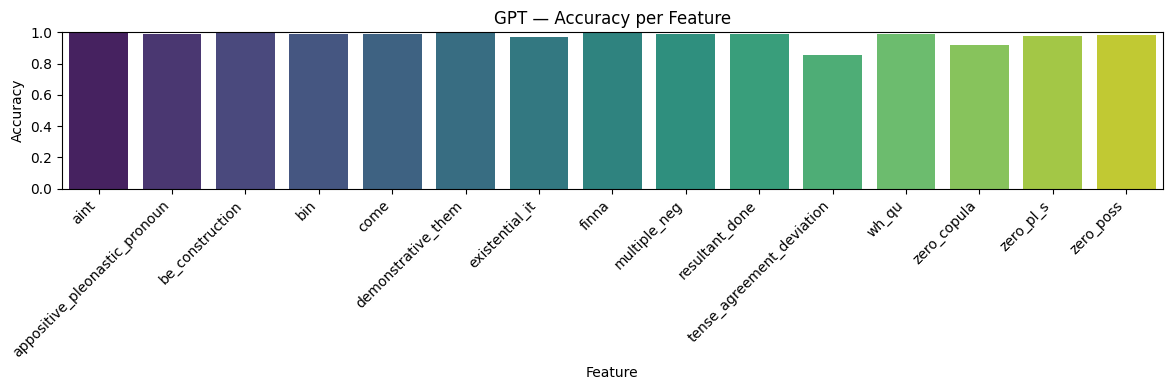

/tmp/ipython-input-64-208513665.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='feature', y=metric, palette='viridis')


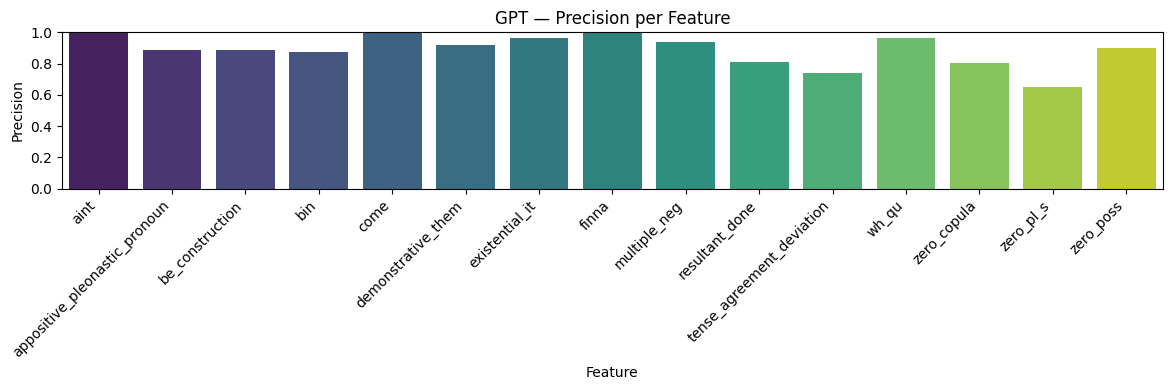

/tmp/ipython-input-64-208513665.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='feature', y=metric, palette='viridis')


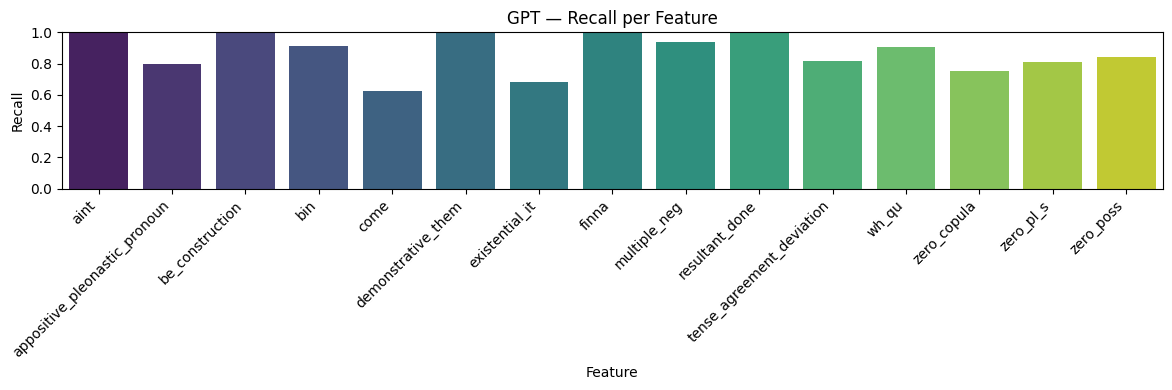

/tmp/ipython-input-64-208513665.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='feature', y=metric, palette='viridis')


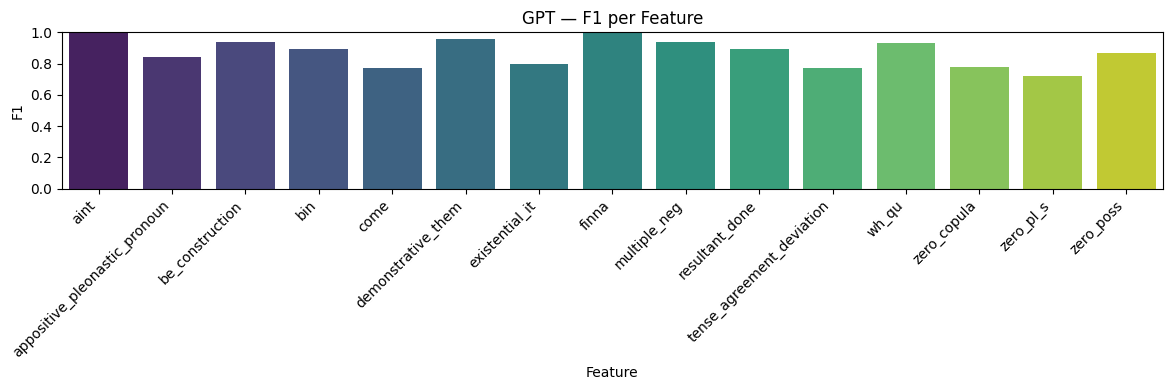

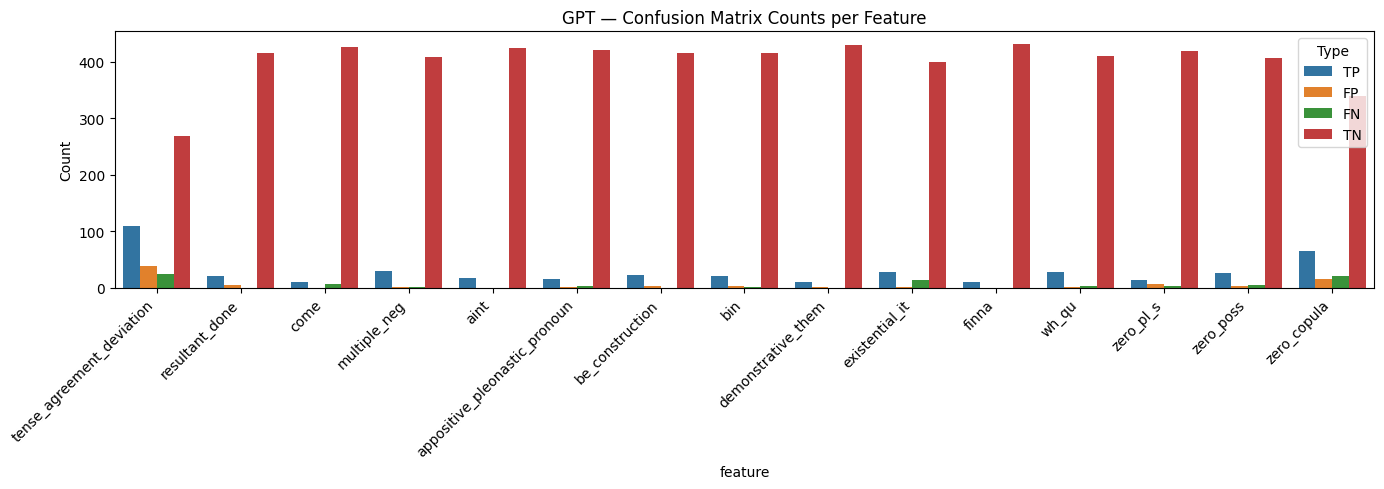

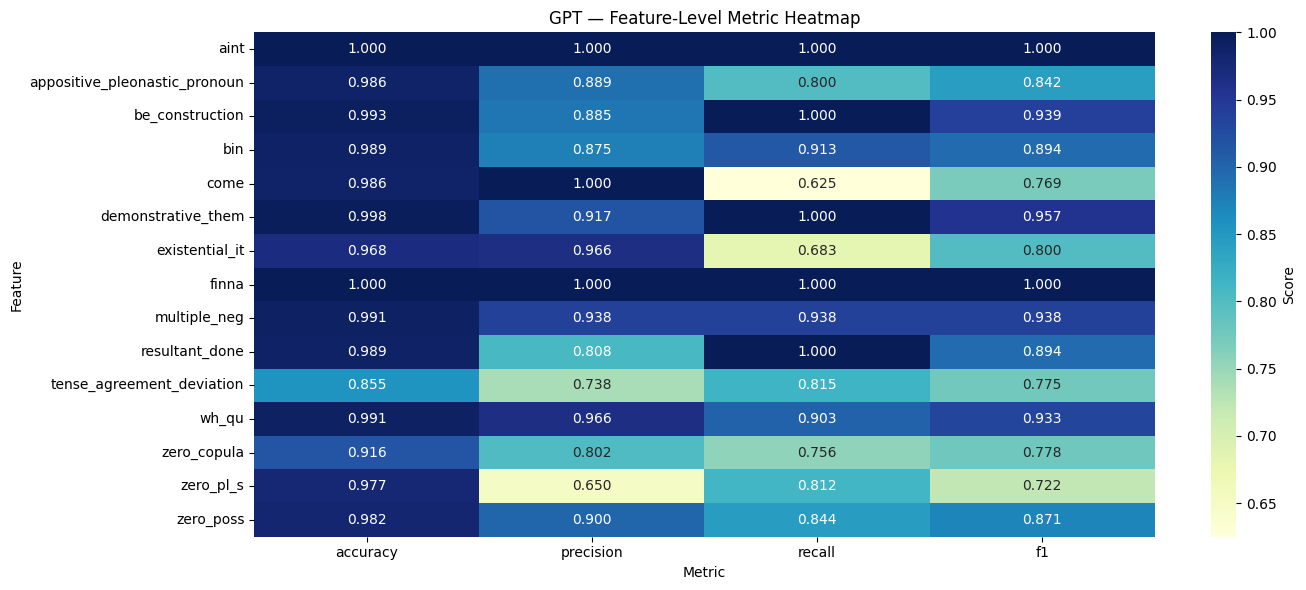

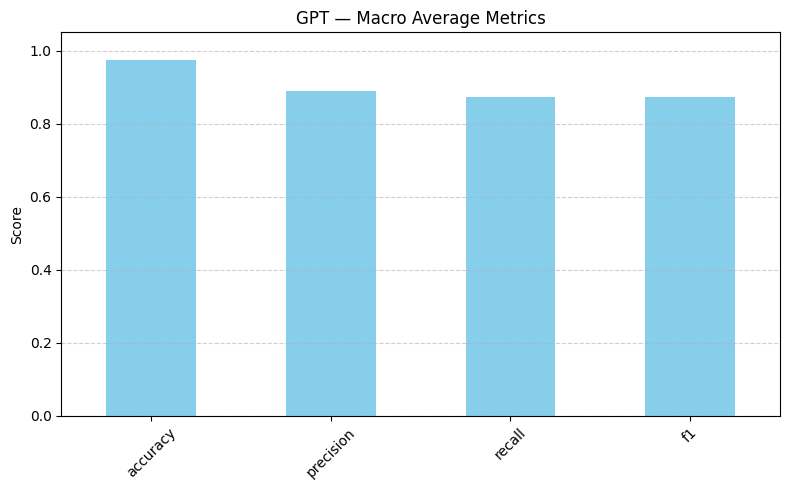

In [ ]:
def plot_model_metrics(results_df, model_name):
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for metric in metrics:
        plt.figure(figsize=(12, 4))
        data = results_df.sort_values(by='feature')
        sns.barplot(data=data, x='feature', y=metric, palette='viridis')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'{model_name} — {metric.capitalize()} per Feature')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Feature')
        plt.ylim(0, 1 if metric != 'brier' else 0.3)
        plt.tight_layout()
        plt.show()

def plot_confusion_counts(results_df, model_name):
    cm_long = results_df.melt(
        id_vars='feature',
        value_vars=['TP', 'FP', 'FN', 'TN'],
        var_name='Type',
        value_name='Count'
    )

    plt.figure(figsize=(14, 5))
    sns.barplot(data=cm_long, x='feature', y='Count', hue='Type')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{model_name} — Confusion Matrix Counts per Feature')
    plt.tight_layout()
    plt.show()

def plot_metric_heatmap(results_df, model_name):
    heatmap_data = results_df.set_index("feature")[['accuracy', 'precision', 'recall', 'f1']]
    heatmap_data = heatmap_data.sort_index()  # Sort features alphabetically
    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data.round(3), annot=True, cmap="YlGnBu", cbar_kws={"label": "Score"}, fmt=".3f")
    plt.title(f'{model_name} — Feature-Level Metric Heatmap')
    plt.ylabel('Feature')
    plt.xlabel('Metric')
    plt.tight_layout()
    plt.show()

def plot_macro_averages_bar(results_df, model_name):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    macro_avgs = results_df[metrics].mean().dropna()  # Drop NaN if brier is missing
    plt.figure(figsize=(8, 5))
    macro_avgs.plot(kind='bar', color='skyblue')
    plt.title(f"{model_name} — Macro Average Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_model_metrics(gpt_eval, "GPT")
plot_confusion_counts(gpt_eval, "GPT")
plot_metric_heatmap(gpt_eval, "GPT")
plot_macro_averages_bar(gpt_eval, "GPT")